In [23]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from scipy import stats 

import xgboost as xgb
import catboost as cat
from optimizer.XGBoostOptimizer import XGBoostOptimizer
from optimizer.CatBoostOptimizer import CatBoostOptimizer

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from docs import numeric_cols,category_cols,target_col
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

* 數據包含10個數字屬性和8個分類屬性
* 'Revenue' 屬性將作為標籤 1 代表會訂房 0 代表不會
* 使用訓練資料 train.csv 建立模型，預測 test.csv 是否會訂房
* 屬性說明：
	- Administrative：管理頁面瀏覽數量
	- Administrative_Duration：管理頁面瀏覽時間
	- Informational：資訊頁面瀏覽數量
	- Informational_Duration：資訊頁面瀏覽時間
	- ProductRelated：產品頁面瀏覽數量
	- ProductRelated_Duration：產品頁面瀏覽時間
	- BounceRates：跳出率
	- ExitRates：退出率
	- PageValues：頁面價值
	- SpecialDay：特殊日期（例如聖誕節，情人節）接近程度
	- Month：訪問月份
	- OperatingSystems：作業系統
	- Browser：瀏覽器
	- Region：地區
	- TrafficType：流量來源
	- VisitorType：訪客類型
	- Weekend：訪問時間是否為週末
	- Revenue：是否訂房

In [6]:
data = pd.read_csv("../data/train.csv")

for c in numeric_cols:
    data[c] = data[c].astype('float32')
for c in category_cols:
    data[c] = data[c].astype('category')

data[target_col] = data[target_col].astype('category')
print(data.describe())

                ID  Administrative  Administrative_Duration  Informational  \
count  8100.000000     8100.000000              8100.000000    8100.000000   
mean   4500.375432        2.309876                80.926109       0.498025   
std    2601.276244        3.311618               180.089691       1.258088   
min       0.000000        0.000000                 0.000000       0.000000   
25%    2237.750000        0.000000                 0.000000       0.000000   
50%    4504.500000        1.000000                 7.000000       0.000000   
75%    6760.250000        4.000000                91.988636       0.000000   
max    8999.000000       27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             8100.000000     8100.000000             8.099000e+03   
mean                32.884300       31.787161             8.311547e+04   
std                135.210892       44.961094             6.359096e+06   
m

<h1 align="center"><font color='red'>BounceRates　: 跳出率不應該為負值,這邊當作缺失值處理</font></h1>


In [7]:
data.loc[data['BounceRates']< 0, 'BounceRates'] = np.nan

<h1 align="center"><font color='orange'>查看數值變數分布<br>(大致上呈現右偏,後續可取log or 根號解決偏態問題)</font></h1>


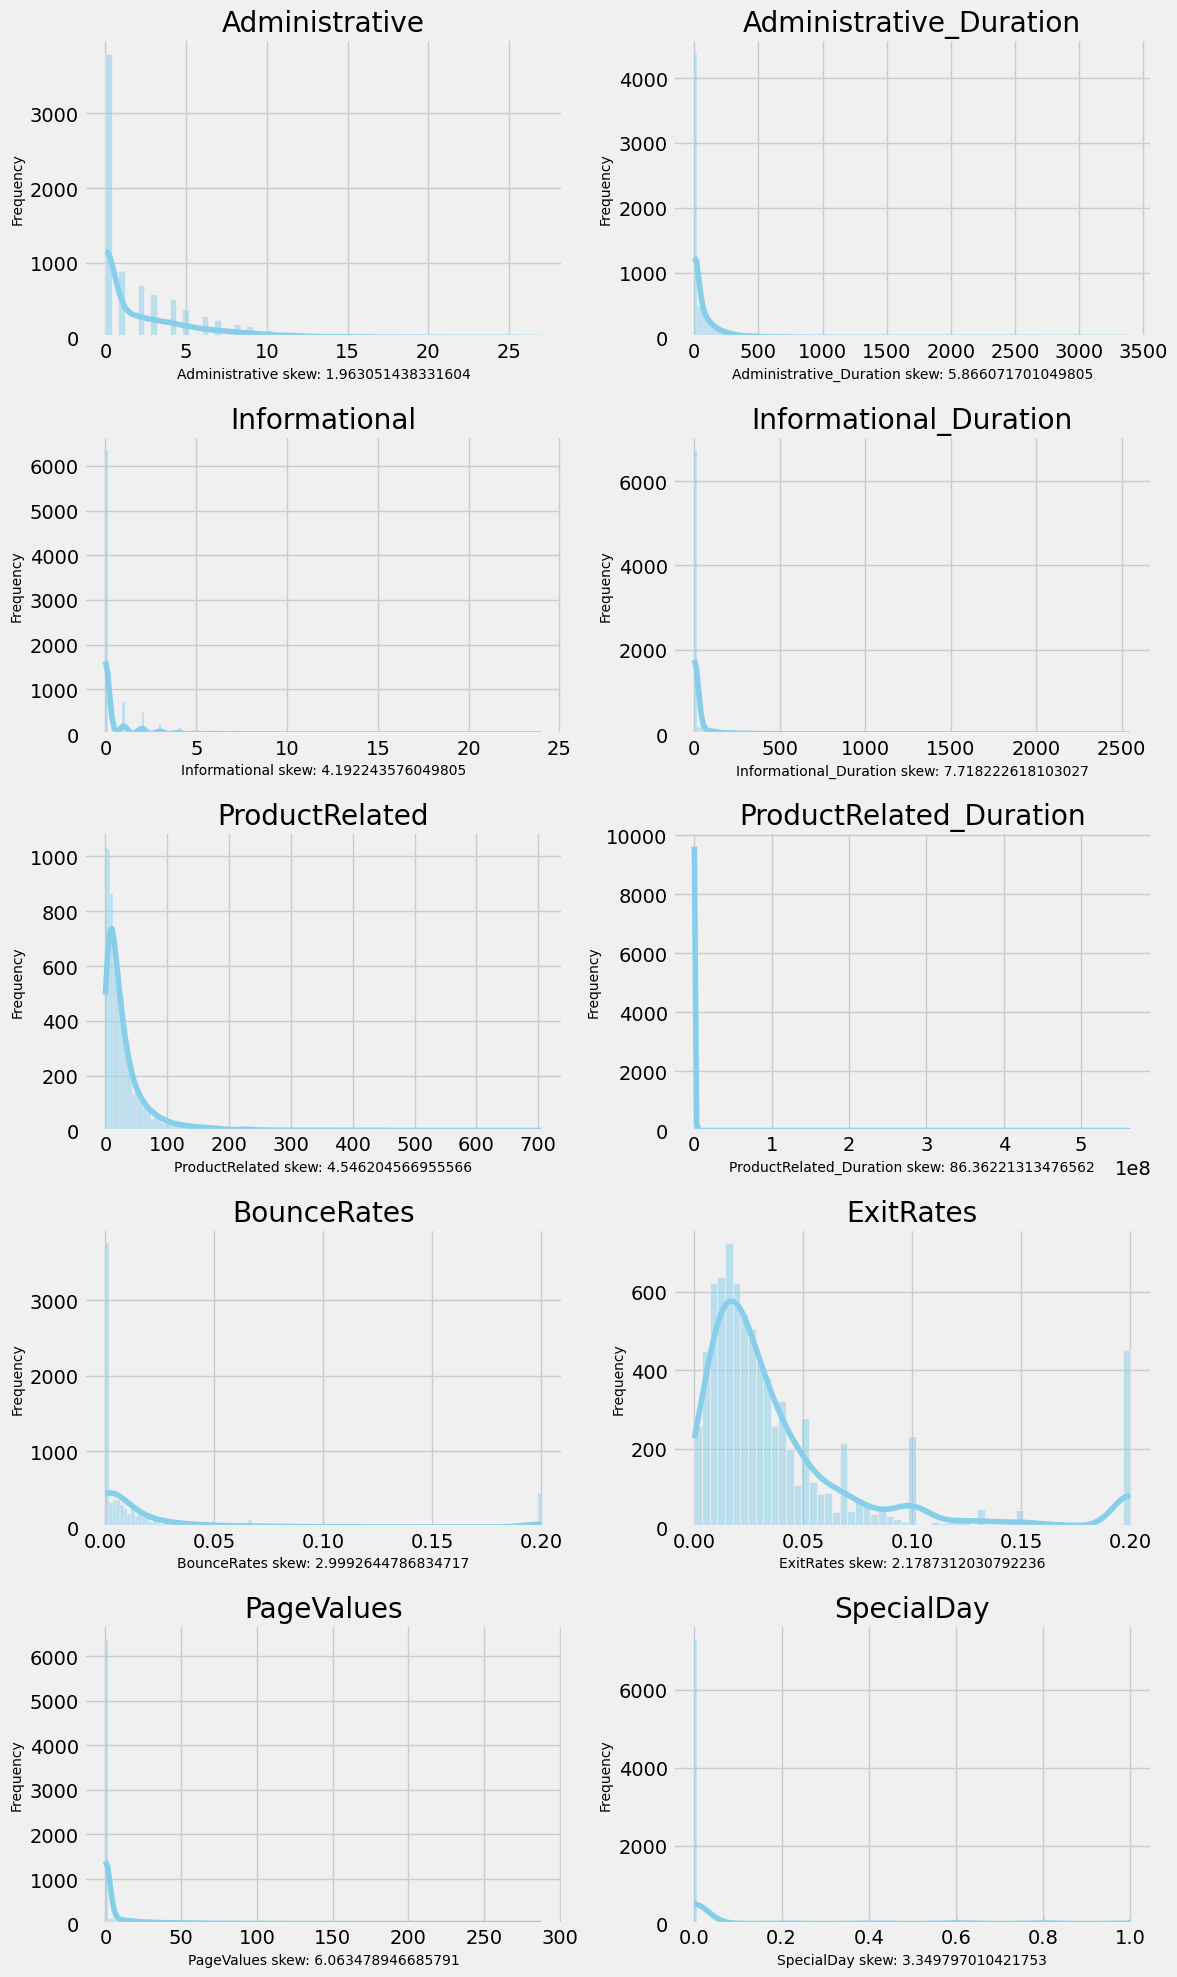

In [8]:
df = data.dropna().copy()
num_plots = len(numeric_cols)
num_rows = (num_plots + 1) // 2 
num_cols = 2 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 4)) # 調整整體大小
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue') # 可以調整顏色
    skewness = stats.skew(df[col], bias=False)
    axes[i].set_title(col)
    axes[i].set_xlabel(f"{col} skew: {skewness}", fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
plt.tight_layout()

<h2 align="center"><font color='orange'>檢查是否有遺失值 <br>ID= 1 這筆有4個欄位: Browser, Region ,TrafficType ,VisitorType有遺失值<br>我們取眾數填入,其餘的用預測的方式填入¶</font></h2>


In [9]:
na_counts = data.isnull().sum()
print("train source nan counts :\n",na_counts[na_counts > 0])
print('---------------------------------------------------------')
print('NA value counts > 1 rows \n',data[data.isnull().sum(axis=1)>1])
for c in ['Browser', 'Region' ,'TrafficType' ,'VisitorType']:
    data.loc[data['ID']==1,c] = data[c].mode().values
print('---------------------------------------------------------')
na_counts = data.isnull().sum()
print("After replace NA values.    :\n",na_counts[na_counts > 0])

data_preproc = data.dropna().copy()
for c in numeric_cols:
    data_preproc[c] = (data_preproc[c])**(1/3)


train source nan counts :
 ProductRelated_Duration    1
BounceRates                2
OperatingSystems           1
Browser                    1
Region                     1
TrafficType                1
VisitorType                1
dtype: int64
---------------------------------------------------------
NA value counts > 1 rows 
       ID  Administrative  Administrative_Duration  Informational  \
5378   1             1.0                      0.0            0.0   

      Informational_Duration  ProductRelated  ProductRelated_Duration  \
5378                     0.0             1.0                      0.0   

      BounceRates  ExitRates  PageValues  SpecialDay Month OperatingSystems  \
5378          0.2        0.2         0.0         0.6     2              3.0   

     Browser Region TrafficType VisitorType Weekend Revenue  
5378     NaN    NaN         NaN         NaN       0       0  
---------------------------------------------------------
After replace NA values.    :
 ProductRelated_D

In [10]:
def xgb_fill(preproc_data,source_data,na_target,model_type):
    """
    使用模型填值的function
    Args:
        - preproc_data : 整理偏態後的data
        - source_data : 原始data
        - na_target : 待填值的欄位(當作target)
        - model_type : 數值預測 or 分類  
    """
    
    X_features = [c for c in preproc_data.columns if  c != na_target]
    xgb_optimizer = XGBoostOptimizer(X=preproc_data[X_features], y=preproc_data[na_target], model_type=model_type)
    xgb_optimizer.optimize_params(
        optuna_n_trials=100,
        num_boost_round_per_trial=1000,
        early_stopping_rounds_per_trial=1,
        study_name=na_target,
    )
    xgb_optimizer.train_final_model()
    na_data = source_data[source_data[na_target].isna()].reset_index(drop=True)
    na_indices = source_data[source_data[na_target].isna()].reset_index(drop=True).index
    for c in numeric_cols:
        if c != na_target:
            na_data.loc[:,c] =  (na_data[c])**(1/3)
    fill_values = xgb_optimizer.predict(na_data[X_features])


    na_data.loc[na_indices, na_target] = fill_values
    
    return na_data

<h2 align="center"><font color='green'>開始預測的方式填入NA ...</font></h2>


In [26]:
repair_df = pd.DataFrame()
for na_col in na_counts[na_counts > 0].index:
    print(f'starting {na_col}...')
    if data_preproc[na_col].dtype == "float32":
        insert_df = xgb_fill(data_preproc,data,na_col,'regressor')
    elif data_preproc[na_col].dtype == "category":
        insert_df = xgb_fill(data_preproc,data,na_col,'classifier')
    else:
        pass
    repair_df = pd.concat([repair_df,insert_df]).reset_index(drop=True)

print("Before :\n",data[data.isna().any(axis=1)])
print()
print("After :\n",repair_df)

[I 2025-07-14 11:12:51,394] A new study created in memory with name: ProductRelated_Duration


starting ProductRelated_Duration...
Starting Optuna optimization for 100 trials...


[I 2025-07-14 11:12:51,590] Trial 0 finished with value: 8.584731753195594 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 8.584731753195594.
[I 2025-07-14 11:12:51,770] Trial 1 finished with value: 8.502726921821916 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 8.502726921821916.


Trial 0: Value = 8.584731753195594, Params = {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}
Trial 0 finished with rmse = 8.5847 and params: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}
Trial 1 finished with rmse = 8.5027 and params: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}


[I 2025-07-14 11:12:52,224] Trial 2 finished with value: 8.340286481794973 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 2 with value: 8.340286481794973.


Trial 2 finished with rmse = 8.3403 and params: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}


[I 2025-07-14 11:12:52,475] Trial 3 finished with value: 8.328296059211368 and parameters: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}. Best is trial 3 with value: 8.328296059211368.


Trial 3 finished with rmse = 8.3283 and params: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}


[I 2025-07-14 11:12:52,727] Trial 4 finished with value: 7.988544511306808 and parameters: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}. Best is trial 4 with value: 7.988544511306808.


Trial 4 finished with rmse = 7.9885 and params: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}


[I 2025-07-14 11:12:53,186] Trial 5 finished with value: 7.8735100990153395 and parameters: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 5 with value: 7.8735100990153395.


Trial 5 finished with rmse = 7.8735 and params: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}


[I 2025-07-14 11:12:53,490] Trial 6 finished with value: 8.351701586539594 and parameters: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}. Best is trial 5 with value: 7.8735100990153395.
[I 2025-07-14 11:12:53,619] Trial 7 finished with value: 8.28499809807187 and parameters: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}. Best is trial 5 with value: 7.8735100990153395.


Trial 6 finished with rmse = 8.3517 and params: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}
Trial 7 finished with rmse = 8.2850 and params: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}


[I 2025-07-14 11:12:54,246] Trial 8 finished with value: 7.979804471080652 and parameters: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 5 with value: 7.8735100990153395.


Trial 8 finished with rmse = 7.9798 and params: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}


[I 2025-07-14 11:12:54,495] Trial 9 finished with value: 8.380896910083113 and parameters: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}. Best is trial 5 with value: 7.8735100990153395.


Trial 9 finished with rmse = 8.3809 and params: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}


[I 2025-07-14 11:12:54,979] Trial 10 finished with value: 7.893470851646366 and parameters: {'max_depth': 10, 'learning_rate': 0.05259945893092018, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.9775724145208066, 'min_child_weight': 10, 'gamma': 3.9118863494340883}. Best is trial 5 with value: 7.8735100990153395.


Trial 10: Value = 7.893470851646366, Params = {'max_depth': 10, 'learning_rate': 0.05259945893092018, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.9775724145208066, 'min_child_weight': 10, 'gamma': 3.9118863494340883}
Trial 10 finished with rmse = 7.8935 and params: {'max_depth': 10, 'learning_rate': 0.05259945893092018, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.9775724145208066, 'min_child_weight': 10, 'gamma': 3.9118863494340883}


[I 2025-07-14 11:12:55,477] Trial 11 finished with value: 7.902048735356883 and parameters: {'max_depth': 10, 'learning_rate': 0.0554265892475972, 'subsample': 0.6963811307939647, 'colsample_bytree': 0.9987217645232701, 'min_child_weight': 10, 'gamma': 3.820927533995366}. Best is trial 5 with value: 7.8735100990153395.


Trial 11 finished with rmse = 7.9020 and params: {'max_depth': 10, 'learning_rate': 0.0554265892475972, 'subsample': 0.6963811307939647, 'colsample_bytree': 0.9987217645232701, 'min_child_weight': 10, 'gamma': 3.820927533995366}


[I 2025-07-14 11:12:55,997] Trial 12 finished with value: 7.960903559415738 and parameters: {'max_depth': 9, 'learning_rate': 0.04989254007887063, 'subsample': 0.6712579968688783, 'colsample_bytree': 0.983145161668354, 'min_child_weight': 7, 'gamma': 3.7042463905732115}. Best is trial 5 with value: 7.8735100990153395.


Trial 12 finished with rmse = 7.9609 and params: {'max_depth': 9, 'learning_rate': 0.04989254007887063, 'subsample': 0.6712579968688783, 'colsample_bytree': 0.983145161668354, 'min_child_weight': 7, 'gamma': 3.7042463905732115}


[I 2025-07-14 11:12:56,392] Trial 13 finished with value: 7.68203657797546 and parameters: {'max_depth': 8, 'learning_rate': 0.06685494210118739, 'subsample': 0.5306459984143026, 'colsample_bytree': 0.9315301535658721, 'min_child_weight': 8, 'gamma': 3.780583977260802}. Best is trial 13 with value: 7.68203657797546.


Trial 13 finished with rmse = 7.6820 and params: {'max_depth': 8, 'learning_rate': 0.06685494210118739, 'subsample': 0.5306459984143026, 'colsample_bytree': 0.9315301535658721, 'min_child_weight': 8, 'gamma': 3.780583977260802}


[I 2025-07-14 11:12:56,788] Trial 14 finished with value: 7.513868458534087 and parameters: {'max_depth': 8, 'learning_rate': 0.07301186290243704, 'subsample': 0.5018792846074281, 'colsample_bytree': 0.9373346225441148, 'min_child_weight': 8, 'gamma': 3.304278626461434}. Best is trial 14 with value: 7.513868458534087.


Trial 14 finished with rmse = 7.5139 and params: {'max_depth': 8, 'learning_rate': 0.07301186290243704, 'subsample': 0.5018792846074281, 'colsample_bytree': 0.9373346225441148, 'min_child_weight': 8, 'gamma': 3.304278626461434}


[I 2025-07-14 11:12:57,145] Trial 15 finished with value: 7.57821581758684 and parameters: {'max_depth': 8, 'learning_rate': 0.0717840384379999, 'subsample': 0.5127747474052715, 'colsample_bytree': 0.908316942866521, 'min_child_weight': 8, 'gamma': 3.2233684263404276}. Best is trial 14 with value: 7.513868458534087.


Trial 15 finished with rmse = 7.5782 and params: {'max_depth': 8, 'learning_rate': 0.0717840384379999, 'subsample': 0.5127747474052715, 'colsample_bytree': 0.908316942866521, 'min_child_weight': 8, 'gamma': 3.2233684263404276}


[I 2025-07-14 11:12:57,507] Trial 16 finished with value: 7.662190722158354 and parameters: {'max_depth': 8, 'learning_rate': 0.07556446685559576, 'subsample': 0.5128804310025348, 'colsample_bytree': 0.680371010605396, 'min_child_weight': 8, 'gamma': 3.1378244427082027}. Best is trial 14 with value: 7.513868458534087.


Trial 16 finished with rmse = 7.6622 and params: {'max_depth': 8, 'learning_rate': 0.07556446685559576, 'subsample': 0.5128804310025348, 'colsample_bytree': 0.680371010605396, 'min_child_weight': 8, 'gamma': 3.1378244427082027}


[I 2025-07-14 11:12:57,973] Trial 17 finished with value: 7.89027140169445 and parameters: {'max_depth': 8, 'learning_rate': 0.06665863409966075, 'subsample': 0.7361609808336008, 'colsample_bytree': 0.9017309340130191, 'min_child_weight': 8, 'gamma': 3.1571516168445664}. Best is trial 14 with value: 7.513868458534087.


Trial 17 finished with rmse = 7.8903 and params: {'max_depth': 8, 'learning_rate': 0.06665863409966075, 'subsample': 0.7361609808336008, 'colsample_bytree': 0.9017309340130191, 'min_child_weight': 8, 'gamma': 3.1571516168445664}


[I 2025-07-14 11:12:58,555] Trial 18 finished with value: 7.99899577161992 and parameters: {'max_depth': 9, 'learning_rate': 0.06630377960198139, 'subsample': 0.5872113299113478, 'colsample_bytree': 0.9164205793091332, 'min_child_weight': 6, 'gamma': 1.7403514199460277}. Best is trial 14 with value: 7.513868458534087.


Trial 18 finished with rmse = 7.9990 and params: {'max_depth': 9, 'learning_rate': 0.06630377960198139, 'subsample': 0.5872113299113478, 'colsample_bytree': 0.9164205793091332, 'min_child_weight': 6, 'gamma': 1.7403514199460277}


[I 2025-07-14 11:12:58,890] Trial 19 finished with value: 7.514251578348268 and parameters: {'max_depth': 5, 'learning_rate': 0.0798041041804749, 'subsample': 0.5004042138717625, 'colsample_bytree': 0.80502892953772, 'min_child_weight': 7, 'gamma': 3.166410826300366}. Best is trial 14 with value: 7.513868458534087.
[I 2025-07-14 11:12:59,039] Trial 20 finished with value: 8.312306510566627 and parameters: {'max_depth': 4, 'learning_rate': 0.08357769541029082, 'subsample': 0.9501074183915026, 'colsample_bytree': 0.7899235326494658, 'min_child_weight': 5, 'gamma': 2.2241215212896597}. Best is trial 14 with value: 7.513868458534087.


Trial 19 finished with rmse = 7.5143 and params: {'max_depth': 5, 'learning_rate': 0.0798041041804749, 'subsample': 0.5004042138717625, 'colsample_bytree': 0.80502892953772, 'min_child_weight': 7, 'gamma': 3.166410826300366}
Trial 20: Value = 8.312306510566627, Params = {'max_depth': 4, 'learning_rate': 0.08357769541029082, 'subsample': 0.9501074183915026, 'colsample_bytree': 0.7899235326494658, 'min_child_weight': 5, 'gamma': 2.2241215212896597}
Trial 20 finished with rmse = 8.3123 and params: {'max_depth': 4, 'learning_rate': 0.08357769541029082, 'subsample': 0.9501074183915026, 'colsample_bytree': 0.7899235326494658, 'min_child_weight': 5, 'gamma': 2.2241215212896597}


[I 2025-07-14 11:12:59,334] Trial 21 finished with value: 7.601495014794942 and parameters: {'max_depth': 5, 'learning_rate': 0.07356339015105746, 'subsample': 0.5084726174807298, 'colsample_bytree': 0.8422098279339344, 'min_child_weight': 7, 'gamma': 3.1925828600672292}. Best is trial 14 with value: 7.513868458534087.


Trial 21 finished with rmse = 7.6015 and params: {'max_depth': 5, 'learning_rate': 0.07356339015105746, 'subsample': 0.5084726174807298, 'colsample_bytree': 0.8422098279339344, 'min_child_weight': 7, 'gamma': 3.1925828600672292}


[I 2025-07-14 11:12:59,648] Trial 22 finished with value: 7.792089365820774 and parameters: {'max_depth': 6, 'learning_rate': 0.057831954941305455, 'subsample': 0.5664332118474326, 'colsample_bytree': 0.6680764443713514, 'min_child_weight': 9, 'gamma': 3.364978195036591}. Best is trial 14 with value: 7.513868458534087.


Trial 22 finished with rmse = 7.7921 and params: {'max_depth': 6, 'learning_rate': 0.057831954941305455, 'subsample': 0.5664332118474326, 'colsample_bytree': 0.6680764443713514, 'min_child_weight': 9, 'gamma': 3.364978195036591}


[I 2025-07-14 11:13:00,003] Trial 23 finished with value: 7.88031616169634 and parameters: {'max_depth': 8, 'learning_rate': 0.07519903445624021, 'subsample': 0.6374200406180913, 'colsample_bytree': 0.8781486085243526, 'min_child_weight': 7, 'gamma': 4.397503979440351}. Best is trial 14 with value: 7.513868458534087.


Trial 23 finished with rmse = 7.8803 and params: {'max_depth': 8, 'learning_rate': 0.07519903445624021, 'subsample': 0.6374200406180913, 'colsample_bytree': 0.8781486085243526, 'min_child_weight': 7, 'gamma': 4.397503979440351}


[I 2025-07-14 11:13:00,244] Trial 24 finished with value: 7.669808801072401 and parameters: {'max_depth': 4, 'learning_rate': 0.062192470280755474, 'subsample': 0.5016408040769373, 'colsample_bytree': 0.8009387152570259, 'min_child_weight': 9, 'gamma': 2.9452705967739345}. Best is trial 14 with value: 7.513868458534087.


Trial 24 finished with rmse = 7.6698 and params: {'max_depth': 4, 'learning_rate': 0.062192470280755474, 'subsample': 0.5016408040769373, 'colsample_bytree': 0.8009387152570259, 'min_child_weight': 9, 'gamma': 2.9452705967739345}


[I 2025-07-14 11:13:00,685] Trial 25 finished with value: 7.798237392744795 and parameters: {'max_depth': 7, 'learning_rate': 0.04479662191500892, 'subsample': 0.5559534872523956, 'colsample_bytree': 0.9399629923988706, 'min_child_weight': 9, 'gamma': 3.4823336833858667}. Best is trial 14 with value: 7.513868458534087.


Trial 25 finished with rmse = 7.7982 and params: {'max_depth': 7, 'learning_rate': 0.04479662191500892, 'subsample': 0.5559534872523956, 'colsample_bytree': 0.9399629923988706, 'min_child_weight': 9, 'gamma': 3.4823336833858667}


[I 2025-07-14 11:13:01,122] Trial 26 finished with value: 7.958664711184741 and parameters: {'max_depth': 9, 'learning_rate': 0.08326965149485122, 'subsample': 0.6298746491883304, 'colsample_bytree': 0.5101423720944536, 'min_child_weight': 6, 'gamma': 2.858341082463707}. Best is trial 14 with value: 7.513868458534087.


Trial 26 finished with rmse = 7.9587 and params: {'max_depth': 9, 'learning_rate': 0.08326965149485122, 'subsample': 0.6298746491883304, 'colsample_bytree': 0.5101423720944536, 'min_child_weight': 6, 'gamma': 2.858341082463707}


[I 2025-07-14 11:13:01,513] Trial 27 finished with value: 7.735794038196717 and parameters: {'max_depth': 8, 'learning_rate': 0.07302590499248153, 'subsample': 0.5779458621010147, 'colsample_bytree': 0.74850207467002, 'min_child_weight': 8, 'gamma': 2.102481256609803}. Best is trial 14 with value: 7.513868458534087.


Trial 27 finished with rmse = 7.7358 and params: {'max_depth': 8, 'learning_rate': 0.07302590499248153, 'subsample': 0.5779458621010147, 'colsample_bytree': 0.74850207467002, 'min_child_weight': 8, 'gamma': 2.102481256609803}


[I 2025-07-14 11:13:01,729] Trial 28 finished with value: 8.117448900164765 and parameters: {'max_depth': 4, 'learning_rate': 0.04246921893230853, 'subsample': 0.7177458283419876, 'colsample_bytree': 0.9399661261371346, 'min_child_weight': 7, 'gamma': 1.247169050806955}. Best is trial 14 with value: 7.513868458534087.
[I 2025-07-14 11:13:01,926] Trial 29 finished with value: 8.424967376142973 and parameters: {'max_depth': 6, 'learning_rate': 0.09977228456328764, 'subsample': 0.9067087287794953, 'colsample_bytree': 0.8638687768356054, 'min_child_weight': 5, 'gamma': 4.344835165159547}. Best is trial 14 with value: 7.513868458534087.


Trial 28 finished with rmse = 8.1174 and params: {'max_depth': 4, 'learning_rate': 0.04246921893230853, 'subsample': 0.7177458283419876, 'colsample_bytree': 0.9399661261371346, 'min_child_weight': 7, 'gamma': 1.247169050806955}
Trial 29 finished with rmse = 8.4250 and params: {'max_depth': 6, 'learning_rate': 0.09977228456328764, 'subsample': 0.9067087287794953, 'colsample_bytree': 0.8638687768356054, 'min_child_weight': 5, 'gamma': 4.344835165159547}


[I 2025-07-14 11:13:02,150] Trial 30 finished with value: 7.774041396653909 and parameters: {'max_depth': 5, 'learning_rate': 0.06046132571696663, 'subsample': 0.6505665001943406, 'colsample_bytree': 0.8107281297879307, 'min_child_weight': 9, 'gamma': 3.532705233244291}. Best is trial 14 with value: 7.513868458534087.


Trial 30: Value = 7.774041396653909, Params = {'max_depth': 5, 'learning_rate': 0.06046132571696663, 'subsample': 0.6505665001943406, 'colsample_bytree': 0.8107281297879307, 'min_child_weight': 9, 'gamma': 3.532705233244291}
Trial 30 finished with rmse = 7.7740 and params: {'max_depth': 5, 'learning_rate': 0.06046132571696663, 'subsample': 0.6505665001943406, 'colsample_bytree': 0.8107281297879307, 'min_child_weight': 9, 'gamma': 3.532705233244291}


[I 2025-07-14 11:13:02,500] Trial 31 finished with value: 7.538676997065283 and parameters: {'max_depth': 5, 'learning_rate': 0.07160997729045299, 'subsample': 0.5023373114359709, 'colsample_bytree': 0.8382374574175686, 'min_child_weight': 7, 'gamma': 3.2113381166304364}. Best is trial 14 with value: 7.513868458534087.


Trial 31 finished with rmse = 7.5387 and params: {'max_depth': 5, 'learning_rate': 0.07160997729045299, 'subsample': 0.5023373114359709, 'colsample_bytree': 0.8382374574175686, 'min_child_weight': 7, 'gamma': 3.2113381166304364}


[I 2025-07-14 11:13:02,750] Trial 32 finished with value: 7.510026658046111 and parameters: {'max_depth': 5, 'learning_rate': 0.07964246537261899, 'subsample': 0.5043872818993236, 'colsample_bytree': 0.7770607578670694, 'min_child_weight': 7, 'gamma': 2.9247010787386816}. Best is trial 32 with value: 7.510026658046111.
[I 2025-07-14 11:13:02,963] Trial 33 finished with value: 7.6459013329116114 and parameters: {'max_depth': 5, 'learning_rate': 0.08677734338282078, 'subsample': 0.5498998849531156, 'colsample_bytree': 0.7646363186967113, 'min_child_weight': 7, 'gamma': 2.6745884528116255}. Best is trial 32 with value: 7.510026658046111.


Trial 32 finished with rmse = 7.5100 and params: {'max_depth': 5, 'learning_rate': 0.07964246537261899, 'subsample': 0.5043872818993236, 'colsample_bytree': 0.7770607578670694, 'min_child_weight': 7, 'gamma': 2.9247010787386816}


[I 2025-07-14 11:13:03,154] Trial 34 finished with value: 7.878437471635783 and parameters: {'max_depth': 4, 'learning_rate': 0.078510519638405, 'subsample': 0.6033133319726472, 'colsample_bytree': 0.7072230435878697, 'min_child_weight': 6, 'gamma': 4.954888318934103}. Best is trial 32 with value: 7.510026658046111.


Trial 33 finished with rmse = 7.6459 and params: {'max_depth': 5, 'learning_rate': 0.08677734338282078, 'subsample': 0.5498998849531156, 'colsample_bytree': 0.7646363186967113, 'min_child_weight': 7, 'gamma': 2.6745884528116255}


[I 2025-07-14 11:13:03,288] Trial 35 finished with value: 8.46685858357001 and parameters: {'max_depth': 3, 'learning_rate': 0.08812888237275851, 'subsample': 0.7852998532515021, 'colsample_bytree': 0.8383394985234398, 'min_child_weight': 5, 'gamma': 2.296309473004554}. Best is trial 32 with value: 7.510026658046111.


Trial 34 finished with rmse = 7.8784 and params: {'max_depth': 4, 'learning_rate': 0.078510519638405, 'subsample': 0.6033133319726472, 'colsample_bytree': 0.7072230435878697, 'min_child_weight': 6, 'gamma': 4.954888318934103}
Trial 35 finished with rmse = 8.4669 and params: {'max_depth': 3, 'learning_rate': 0.08812888237275851, 'subsample': 0.7852998532515021, 'colsample_bytree': 0.8383394985234398, 'min_child_weight': 5, 'gamma': 2.296309473004554}


[I 2025-07-14 11:13:03,535] Trial 36 finished with value: 7.6896335537788785 and parameters: {'max_depth': 6, 'learning_rate': 0.07957806138172716, 'subsample': 0.53420156844311, 'colsample_bytree': 0.7719278110697921, 'min_child_weight': 7, 'gamma': 2.8960789453422846}. Best is trial 32 with value: 7.510026658046111.


Trial 36 finished with rmse = 7.6896 and params: {'max_depth': 6, 'learning_rate': 0.07957806138172716, 'subsample': 0.53420156844311, 'colsample_bytree': 0.7719278110697921, 'min_child_weight': 7, 'gamma': 2.8960789453422846}


[I 2025-07-14 11:13:04,031] Trial 37 finished with value: 7.995145123773355 and parameters: {'max_depth': 5, 'learning_rate': 0.01133030846572173, 'subsample': 0.5002496434604617, 'colsample_bytree': 0.7182894265004651, 'min_child_weight': 6, 'gamma': 4.059658260135951}. Best is trial 32 with value: 7.510026658046111.
[I 2025-07-14 11:13:04,220] Trial 38 finished with value: 8.24914927780618 and parameters: {'max_depth': 5, 'learning_rate': 0.07025700913173867, 'subsample': 0.5810693129857292, 'colsample_bytree': 0.6407090266007307, 'min_child_weight': 4, 'gamma': 0.26455843801402823}. Best is trial 32 with value: 7.510026658046111.


Trial 37 finished with rmse = 7.9951 and params: {'max_depth': 5, 'learning_rate': 0.01133030846572173, 'subsample': 0.5002496434604617, 'colsample_bytree': 0.7182894265004651, 'min_child_weight': 6, 'gamma': 4.059658260135951}
Trial 38 finished with rmse = 8.2491 and params: {'max_depth': 5, 'learning_rate': 0.07025700913173867, 'subsample': 0.5810693129857292, 'colsample_bytree': 0.6407090266007307, 'min_child_weight': 4, 'gamma': 0.26455843801402823}


[I 2025-07-14 11:13:05,057] Trial 39 finished with value: 7.6949431355428946 and parameters: {'max_depth': 4, 'learning_rate': 0.09782850890698029, 'subsample': 0.6105879397927281, 'colsample_bytree': 0.8186111078200693, 'min_child_weight': 8, 'gamma': 2.5186097727720638}. Best is trial 32 with value: 7.510026658046111.


Trial 39 finished with rmse = 7.6949 and params: {'max_depth': 4, 'learning_rate': 0.09782850890698029, 'subsample': 0.6105879397927281, 'colsample_bytree': 0.8186111078200693, 'min_child_weight': 8, 'gamma': 2.5186097727720638}


[I 2025-07-14 11:13:05,309] Trial 40 finished with value: 7.754870316149459 and parameters: {'max_depth': 6, 'learning_rate': 0.08884445965311144, 'subsample': 0.5332112616744606, 'colsample_bytree': 0.7438822170443521, 'min_child_weight': 6, 'gamma': 2.0104976357615163}. Best is trial 32 with value: 7.510026658046111.


Trial 40: Value = 7.754870316149459, Params = {'max_depth': 6, 'learning_rate': 0.08884445965311144, 'subsample': 0.5332112616744606, 'colsample_bytree': 0.7438822170443521, 'min_child_weight': 6, 'gamma': 2.0104976357615163}
Trial 40 finished with rmse = 7.7549 and params: {'max_depth': 6, 'learning_rate': 0.08884445965311144, 'subsample': 0.5332112616744606, 'colsample_bytree': 0.7438822170443521, 'min_child_weight': 6, 'gamma': 2.0104976357615163}


[I 2025-07-14 11:13:05,655] Trial 41 finished with value: 7.620405798514945 and parameters: {'max_depth': 7, 'learning_rate': 0.06951315402420313, 'subsample': 0.5219445786989945, 'colsample_bytree': 0.9058486122595245, 'min_child_weight': 8, 'gamma': 3.3436993194130897}. Best is trial 32 with value: 7.510026658046111.


Trial 41 finished with rmse = 7.6204 and params: {'max_depth': 7, 'learning_rate': 0.06951315402420313, 'subsample': 0.5219445786989945, 'colsample_bytree': 0.9058486122595245, 'min_child_weight': 8, 'gamma': 3.3436993194130897}


[I 2025-07-14 11:13:06,000] Trial 42 finished with value: 7.774394697243904 and parameters: {'max_depth': 7, 'learning_rate': 0.06278272419850428, 'subsample': 0.5531126860912967, 'colsample_bytree': 0.8647460197741335, 'min_child_weight': 7, 'gamma': 2.8591365508259163}. Best is trial 32 with value: 7.510026658046111.


Trial 42 finished with rmse = 7.7744 and params: {'max_depth': 7, 'learning_rate': 0.06278272419850428, 'subsample': 0.5531126860912967, 'colsample_bytree': 0.8647460197741335, 'min_child_weight': 7, 'gamma': 2.8591365508259163}


[I 2025-07-14 11:13:06,259] Trial 43 finished with value: 7.61333132820347 and parameters: {'max_depth': 5, 'learning_rate': 0.08337138181792295, 'subsample': 0.501693390795489, 'colsample_bytree': 0.7863153568904425, 'min_child_weight': 9, 'gamma': 3.5799068858772887}. Best is trial 32 with value: 7.510026658046111.


Trial 43 finished with rmse = 7.6133 and params: {'max_depth': 5, 'learning_rate': 0.08337138181792295, 'subsample': 0.501693390795489, 'colsample_bytree': 0.7863153568904425, 'min_child_weight': 9, 'gamma': 3.5799068858772887}


[I 2025-07-14 11:13:06,522] Trial 44 finished with value: 7.825146561057084 and parameters: {'max_depth': 6, 'learning_rate': 0.07774165904307515, 'subsample': 0.562762766330996, 'colsample_bytree': 0.9559236274349487, 'min_child_weight': 8, 'gamma': 4.0820133556043885}. Best is trial 32 with value: 7.510026658046111.
[I 2025-07-14 11:13:06,694] Trial 45 finished with value: 7.789224532563834 and parameters: {'max_depth': 3, 'learning_rate': 0.07062810661824279, 'subsample': 0.528639686056845, 'colsample_bytree': 0.8832357024566734, 'min_child_weight': 7, 'gamma': 3.100681198122861}. Best is trial 32 with value: 7.510026658046111.


Trial 44 finished with rmse = 7.8251 and params: {'max_depth': 6, 'learning_rate': 0.07774165904307515, 'subsample': 0.562762766330996, 'colsample_bytree': 0.9559236274349487, 'min_child_weight': 8, 'gamma': 4.0820133556043885}
Trial 45 finished with rmse = 7.7892 and params: {'max_depth': 3, 'learning_rate': 0.07062810661824279, 'subsample': 0.528639686056845, 'colsample_bytree': 0.8832357024566734, 'min_child_weight': 7, 'gamma': 3.100681198122861}


[I 2025-07-14 11:13:07,252] Trial 46 finished with value: 7.895459356722091 and parameters: {'max_depth': 10, 'learning_rate': 0.09360669560701053, 'subsample': 0.7769163235943486, 'colsample_bytree': 0.8256878710663632, 'min_child_weight': 8, 'gamma': 4.661230074006849}. Best is trial 32 with value: 7.510026658046111.


Trial 46 finished with rmse = 7.8955 and params: {'max_depth': 10, 'learning_rate': 0.09360669560701053, 'subsample': 0.7769163235943486, 'colsample_bytree': 0.8256878710663632, 'min_child_weight': 8, 'gamma': 4.661230074006849}


[I 2025-07-14 11:13:07,698] Trial 47 finished with value: 7.7094379107576145 and parameters: {'max_depth': 9, 'learning_rate': 0.08146480618593516, 'subsample': 0.6063599570134487, 'colsample_bytree': 0.8497507160840462, 'min_child_weight': 9, 'gamma': 2.6438039613786373}. Best is trial 32 with value: 7.510026658046111.


Trial 47 finished with rmse = 7.7094 and params: {'max_depth': 9, 'learning_rate': 0.08146480618593516, 'subsample': 0.6063599570134487, 'colsample_bytree': 0.8497507160840462, 'min_child_weight': 9, 'gamma': 2.6438039613786373}


[I 2025-07-14 11:13:08,067] Trial 48 finished with value: 7.736353576966858 and parameters: {'max_depth': 8, 'learning_rate': 0.06439034785342121, 'subsample': 0.5248555113554728, 'colsample_bytree': 0.9040372001663415, 'min_child_weight': 7, 'gamma': 3.3180805722613096}. Best is trial 32 with value: 7.510026658046111.


Trial 48 finished with rmse = 7.7364 and params: {'max_depth': 8, 'learning_rate': 0.06439034785342121, 'subsample': 0.5248555113554728, 'colsample_bytree': 0.9040372001663415, 'min_child_weight': 7, 'gamma': 3.3180805722613096}


[I 2025-07-14 11:13:08,404] Trial 49 finished with value: 8.444669858796027 and parameters: {'max_depth': 7, 'learning_rate': 0.05741768348456718, 'subsample': 0.8753398828078675, 'colsample_bytree': 0.9667622366925342, 'min_child_weight': 6, 'gamma': 3.6750572560620225}. Best is trial 32 with value: 7.510026658046111.
[I 2025-07-14 11:13:08,607] Trial 50 finished with value: 8.366443329906701 and parameters: {'max_depth': 6, 'learning_rate': 0.08570234557428727, 'subsample': 0.5641667448683653, 'colsample_bytree': 0.9988127081896543, 'min_child_weight': 3, 'gamma': 2.3505615477785065}. Best is trial 32 with value: 7.510026658046111.


Trial 49 finished with rmse = 8.4447 and params: {'max_depth': 7, 'learning_rate': 0.05741768348456718, 'subsample': 0.8753398828078675, 'colsample_bytree': 0.9667622366925342, 'min_child_weight': 6, 'gamma': 3.6750572560620225}
Trial 50: Value = 8.366443329906701, Params = {'max_depth': 6, 'learning_rate': 0.08570234557428727, 'subsample': 0.5641667448683653, 'colsample_bytree': 0.9988127081896543, 'min_child_weight': 3, 'gamma': 2.3505615477785065}
Trial 50 finished with rmse = 8.3664 and params: {'max_depth': 6, 'learning_rate': 0.08570234557428727, 'subsample': 0.5641667448683653, 'colsample_bytree': 0.9988127081896543, 'min_child_weight': 3, 'gamma': 2.3505615477785065}


[I 2025-07-14 11:13:08,916] Trial 51 finished with value: 7.616614649525863 and parameters: {'max_depth': 5, 'learning_rate': 0.07399286106914651, 'subsample': 0.5150603510732615, 'colsample_bytree': 0.8427733103781572, 'min_child_weight': 7, 'gamma': 3.0705335576087824}. Best is trial 32 with value: 7.510026658046111.


Trial 51 finished with rmse = 7.6166 and params: {'max_depth': 5, 'learning_rate': 0.07399286106914651, 'subsample': 0.5150603510732615, 'colsample_bytree': 0.8427733103781572, 'min_child_weight': 7, 'gamma': 3.0705335576087824}


[I 2025-07-14 11:13:09,195] Trial 52 finished with value: 7.655692019319012 and parameters: {'max_depth': 5, 'learning_rate': 0.07115095059701168, 'subsample': 0.542376944967079, 'colsample_bytree': 0.8583359582332695, 'min_child_weight': 8, 'gamma': 3.233799027983926}. Best is trial 32 with value: 7.510026658046111.


Trial 52 finished with rmse = 7.6557 and params: {'max_depth': 5, 'learning_rate': 0.07115095059701168, 'subsample': 0.542376944967079, 'colsample_bytree': 0.8583359582332695, 'min_child_weight': 8, 'gamma': 3.233799027983926}


[I 2025-07-14 11:13:09,426] Trial 53 finished with value: 7.523353481194208 and parameters: {'max_depth': 4, 'learning_rate': 0.07587434483952749, 'subsample': 0.5000971593438789, 'colsample_bytree': 0.9263724951926997, 'min_child_weight': 7, 'gamma': 3.4375305500700284}. Best is trial 32 with value: 7.510026658046111.


Trial 53 finished with rmse = 7.5234 and params: {'max_depth': 4, 'learning_rate': 0.07587434483952749, 'subsample': 0.5000971593438789, 'colsample_bytree': 0.9263724951926997, 'min_child_weight': 7, 'gamma': 3.4375305500700284}


[I 2025-07-14 11:13:09,688] Trial 54 finished with value: 7.491673276472471 and parameters: {'max_depth': 4, 'learning_rate': 0.07680953227071102, 'subsample': 0.5001990124838491, 'colsample_bytree': 0.9285575487373594, 'min_child_weight': 8, 'gamma': 3.9102036930411077}. Best is trial 54 with value: 7.491673276472471.


Trial 54 finished with rmse = 7.4917 and params: {'max_depth': 4, 'learning_rate': 0.07680953227071102, 'subsample': 0.5001990124838491, 'colsample_bytree': 0.9285575487373594, 'min_child_weight': 8, 'gamma': 3.9102036930411077}


[I 2025-07-14 11:13:09,962] Trial 55 finished with value: 7.6836415680456955 and parameters: {'max_depth': 4, 'learning_rate': 0.0773322694205166, 'subsample': 0.5406666188998857, 'colsample_bytree': 0.9551024410402571, 'min_child_weight': 7, 'gamma': 4.2148292701265015}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:10,167] Trial 56 finished with value: 7.923327819909659 and parameters: {'max_depth': 3, 'learning_rate': 0.09049585097863017, 'subsample': 0.5741783659867811, 'colsample_bytree': 0.924023695428396, 'min_child_weight': 6, 'gamma': 3.8352521160722737}. Best is trial 54 with value: 7.491673276472471.


Trial 55 finished with rmse = 7.6836 and params: {'max_depth': 4, 'learning_rate': 0.0773322694205166, 'subsample': 0.5406666188998857, 'colsample_bytree': 0.9551024410402571, 'min_child_weight': 7, 'gamma': 4.2148292701265015}


[I 2025-07-14 11:13:10,369] Trial 57 finished with value: 8.04891527694384 and parameters: {'max_depth': 4, 'learning_rate': 0.06785665702913729, 'subsample': 0.5159968425052204, 'colsample_bytree': 0.8875209335866922, 'min_child_weight': 5, 'gamma': 3.9511740735524596}. Best is trial 54 with value: 7.491673276472471.


Trial 56 finished with rmse = 7.9233 and params: {'max_depth': 3, 'learning_rate': 0.09049585097863017, 'subsample': 0.5741783659867811, 'colsample_bytree': 0.924023695428396, 'min_child_weight': 6, 'gamma': 3.8352521160722737}


[I 2025-07-14 11:13:10,556] Trial 58 finished with value: 7.672180373409368 and parameters: {'max_depth': 4, 'learning_rate': 0.08147827459791249, 'subsample': 0.5502029388090512, 'colsample_bytree': 0.7872479812240771, 'min_child_weight': 10, 'gamma': 3.4722722332640514}. Best is trial 54 with value: 7.491673276472471.


Trial 57 finished with rmse = 8.0489 and params: {'max_depth': 4, 'learning_rate': 0.06785665702913729, 'subsample': 0.5159968425052204, 'colsample_bytree': 0.8875209335866922, 'min_child_weight': 5, 'gamma': 3.9511740735524596}


[I 2025-07-14 11:13:10,722] Trial 59 finished with value: 7.858287509642176 and parameters: {'max_depth': 3, 'learning_rate': 0.05137204639116606, 'subsample': 0.5923305011141204, 'colsample_bytree': 0.9348644904053722, 'min_child_weight': 8, 'gamma': 4.655789338036684}. Best is trial 54 with value: 7.491673276472471.


Trial 58 finished with rmse = 7.6722 and params: {'max_depth': 4, 'learning_rate': 0.08147827459791249, 'subsample': 0.5502029388090512, 'colsample_bytree': 0.7872479812240771, 'min_child_weight': 10, 'gamma': 3.4722722332640514}
Trial 59 finished with rmse = 7.8583 and params: {'max_depth': 3, 'learning_rate': 0.05137204639116606, 'subsample': 0.5923305011141204, 'colsample_bytree': 0.9348644904053722, 'min_child_weight': 8, 'gamma': 4.655789338036684}


[I 2025-07-14 11:13:10,931] Trial 60 finished with value: 7.64576705152511 and parameters: {'max_depth': 4, 'learning_rate': 0.07647615747840374, 'subsample': 0.519131060084568, 'colsample_bytree': 0.7376683741520611, 'min_child_weight': 9, 'gamma': 2.7743459522789298}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:11,132] Trial 61 finished with value: 7.570175308228107 and parameters: {'max_depth': 4, 'learning_rate': 0.07319700437038067, 'subsample': 0.5003941340238645, 'colsample_bytree': 0.9113295653681608, 'min_child_weight': 8, 'gamma': 2.994382255256482}. Best is trial 54 with value: 7.491673276472471.


Trial 60: Value = 7.64576705152511, Params = {'max_depth': 4, 'learning_rate': 0.07647615747840374, 'subsample': 0.519131060084568, 'colsample_bytree': 0.7376683741520611, 'min_child_weight': 9, 'gamma': 2.7743459522789298}
Trial 60 finished with rmse = 7.6458 and params: {'max_depth': 4, 'learning_rate': 0.07647615747840374, 'subsample': 0.519131060084568, 'colsample_bytree': 0.7376683741520611, 'min_child_weight': 9, 'gamma': 2.7743459522789298}
Trial 61 finished with rmse = 7.5702 and params: {'max_depth': 4, 'learning_rate': 0.07319700437038067, 'subsample': 0.5003941340238645, 'colsample_bytree': 0.9113295653681608, 'min_child_weight': 8, 'gamma': 2.994382255256482}


[I 2025-07-14 11:13:11,380] Trial 62 finished with value: 7.496291668622661 and parameters: {'max_depth': 4, 'learning_rate': 0.07964032236114198, 'subsample': 0.5006111090443203, 'colsample_bytree': 0.9541085357773298, 'min_child_weight': 7, 'gamma': 3.0280241215108923}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:11,536] Trial 63 finished with value: 7.790296161198748 and parameters: {'max_depth': 3, 'learning_rate': 0.08502296125062031, 'subsample': 0.5348169970800608, 'colsample_bytree': 0.9471606535525929, 'min_child_weight': 7, 'gamma': 3.67355199892686}. Best is trial 54 with value: 7.491673276472471.


Trial 62 finished with rmse = 7.4963 and params: {'max_depth': 4, 'learning_rate': 0.07964032236114198, 'subsample': 0.5006111090443203, 'colsample_bytree': 0.9541085357773298, 'min_child_weight': 7, 'gamma': 3.0280241215108923}
Trial 63 finished with rmse = 7.7903 and params: {'max_depth': 3, 'learning_rate': 0.08502296125062031, 'subsample': 0.5348169970800608, 'colsample_bytree': 0.9471606535525929, 'min_child_weight': 7, 'gamma': 3.67355199892686}


[I 2025-07-14 11:13:11,794] Trial 64 finished with value: 7.514581853804279 and parameters: {'max_depth': 5, 'learning_rate': 0.08034616110957052, 'subsample': 0.5002553920984643, 'colsample_bytree': 0.9821377095958735, 'min_child_weight': 7, 'gamma': 3.4079122900505325}. Best is trial 54 with value: 7.491673276472471.


Trial 64 finished with rmse = 7.5146 and params: {'max_depth': 5, 'learning_rate': 0.08034616110957052, 'subsample': 0.5002553920984643, 'colsample_bytree': 0.9821377095958735, 'min_child_weight': 7, 'gamma': 3.4079122900505325}


[I 2025-07-14 11:13:12,063] Trial 65 finished with value: 7.841887640474906 and parameters: {'max_depth': 5, 'learning_rate': 0.09309223334033548, 'subsample': 0.5415735815190668, 'colsample_bytree': 0.9671279224077445, 'min_child_weight': 6, 'gamma': 3.444644406514612}. Best is trial 54 with value: 7.491673276472471.


Trial 65 finished with rmse = 7.8419 and params: {'max_depth': 5, 'learning_rate': 0.09309223334033548, 'subsample': 0.5415735815190668, 'colsample_bytree': 0.9671279224077445, 'min_child_weight': 6, 'gamma': 3.444644406514612}


[I 2025-07-14 11:13:12,316] Trial 66 finished with value: 7.603112928492206 and parameters: {'max_depth': 4, 'learning_rate': 0.08045357374758917, 'subsample': 0.5167237209625088, 'colsample_bytree': 0.9869384613588981, 'min_child_weight': 7, 'gamma': 3.773432397328487}. Best is trial 54 with value: 7.491673276472471.


Trial 66 finished with rmse = 7.6031 and params: {'max_depth': 4, 'learning_rate': 0.08045357374758917, 'subsample': 0.5167237209625088, 'colsample_bytree': 0.9869384613588981, 'min_child_weight': 7, 'gamma': 3.773432397328487}


[I 2025-07-14 11:13:12,544] Trial 67 finished with value: 7.863905524563094 and parameters: {'max_depth': 5, 'learning_rate': 0.0753899472216688, 'subsample': 0.5653958440423622, 'colsample_bytree': 0.9865072125957063, 'min_child_weight': 8, 'gamma': 2.725070368579973}. Best is trial 54 with value: 7.491673276472471.


Trial 67 finished with rmse = 7.8639 and params: {'max_depth': 5, 'learning_rate': 0.0753899472216688, 'subsample': 0.5653958440423622, 'colsample_bytree': 0.9865072125957063, 'min_child_weight': 8, 'gamma': 2.725070368579973}


[I 2025-07-14 11:13:12,807] Trial 68 finished with value: 7.597088610821689 and parameters: {'max_depth': 4, 'learning_rate': 0.08201517747569635, 'subsample': 0.5156434439922857, 'colsample_bytree': 0.9676100937391534, 'min_child_weight': 7, 'gamma': 3.59834593830823}. Best is trial 54 with value: 7.491673276472471.


Trial 68 finished with rmse = 7.5971 and params: {'max_depth': 4, 'learning_rate': 0.08201517747569635, 'subsample': 0.5156434439922857, 'colsample_bytree': 0.9676100937391534, 'min_child_weight': 7, 'gamma': 3.59834593830823}


[I 2025-07-14 11:13:13,068] Trial 69 finished with value: 7.62874864597639 and parameters: {'max_depth': 5, 'learning_rate': 0.07843173322936875, 'subsample': 0.5291926487787366, 'colsample_bytree': 0.9277495804518296, 'min_child_weight': 8, 'gamma': 2.9810672472092516}. Best is trial 54 with value: 7.491673276472471.


Trial 69 finished with rmse = 7.6287 and params: {'max_depth': 5, 'learning_rate': 0.07843173322936875, 'subsample': 0.5291926487787366, 'colsample_bytree': 0.9277495804518296, 'min_child_weight': 8, 'gamma': 2.9810672472092516}


[I 2025-07-14 11:13:13,278] Trial 70 finished with value: 8.338999286217195 and parameters: {'max_depth': 3, 'learning_rate': 0.031212391782178633, 'subsample': 0.9869180352000326, 'colsample_bytree': 0.9520044709930977, 'min_child_weight': 6, 'gamma': 4.219812408754341}. Best is trial 54 with value: 7.491673276472471.


Trial 70: Value = 8.338999286217195, Params = {'max_depth': 3, 'learning_rate': 0.031212391782178633, 'subsample': 0.9869180352000326, 'colsample_bytree': 0.9520044709930977, 'min_child_weight': 6, 'gamma': 4.219812408754341}
Trial 70 finished with rmse = 8.3390 and params: {'max_depth': 3, 'learning_rate': 0.031212391782178633, 'subsample': 0.9869180352000326, 'colsample_bytree': 0.9520044709930977, 'min_child_weight': 6, 'gamma': 4.219812408754341}


[I 2025-07-14 11:13:13,579] Trial 71 finished with value: 7.496836781562095 and parameters: {'max_depth': 5, 'learning_rate': 0.08615333054413349, 'subsample': 0.5009775954187367, 'colsample_bytree': 0.810344187655816, 'min_child_weight': 7, 'gamma': 3.3176042202549088}. Best is trial 54 with value: 7.491673276472471.


Trial 71 finished with rmse = 7.4968 and params: {'max_depth': 5, 'learning_rate': 0.08615333054413349, 'subsample': 0.5009775954187367, 'colsample_bytree': 0.810344187655816, 'min_child_weight': 7, 'gamma': 3.3176042202549088}


[I 2025-07-14 11:13:13,838] Trial 72 finished with value: 7.494949642120299 and parameters: {'max_depth': 4, 'learning_rate': 0.08986192881829021, 'subsample': 0.5011502807847071, 'colsample_bytree': 0.8048575586988116, 'min_child_weight': 7, 'gamma': 3.3248842244834114}. Best is trial 54 with value: 7.491673276472471.


Trial 72 finished with rmse = 7.4949 and params: {'max_depth': 4, 'learning_rate': 0.08986192881829021, 'subsample': 0.5011502807847071, 'colsample_bytree': 0.8048575586988116, 'min_child_weight': 7, 'gamma': 3.3248842244834114}


[I 2025-07-14 11:13:14,094] Trial 73 finished with value: 7.634223229873669 and parameters: {'max_depth': 5, 'learning_rate': 0.08913375585786397, 'subsample': 0.5504377153295609, 'colsample_bytree': 0.8031927077751844, 'min_child_weight': 8, 'gamma': 3.272597188331485}. Best is trial 54 with value: 7.491673276472471.


Trial 73 finished with rmse = 7.6342 and params: {'max_depth': 5, 'learning_rate': 0.08913375585786397, 'subsample': 0.5504377153295609, 'colsample_bytree': 0.8031927077751844, 'min_child_weight': 8, 'gamma': 3.272597188331485}


[I 2025-07-14 11:13:14,312] Trial 74 finished with value: 8.255672810388086 and parameters: {'max_depth': 6, 'learning_rate': 0.09528914798165912, 'subsample': 0.8192567240541611, 'colsample_bytree': 0.7753820099833397, 'min_child_weight': 7, 'gamma': 3.094555090227748}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:14,516] Trial 75 finished with value: 7.749159619415126 and parameters: {'max_depth': 5, 'learning_rate': 0.08681364489520461, 'subsample': 0.5180091950440185, 'colsample_bytree': 0.8156801648220586, 'min_child_weight': 6, 'gamma': 2.517611074140665}. Best is trial 54 with value: 7.491673276472471.


Trial 74 finished with rmse = 8.2557 and params: {'max_depth': 6, 'learning_rate': 0.09528914798165912, 'subsample': 0.8192567240541611, 'colsample_bytree': 0.7753820099833397, 'min_child_weight': 7, 'gamma': 3.094555090227748}


[I 2025-07-14 11:13:14,684] Trial 76 finished with value: 8.202587131150803 and parameters: {'max_depth': 4, 'learning_rate': 0.09105836309873022, 'subsample': 0.5389968410683694, 'colsample_bytree': 0.696391572021885, 'min_child_weight': 1, 'gamma': 2.808685426740277}. Best is trial 54 with value: 7.491673276472471.


Trial 75 finished with rmse = 7.7492 and params: {'max_depth': 5, 'learning_rate': 0.08681364489520461, 'subsample': 0.5180091950440185, 'colsample_bytree': 0.8156801648220586, 'min_child_weight': 6, 'gamma': 2.517611074140665}
Trial 76 finished with rmse = 8.2026 and params: {'max_depth': 4, 'learning_rate': 0.09105836309873022, 'subsample': 0.5389968410683694, 'colsample_bytree': 0.696391572021885, 'min_child_weight': 1, 'gamma': 2.808685426740277}


[I 2025-07-14 11:13:14,908] Trial 77 finished with value: 7.847571162759445 and parameters: {'max_depth': 5, 'learning_rate': 0.08434386426812682, 'subsample': 0.5771122264693562, 'colsample_bytree': 0.7565582162345724, 'min_child_weight': 9, 'gamma': 3.919719464710015}. Best is trial 54 with value: 7.491673276472471.


Trial 77 finished with rmse = 7.8476 and params: {'max_depth': 5, 'learning_rate': 0.08434386426812682, 'subsample': 0.5771122264693562, 'colsample_bytree': 0.7565582162345724, 'min_child_weight': 9, 'gamma': 3.919719464710015}


[I 2025-07-14 11:13:15,159] Trial 78 finished with value: 7.63797373512323 and parameters: {'max_depth': 4, 'learning_rate': 0.09740941058830525, 'subsample': 0.5132375509392504, 'colsample_bytree': 0.8770775088607894, 'min_child_weight': 7, 'gamma': 3.3548120169904463}. Best is trial 54 with value: 7.491673276472471.


Trial 78 finished with rmse = 7.6380 and params: {'max_depth': 4, 'learning_rate': 0.09740941058830525, 'subsample': 0.5132375509392504, 'colsample_bytree': 0.8770775088607894, 'min_child_weight': 7, 'gamma': 3.3548120169904463}


[I 2025-07-14 11:13:15,393] Trial 79 finished with value: 8.229463370262497 and parameters: {'max_depth': 6, 'learning_rate': 0.07955623491009294, 'subsample': 0.6630706206541598, 'colsample_bytree': 0.9779381624943883, 'min_child_weight': 6, 'gamma': 2.986110253487981}. Best is trial 54 with value: 7.491673276472471.


Trial 79 finished with rmse = 8.2295 and params: {'max_depth': 6, 'learning_rate': 0.07955623491009294, 'subsample': 0.6630706206541598, 'colsample_bytree': 0.9779381624943883, 'min_child_weight': 6, 'gamma': 2.986110253487981}


[I 2025-07-14 11:13:15,787] Trial 80 finished with value: 7.555759100607591 and parameters: {'max_depth': 6, 'learning_rate': 0.08707273351425672, 'subsample': 0.5283250724292692, 'colsample_bytree': 0.737743199288358, 'min_child_weight': 8, 'gamma': 1.4475352748691397}. Best is trial 54 with value: 7.491673276472471.


Trial 80: Value = 7.555759100607591, Params = {'max_depth': 6, 'learning_rate': 0.08707273351425672, 'subsample': 0.5283250724292692, 'colsample_bytree': 0.737743199288358, 'min_child_weight': 8, 'gamma': 1.4475352748691397}
Trial 80 finished with rmse = 7.5558 and params: {'max_depth': 6, 'learning_rate': 0.08707273351425672, 'subsample': 0.5283250724292692, 'colsample_bytree': 0.737743199288358, 'min_child_weight': 8, 'gamma': 1.4475352748691397}


[I 2025-07-14 11:13:16,059] Trial 81 finished with value: 7.600216549635806 and parameters: {'max_depth': 4, 'learning_rate': 0.08343306893429168, 'subsample': 0.5070587568226921, 'colsample_bytree': 0.7999608178526872, 'min_child_weight': 7, 'gamma': 3.3988015965105545}. Best is trial 54 with value: 7.491673276472471.


Trial 81 finished with rmse = 7.6002 and params: {'max_depth': 4, 'learning_rate': 0.08343306893429168, 'subsample': 0.5070587568226921, 'colsample_bytree': 0.7999608178526872, 'min_child_weight': 7, 'gamma': 3.3988015965105545}


[I 2025-07-14 11:13:16,303] Trial 82 finished with value: 7.530079667046261 and parameters: {'max_depth': 4, 'learning_rate': 0.07487476605172784, 'subsample': 0.5040019607098357, 'colsample_bytree': 0.916099806637722, 'min_child_weight': 7, 'gamma': 3.5458538578448477}. Best is trial 54 with value: 7.491673276472471.


Trial 82 finished with rmse = 7.5301 and params: {'max_depth': 4, 'learning_rate': 0.07487476605172784, 'subsample': 0.5040019607098357, 'colsample_bytree': 0.916099806637722, 'min_child_weight': 7, 'gamma': 3.5458538578448477}


[I 2025-07-14 11:13:16,541] Trial 83 finished with value: 7.561195158749437 and parameters: {'max_depth': 4, 'learning_rate': 0.06845434288586583, 'subsample': 0.5019305402567208, 'colsample_bytree': 0.8293905616467364, 'min_child_weight': 7, 'gamma': 3.2023703050570744}. Best is trial 54 with value: 7.491673276472471.


Trial 83 finished with rmse = 7.5612 and params: {'max_depth': 4, 'learning_rate': 0.06845434288586583, 'subsample': 0.5019305402567208, 'colsample_bytree': 0.8293905616467364, 'min_child_weight': 7, 'gamma': 3.2023703050570744}


[I 2025-07-14 11:13:16,752] Trial 84 finished with value: 7.828341535913351 and parameters: {'max_depth': 5, 'learning_rate': 0.08021190804640899, 'subsample': 0.5594419523586116, 'colsample_bytree': 0.5582786511961941, 'min_child_weight': 8, 'gamma': 3.746966294518745}. Best is trial 54 with value: 7.491673276472471.


Trial 84 finished with rmse = 7.8283 and params: {'max_depth': 5, 'learning_rate': 0.08021190804640899, 'subsample': 0.5594419523586116, 'colsample_bytree': 0.5582786511961941, 'min_child_weight': 8, 'gamma': 3.746966294518745}


[I 2025-07-14 11:13:17,183] Trial 85 finished with value: 7.707865010601698 and parameters: {'max_depth': 9, 'learning_rate': 0.06498464698676908, 'subsample': 0.5278626063727507, 'colsample_bytree': 0.8961863871162059, 'min_child_weight': 7, 'gamma': 3.623008371269719}. Best is trial 54 with value: 7.491673276472471.


Trial 85 finished with rmse = 7.7079 and params: {'max_depth': 9, 'learning_rate': 0.06498464698676908, 'subsample': 0.5278626063727507, 'colsample_bytree': 0.8961863871162059, 'min_child_weight': 7, 'gamma': 3.623008371269719}


[I 2025-07-14 11:13:17,464] Trial 86 finished with value: 7.681199080691175 and parameters: {'max_depth': 4, 'learning_rate': 0.08253467650860828, 'subsample': 0.5477043952981514, 'colsample_bytree': 0.9414675866107749, 'min_child_weight': 8, 'gamma': 3.147061599133473}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:17,626] Trial 87 finished with value: 7.825720176505878 and parameters: {'max_depth': 3, 'learning_rate': 0.08958628194413863, 'subsample': 0.522812296594282, 'colsample_bytree': 0.9255712580490284, 'min_child_weight': 6, 'gamma': 3.4834229048640974}. Best is trial 54 with value: 7.491673276472471.


Trial 86 finished with rmse = 7.6812 and params: {'max_depth': 4, 'learning_rate': 0.08253467650860828, 'subsample': 0.5477043952981514, 'colsample_bytree': 0.9414675866107749, 'min_child_weight': 8, 'gamma': 3.147061599133473}
Trial 87 finished with rmse = 7.8257 and params: {'max_depth': 3, 'learning_rate': 0.08958628194413863, 'subsample': 0.522812296594282, 'colsample_bytree': 0.9255712580490284, 'min_child_weight': 6, 'gamma': 3.4834229048640974}


[I 2025-07-14 11:13:17,872] Trial 88 finished with value: 7.595887369955792 and parameters: {'max_depth': 5, 'learning_rate': 0.07714618065887242, 'subsample': 0.5127192374330974, 'colsample_bytree': 0.7752441862400361, 'min_child_weight': 7, 'gamma': 2.921128396083999}. Best is trial 54 with value: 7.491673276472471.


Trial 88 finished with rmse = 7.5959 and params: {'max_depth': 5, 'learning_rate': 0.07714618065887242, 'subsample': 0.5127192374330974, 'colsample_bytree': 0.7752441862400361, 'min_child_weight': 7, 'gamma': 2.921128396083999}


[I 2025-07-14 11:13:18,214] Trial 89 finished with value: 7.600275586927353 and parameters: {'max_depth': 4, 'learning_rate': 0.08584884495743839, 'subsample': 0.7350886061780952, 'colsample_bytree': 0.867568873345961, 'min_child_weight': 9, 'gamma': 3.2876697646786552}. Best is trial 54 with value: 7.491673276472471.


Trial 89 finished with rmse = 7.6003 and params: {'max_depth': 4, 'learning_rate': 0.08584884495743839, 'subsample': 0.7350886061780952, 'colsample_bytree': 0.867568873345961, 'min_child_weight': 9, 'gamma': 3.2876697646786552}


[I 2025-07-14 11:13:18,439] Trial 90 finished with value: 8.085428339978144 and parameters: {'max_depth': 5, 'learning_rate': 0.04657840401314241, 'subsample': 0.5383195817886371, 'colsample_bytree': 0.646089834948006, 'min_child_weight': 5, 'gamma': 2.385053515816903}. Best is trial 54 with value: 7.491673276472471.


Trial 90: Value = 8.085428339978144, Params = {'max_depth': 5, 'learning_rate': 0.04657840401314241, 'subsample': 0.5383195817886371, 'colsample_bytree': 0.646089834948006, 'min_child_weight': 5, 'gamma': 2.385053515816903}
Trial 90 finished with rmse = 8.0854 and params: {'max_depth': 5, 'learning_rate': 0.04657840401314241, 'subsample': 0.5383195817886371, 'colsample_bytree': 0.646089834948006, 'min_child_weight': 5, 'gamma': 2.385053515816903}


[I 2025-07-14 11:13:18,656] Trial 91 finished with value: 7.534903788943136 and parameters: {'max_depth': 4, 'learning_rate': 0.07479914714007052, 'subsample': 0.5001988348847806, 'colsample_bytree': 0.9609585009068041, 'min_child_weight': 7, 'gamma': 3.5151954956175056}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:18,852] Trial 92 finished with value: 7.651963625367256 and parameters: {'max_depth': 4, 'learning_rate': 0.07240539915315922, 'subsample': 0.5097876459100565, 'colsample_bytree': 0.9191766303609648, 'min_child_weight': 7, 'gamma': 3.835511677665946}. Best is trial 54 with value: 7.491673276472471.


Trial 91 finished with rmse = 7.5349 and params: {'max_depth': 4, 'learning_rate': 0.07479914714007052, 'subsample': 0.5001988348847806, 'colsample_bytree': 0.9609585009068041, 'min_child_weight': 7, 'gamma': 3.5151954956175056}


[I 2025-07-14 11:13:19,024] Trial 93 finished with value: 7.658584263962768 and parameters: {'max_depth': 3, 'learning_rate': 0.07587948377447508, 'subsample': 0.5237448187861045, 'colsample_bytree': 0.9425145754528893, 'min_child_weight': 8, 'gamma': 3.046163592986141}. Best is trial 54 with value: 7.491673276472471.


Trial 92 finished with rmse = 7.6520 and params: {'max_depth': 4, 'learning_rate': 0.07240539915315922, 'subsample': 0.5097876459100565, 'colsample_bytree': 0.9191766303609648, 'min_child_weight': 7, 'gamma': 3.835511677665946}
Trial 93 finished with rmse = 7.6586 and params: {'max_depth': 3, 'learning_rate': 0.07587948377447508, 'subsample': 0.5237448187861045, 'colsample_bytree': 0.9425145754528893, 'min_child_weight': 8, 'gamma': 3.046163592986141}


[I 2025-07-14 11:13:19,280] Trial 94 finished with value: 7.557252535350436 and parameters: {'max_depth': 4, 'learning_rate': 0.07881237990859168, 'subsample': 0.5081450799300946, 'colsample_bytree': 0.9877808192127456, 'min_child_weight': 7, 'gamma': 3.41321693381806}. Best is trial 54 with value: 7.491673276472471.


Trial 94 finished with rmse = 7.5573 and params: {'max_depth': 4, 'learning_rate': 0.07881237990859168, 'subsample': 0.5081450799300946, 'colsample_bytree': 0.9877808192127456, 'min_child_weight': 7, 'gamma': 3.41321693381806}


[I 2025-07-14 11:13:19,539] Trial 95 finished with value: 7.791969401183868 and parameters: {'max_depth': 5, 'learning_rate': 0.08137751647490771, 'subsample': 0.5329166721987426, 'colsample_bytree': 0.9017039946251801, 'min_child_weight': 6, 'gamma': 4.0532071368690845}. Best is trial 54 with value: 7.491673276472471.
[I 2025-07-14 11:13:19,709] Trial 96 finished with value: 8.363121512669213 and parameters: {'max_depth': 4, 'learning_rate': 0.07441346122888655, 'subsample': 0.9428025886540966, 'colsample_bytree': 0.7922079981841661, 'min_child_weight': 7, 'gamma': 3.5764446717409406}. Best is trial 54 with value: 7.491673276472471.


Trial 95 finished with rmse = 7.7920 and params: {'max_depth': 5, 'learning_rate': 0.08137751647490771, 'subsample': 0.5329166721987426, 'colsample_bytree': 0.9017039946251801, 'min_child_weight': 6, 'gamma': 4.0532071368690845}
Trial 96 finished with rmse = 8.3631 and params: {'max_depth': 4, 'learning_rate': 0.07441346122888655, 'subsample': 0.9428025886540966, 'colsample_bytree': 0.7922079981841661, 'min_child_weight': 7, 'gamma': 3.5764446717409406}


[I 2025-07-14 11:13:20,122] Trial 97 finished with value: 7.436701113971985 and parameters: {'max_depth': 5, 'learning_rate': 0.09214380275164574, 'subsample': 0.6175671957913178, 'colsample_bytree': 0.9745250486553807, 'min_child_weight': 8, 'gamma': 2.6016115927603813}. Best is trial 97 with value: 7.436701113971985.


Trial 97 finished with rmse = 7.4367 and params: {'max_depth': 5, 'learning_rate': 0.09214380275164574, 'subsample': 0.6175671957913178, 'colsample_bytree': 0.9745250486553807, 'min_child_weight': 8, 'gamma': 2.6016115927603813}


[I 2025-07-14 11:13:20,415] Trial 98 finished with value: 7.663172177293435 and parameters: {'max_depth': 5, 'learning_rate': 0.09470009141435977, 'subsample': 0.5544583519695003, 'colsample_bytree': 0.9751188943384931, 'min_child_weight': 8, 'gamma': 2.650092310890016}. Best is trial 97 with value: 7.436701113971985.


Trial 98 finished with rmse = 7.6632 and params: {'max_depth': 5, 'learning_rate': 0.09470009141435977, 'subsample': 0.5544583519695003, 'colsample_bytree': 0.9751188943384931, 'min_child_weight': 8, 'gamma': 2.650092310890016}


[I 2025-07-14 11:13:20,813] Trial 99 finished with value: 7.423860672043692 and parameters: {'max_depth': 5, 'learning_rate': 0.09970704143879248, 'subsample': 0.6127181796344539, 'colsample_bytree': 0.9984982600510777, 'min_child_weight': 8, 'gamma': 2.850843698797361}. Best is trial 99 with value: 7.423860672043692.
[I 2025-07-14 11:13:20,864] A new study created in memory with name: BounceRates


Trial 99 finished with rmse = 7.4239 and params: {'max_depth': 5, 'learning_rate': 0.09970704143879248, 'subsample': 0.6127181796344539, 'colsample_bytree': 0.9984982600510777, 'min_child_weight': 8, 'gamma': 2.850843698797361}

--- Optuna Optimization Finished ---
Best trial number: 99
Best score (MINIMIZE): 7.4239
Mean best boosting rounds: 121
Best parameters:
  max_depth: 5
  learning_rate: 0.09970704143879248
  subsample: 0.6127181796344539
  colsample_bytree: 0.9984982600510777
  min_child_weight: 8
  gamma: 2.850843698797361

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！
starting BounceRates...
Starting Optuna optimization for 100 trials...


[I 2025-07-14 11:13:21,078] Trial 0 finished with value: 0.08859685991483027 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.08859685991483027.
[I 2025-07-14 11:13:21,257] Trial 1 finished with value: 0.1104414535335686 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 0 with value: 0.08859685991483027.


Trial 0: Value = 0.08859685991483027, Params = {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}
Trial 0 finished with rmse = 0.0886 and params: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}
Trial 1 finished with rmse = 0.1104 and params: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}


[I 2025-07-14 11:13:21,588] Trial 2 finished with value: 0.10684105080789516 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 0 with value: 0.08859685991483027.


Trial 2 finished with rmse = 0.1068 and params: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}


[I 2025-07-14 11:13:21,913] Trial 3 finished with value: 0.0986395944216031 and parameters: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}. Best is trial 0 with value: 0.08859685991483027.


Trial 3 finished with rmse = 0.0986 and params: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}


[I 2025-07-14 11:13:22,275] Trial 4 finished with value: 0.08504127190965491 and parameters: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}. Best is trial 4 with value: 0.08504127190965491.


Trial 4 finished with rmse = 0.0850 and params: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}


[I 2025-07-14 11:13:22,545] Trial 5 finished with value: 0.11383950820255526 and parameters: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 4 with value: 0.08504127190965491.


Trial 5 finished with rmse = 0.1138 and params: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}


[I 2025-07-14 11:13:22,917] Trial 6 finished with value: 0.10055443877494115 and parameters: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}. Best is trial 4 with value: 0.08504127190965491.
[I 2025-07-14 11:13:23,100] Trial 7 finished with value: 0.10332582899308149 and parameters: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}. Best is trial 4 with value: 0.08504127190965491.


Trial 6 finished with rmse = 0.1006 and params: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}
Trial 7 finished with rmse = 0.1033 and params: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}


[I 2025-07-14 11:13:23,324] Trial 8 finished with value: 0.10701316920034927 and parameters: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 4 with value: 0.08504127190965491.


Trial 8 finished with rmse = 0.1070 and params: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}


[I 2025-07-14 11:13:23,575] Trial 9 finished with value: 0.09907567331145281 and parameters: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}. Best is trial 4 with value: 0.08504127190965491.


Trial 9 finished with rmse = 0.0991 and params: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}


[I 2025-07-14 11:13:23,917] Trial 10 finished with value: 0.08453264897721868 and parameters: {'max_depth': 10, 'learning_rate': 0.07073173610936001, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.7133275801737214, 'min_child_weight': 7, 'gamma': 0.19362599980591488}. Best is trial 10 with value: 0.08453264897721868.


Trial 10: Value = 0.08453264897721868, Params = {'max_depth': 10, 'learning_rate': 0.07073173610936001, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.7133275801737214, 'min_child_weight': 7, 'gamma': 0.19362599980591488}
Trial 10 finished with rmse = 0.0845 and params: {'max_depth': 10, 'learning_rate': 0.07073173610936001, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.7133275801737214, 'min_child_weight': 7, 'gamma': 0.19362599980591488}


[I 2025-07-14 11:13:24,501] Trial 11 finished with value: 0.08307640231087436 and parameters: {'max_depth': 10, 'learning_rate': 0.06741745796899551, 'subsample': 0.67951461563025, 'colsample_bytree': 0.6898021217101118, 'min_child_weight': 7, 'gamma': 0.043430179983345946}. Best is trial 11 with value: 0.08307640231087436.


Trial 11 finished with rmse = 0.0831 and params: {'max_depth': 10, 'learning_rate': 0.06741745796899551, 'subsample': 0.67951461563025, 'colsample_bytree': 0.6898021217101118, 'min_child_weight': 7, 'gamma': 0.043430179983345946}


[I 2025-07-14 11:13:25,115] Trial 12 finished with value: 0.08330173219104357 and parameters: {'max_depth': 10, 'learning_rate': 0.06540401312826828, 'subsample': 0.7039593671079457, 'colsample_bytree': 0.6838472792775279, 'min_child_weight': 7, 'gamma': 0.021088957454742464}. Best is trial 11 with value: 0.08307640231087436.


Trial 12 finished with rmse = 0.0833 and params: {'max_depth': 10, 'learning_rate': 0.06540401312826828, 'subsample': 0.7039593671079457, 'colsample_bytree': 0.6838472792775279, 'min_child_weight': 7, 'gamma': 0.021088957454742464}


[I 2025-07-14 11:13:25,344] Trial 13 finished with value: 0.09278551591557915 and parameters: {'max_depth': 9, 'learning_rate': 0.05663432490978868, 'subsample': 0.7092822389324893, 'colsample_bytree': 0.6608835888001324, 'min_child_weight': 8, 'gamma': 1.0441105864342917}. Best is trial 11 with value: 0.08307640231087436.


Trial 13 finished with rmse = 0.0928 and params: {'max_depth': 9, 'learning_rate': 0.05663432490978868, 'subsample': 0.7092822389324893, 'colsample_bytree': 0.6608835888001324, 'min_child_weight': 8, 'gamma': 1.0441105864342917}


[I 2025-07-14 11:13:26,138] Trial 14 finished with value: 0.08477421726839664 and parameters: {'max_depth': 10, 'learning_rate': 0.056734800543986635, 'subsample': 0.7306968273661332, 'colsample_bytree': 0.5229287482256113, 'min_child_weight': 8, 'gamma': 0.014762114491247851}. Best is trial 11 with value: 0.08307640231087436.


Trial 14 finished with rmse = 0.0848 and params: {'max_depth': 10, 'learning_rate': 0.056734800543986635, 'subsample': 0.7306968273661332, 'colsample_bytree': 0.5229287482256113, 'min_child_weight': 8, 'gamma': 0.014762114491247851}


[I 2025-07-14 11:13:26,406] Trial 15 finished with value: 0.09336611900253286 and parameters: {'max_depth': 9, 'learning_rate': 0.06966705868344723, 'subsample': 0.6685478759993453, 'colsample_bytree': 0.665289833992663, 'min_child_weight': 6, 'gamma': 1.1198686295234257}. Best is trial 11 with value: 0.08307640231087436.


Trial 15 finished with rmse = 0.0934 and params: {'max_depth': 9, 'learning_rate': 0.06966705868344723, 'subsample': 0.6685478759993453, 'colsample_bytree': 0.665289833992663, 'min_child_weight': 6, 'gamma': 1.1198686295234257}


[I 2025-07-14 11:13:26,629] Trial 16 finished with value: 0.10300164162242949 and parameters: {'max_depth': 8, 'learning_rate': 0.04475013147371094, 'subsample': 0.9270627421637063, 'colsample_bytree': 0.6625295682993932, 'min_child_weight': 8, 'gamma': 3.2561396552114967}. Best is trial 11 with value: 0.08307640231087436.


Trial 16 finished with rmse = 0.1030 and params: {'max_depth': 8, 'learning_rate': 0.04475013147371094, 'subsample': 0.9270627421637063, 'colsample_bytree': 0.6625295682993932, 'min_child_weight': 8, 'gamma': 3.2561396552114967}


[I 2025-07-14 11:13:26,890] Trial 17 finished with value: 0.08817834453933288 and parameters: {'max_depth': 10, 'learning_rate': 0.069520483429136, 'subsample': 0.7555270242934078, 'colsample_bytree': 0.7748344059259495, 'min_child_weight': 5, 'gamma': 0.6238445989918212}. Best is trial 11 with value: 0.08307640231087436.


Trial 17 finished with rmse = 0.0882 and params: {'max_depth': 10, 'learning_rate': 0.069520483429136, 'subsample': 0.7555270242934078, 'colsample_bytree': 0.7748344059259495, 'min_child_weight': 5, 'gamma': 0.6238445989918212}


[I 2025-07-14 11:13:27,167] Trial 18 finished with value: 0.0960879210302911 and parameters: {'max_depth': 8, 'learning_rate': 0.050369325120106875, 'subsample': 0.6466044848640861, 'colsample_bytree': 0.9314636609266265, 'min_child_weight': 9, 'gamma': 1.6016814281691336}. Best is trial 11 with value: 0.08307640231087436.


Trial 18 finished with rmse = 0.0961 and params: {'max_depth': 8, 'learning_rate': 0.050369325120106875, 'subsample': 0.6466044848640861, 'colsample_bytree': 0.9314636609266265, 'min_child_weight': 9, 'gamma': 1.6016814281691336}


[I 2025-07-14 11:13:27,543] Trial 19 finished with value: 0.08960101140309595 and parameters: {'max_depth': 8, 'learning_rate': 0.07828765502560506, 'subsample': 0.768867215574776, 'colsample_bytree': 0.5064453522774464, 'min_child_weight': 7, 'gamma': 0.5784423775886949}. Best is trial 11 with value: 0.08307640231087436.


Trial 19 finished with rmse = 0.0896 and params: {'max_depth': 8, 'learning_rate': 0.07828765502560506, 'subsample': 0.768867215574776, 'colsample_bytree': 0.5064453522774464, 'min_child_weight': 7, 'gamma': 0.5784423775886949}


[I 2025-07-14 11:13:27,775] Trial 20 finished with value: 0.11224265528294844 and parameters: {'max_depth': 10, 'learning_rate': 0.06182285212078222, 'subsample': 0.5065896071904618, 'colsample_bytree': 0.6309825597727609, 'min_child_weight': 5, 'gamma': 3.4925385379860145}. Best is trial 11 with value: 0.08307640231087436.


Trial 20: Value = 0.11224265528294844, Params = {'max_depth': 10, 'learning_rate': 0.06182285212078222, 'subsample': 0.5065896071904618, 'colsample_bytree': 0.6309825597727609, 'min_child_weight': 5, 'gamma': 3.4925385379860145}
Trial 20 finished with rmse = 0.1122 and params: {'max_depth': 10, 'learning_rate': 0.06182285212078222, 'subsample': 0.5065896071904618, 'colsample_bytree': 0.6309825597727609, 'min_child_weight': 5, 'gamma': 3.4925385379860145}


[I 2025-07-14 11:13:28,336] Trial 21 finished with value: 0.08302509366912222 and parameters: {'max_depth': 10, 'learning_rate': 0.06957161248930388, 'subsample': 0.6900913631930554, 'colsample_bytree': 0.7264708074223476, 'min_child_weight': 7, 'gamma': 0.06800549554695182}. Best is trial 21 with value: 0.08302509366912222.


Trial 21 finished with rmse = 0.0830 and params: {'max_depth': 10, 'learning_rate': 0.06957161248930388, 'subsample': 0.6900913631930554, 'colsample_bytree': 0.7264708074223476, 'min_child_weight': 7, 'gamma': 0.06800549554695182}


[I 2025-07-14 11:13:28,827] Trial 22 finished with value: 0.08317342711114828 and parameters: {'max_depth': 9, 'learning_rate': 0.07910419294697443, 'subsample': 0.7038176788923088, 'colsample_bytree': 0.7163728055902459, 'min_child_weight': 7, 'gamma': 0.07088585336088313}. Best is trial 21 with value: 0.08302509366912222.


Trial 22 finished with rmse = 0.0832 and params: {'max_depth': 9, 'learning_rate': 0.07910419294697443, 'subsample': 0.7038176788923088, 'colsample_bytree': 0.7163728055902459, 'min_child_weight': 7, 'gamma': 0.07088585336088313}


[I 2025-07-14 11:13:29,101] Trial 23 finished with value: 0.09324183032164665 and parameters: {'max_depth': 9, 'learning_rate': 0.08116801272374667, 'subsample': 0.6100022861162464, 'colsample_bytree': 0.7390601084584076, 'min_child_weight': 9, 'gamma': 1.1439003429366608}. Best is trial 21 with value: 0.08302509366912222.


Trial 23 finished with rmse = 0.0932 and params: {'max_depth': 9, 'learning_rate': 0.08116801272374667, 'subsample': 0.6100022861162464, 'colsample_bytree': 0.7390601084584076, 'min_child_weight': 9, 'gamma': 1.1439003429366608}


[I 2025-07-14 11:13:29,405] Trial 24 finished with value: 0.0878545942325243 and parameters: {'max_depth': 9, 'learning_rate': 0.07630171098755009, 'subsample': 0.6607022444591759, 'colsample_bytree': 0.8045216610913957, 'min_child_weight': 6, 'gamma': 0.5542205053910243}. Best is trial 21 with value: 0.08302509366912222.


Trial 24 finished with rmse = 0.0879 and params: {'max_depth': 9, 'learning_rate': 0.07630171098755009, 'subsample': 0.6607022444591759, 'colsample_bytree': 0.8045216610913957, 'min_child_weight': 6, 'gamma': 0.5542205053910243}


[I 2025-07-14 11:13:29,635] Trial 25 finished with value: 0.09816156400550391 and parameters: {'max_depth': 8, 'learning_rate': 0.08497604900837397, 'subsample': 0.7425899975568011, 'colsample_bytree': 0.7074640076628169, 'min_child_weight': 7, 'gamma': 2.0450053553516194}. Best is trial 21 with value: 0.08302509366912222.


Trial 25 finished with rmse = 0.0982 and params: {'max_depth': 8, 'learning_rate': 0.08497604900837397, 'subsample': 0.7425899975568011, 'colsample_bytree': 0.7074640076628169, 'min_child_weight': 7, 'gamma': 2.0450053553516194}


[I 2025-07-14 11:13:30,066] Trial 26 finished with value: 0.08823153603012787 and parameters: {'max_depth': 10, 'learning_rate': 0.04950642627459989, 'subsample': 0.5635719210044361, 'colsample_bytree': 0.6244723918876194, 'min_child_weight': 8, 'gamma': 0.4251560882156743}. Best is trial 21 with value: 0.08302509366912222.


Trial 26 finished with rmse = 0.0882 and params: {'max_depth': 10, 'learning_rate': 0.04950642627459989, 'subsample': 0.5635719210044361, 'colsample_bytree': 0.6244723918876194, 'min_child_weight': 8, 'gamma': 0.4251560882156743}


[I 2025-07-14 11:13:30,305] Trial 27 finished with value: 0.09360339993621881 and parameters: {'max_depth': 9, 'learning_rate': 0.06267731172466856, 'subsample': 0.6996664967389817, 'colsample_bytree': 0.7586440907951697, 'min_child_weight': 9, 'gamma': 1.3240557565017106}. Best is trial 21 with value: 0.08302509366912222.


Trial 27 finished with rmse = 0.0936 and params: {'max_depth': 9, 'learning_rate': 0.06267731172466856, 'subsample': 0.6996664967389817, 'colsample_bytree': 0.7586440907951697, 'min_child_weight': 9, 'gamma': 1.3240557565017106}


[I 2025-07-14 11:13:30,550] Trial 28 finished with value: 0.08912434013699264 and parameters: {'max_depth': 10, 'learning_rate': 0.07293757059944381, 'subsample': 0.8126321697741412, 'colsample_bytree': 0.6888983850744567, 'min_child_weight': 5, 'gamma': 0.7745016072043969}. Best is trial 21 with value: 0.08302509366912222.


Trial 28 finished with rmse = 0.0891 and params: {'max_depth': 10, 'learning_rate': 0.07293757059944381, 'subsample': 0.8126321697741412, 'colsample_bytree': 0.6888983850744567, 'min_child_weight': 5, 'gamma': 0.7745016072043969}


[I 2025-07-14 11:13:30,822] Trial 29 finished with value: 0.08997073470400849 and parameters: {'max_depth': 4, 'learning_rate': 0.09977228456328764, 'subsample': 0.9067087287794953, 'colsample_bytree': 0.7986707022886923, 'min_child_weight': 6, 'gamma': 0.9250938245266174}. Best is trial 21 with value: 0.08302509366912222.


Trial 29 finished with rmse = 0.0900 and params: {'max_depth': 4, 'learning_rate': 0.09977228456328764, 'subsample': 0.9067087287794953, 'colsample_bytree': 0.7986707022886923, 'min_child_weight': 6, 'gamma': 0.9250938245266174}


[I 2025-07-14 11:13:31,117] Trial 30 finished with value: 0.08549744650651081 and parameters: {'max_depth': 8, 'learning_rate': 0.08582821220448399, 'subsample': 0.7631273600754584, 'colsample_bytree': 0.862580774849707, 'min_child_weight': 7, 'gamma': 0.3451758406886355}. Best is trial 21 with value: 0.08302509366912222.


Trial 30: Value = 0.08549744650651081, Params = {'max_depth': 8, 'learning_rate': 0.08582821220448399, 'subsample': 0.7631273600754584, 'colsample_bytree': 0.862580774849707, 'min_child_weight': 7, 'gamma': 0.3451758406886355}
Trial 30 finished with rmse = 0.0855 and params: {'max_depth': 8, 'learning_rate': 0.08582821220448399, 'subsample': 0.7631273600754584, 'colsample_bytree': 0.862580774849707, 'min_child_weight': 7, 'gamma': 0.3451758406886355}


[I 2025-07-14 11:13:31,667] Trial 31 finished with value: 0.0829604362822016 and parameters: {'max_depth': 10, 'learning_rate': 0.06451442642016939, 'subsample': 0.717744896376423, 'colsample_bytree': 0.6857784012134432, 'min_child_weight': 7, 'gamma': 0.040031268657354305}. Best is trial 31 with value: 0.0829604362822016.


Trial 31 finished with rmse = 0.0830 and params: {'max_depth': 10, 'learning_rate': 0.06451442642016939, 'subsample': 0.717744896376423, 'colsample_bytree': 0.6857784012134432, 'min_child_weight': 7, 'gamma': 0.040031268657354305}


[I 2025-07-14 11:13:32,251] Trial 32 finished with value: 0.08297525227868632 and parameters: {'max_depth': 9, 'learning_rate': 0.06285424762935211, 'subsample': 0.726115215809961, 'colsample_bytree': 0.6256614882582496, 'min_child_weight': 8, 'gamma': 0.039424908871039735}. Best is trial 31 with value: 0.0829604362822016.


Trial 32 finished with rmse = 0.0830 and params: {'max_depth': 9, 'learning_rate': 0.06285424762935211, 'subsample': 0.726115215809961, 'colsample_bytree': 0.6256614882582496, 'min_child_weight': 8, 'gamma': 0.039424908871039735}


[I 2025-07-14 11:13:32,632] Trial 33 finished with value: 0.09009597786899082 and parameters: {'max_depth': 10, 'learning_rate': 0.04264465970039691, 'subsample': 0.7898104928331026, 'colsample_bytree': 0.6340370604745976, 'min_child_weight': 8, 'gamma': 0.6967185127538797}. Best is trial 31 with value: 0.0829604362822016.


Trial 33 finished with rmse = 0.0901 and params: {'max_depth': 10, 'learning_rate': 0.04264465970039691, 'subsample': 0.7898104928331026, 'colsample_bytree': 0.6340370604745976, 'min_child_weight': 8, 'gamma': 0.6967185127538797}


[I 2025-07-14 11:13:33,007] Trial 34 finished with value: 0.0879073509535011 and parameters: {'max_depth': 9, 'learning_rate': 0.059675738702410615, 'subsample': 0.6398341072267049, 'colsample_bytree': 0.5562694368839382, 'min_child_weight': 9, 'gamma': 0.3924137527900139}. Best is trial 31 with value: 0.0829604362822016.


Trial 34 finished with rmse = 0.0879 and params: {'max_depth': 9, 'learning_rate': 0.059675738702410615, 'subsample': 0.6398341072267049, 'colsample_bytree': 0.5562694368839382, 'min_child_weight': 9, 'gamma': 0.3924137527900139}


[I 2025-07-14 11:13:33,266] Trial 35 finished with value: 0.0950832076157501 and parameters: {'max_depth': 10, 'learning_rate': 0.0672888920812236, 'subsample': 0.7248554286676522, 'colsample_bytree': 0.5912969347643134, 'min_child_weight': 6, 'gamma': 1.3723075684788375}. Best is trial 31 with value: 0.0829604362822016.


Trial 35 finished with rmse = 0.0951 and params: {'max_depth': 10, 'learning_rate': 0.0672888920812236, 'subsample': 0.7248554286676522, 'colsample_bytree': 0.5912969347643134, 'min_child_weight': 6, 'gamma': 1.3723075684788375}


[I 2025-07-14 11:13:33,644] Trial 36 finished with value: 0.08555931566032894 and parameters: {'max_depth': 10, 'learning_rate': 0.05003496235172554, 'subsample': 0.8382658363753375, 'colsample_bytree': 0.7395819058492166, 'min_child_weight': 4, 'gamma': 0.3109734952370576}. Best is trial 31 with value: 0.0829604362822016.


Trial 36 finished with rmse = 0.0856 and params: {'max_depth': 10, 'learning_rate': 0.05003496235172554, 'subsample': 0.8382658363753375, 'colsample_bytree': 0.7395819058492166, 'min_child_weight': 4, 'gamma': 0.3109734952370576}


[I 2025-07-14 11:13:33,989] Trial 37 finished with value: 0.10320740244136377 and parameters: {'max_depth': 9, 'learning_rate': 0.03669853382430293, 'subsample': 0.6754041664547427, 'colsample_bytree': 0.5523442976177417, 'min_child_weight': 8, 'gamma': 2.1003939232256283}. Best is trial 31 with value: 0.0829604362822016.
[I 2025-07-14 11:13:34,189] Trial 38 finished with value: 0.10657183632949548 and parameters: {'max_depth': 6, 'learning_rate': 0.07494225936659969, 'subsample': 0.6150657677558978, 'colsample_bytree': 0.6152832931081912, 'min_child_weight': 10, 'gamma': 3.002512221977615}. Best is trial 31 with value: 0.0829604362822016.


Trial 37 finished with rmse = 0.1032 and params: {'max_depth': 9, 'learning_rate': 0.03669853382430293, 'subsample': 0.6754041664547427, 'colsample_bytree': 0.5523442976177417, 'min_child_weight': 8, 'gamma': 2.1003939232256283}
Trial 38 finished with rmse = 0.1066 and params: {'max_depth': 6, 'learning_rate': 0.07494225936659969, 'subsample': 0.6150657677558978, 'colsample_bytree': 0.6152832931081912, 'min_child_weight': 10, 'gamma': 3.002512221977615}


[I 2025-07-14 11:13:34,469] Trial 39 finished with value: 0.09149013811907808 and parameters: {'max_depth': 5, 'learning_rate': 0.05359034732864812, 'subsample': 0.5841042524051138, 'colsample_bytree': 0.7773922714091569, 'min_child_weight': 6, 'gamma': 0.8598104510718207}. Best is trial 31 with value: 0.0829604362822016.


Trial 39 finished with rmse = 0.0915 and params: {'max_depth': 5, 'learning_rate': 0.05359034732864812, 'subsample': 0.5841042524051138, 'colsample_bytree': 0.7773922714091569, 'min_child_weight': 6, 'gamma': 0.8598104510718207}


[I 2025-07-14 11:13:34,792] Trial 40 finished with value: 0.0849824398414371 and parameters: {'max_depth': 9, 'learning_rate': 0.06439917034982502, 'subsample': 0.7857055919794682, 'colsample_bytree': 0.6837205133634991, 'min_child_weight': 9, 'gamma': 0.23630937510317654}. Best is trial 31 with value: 0.0829604362822016.


Trial 40: Value = 0.0849824398414371, Params = {'max_depth': 9, 'learning_rate': 0.06439917034982502, 'subsample': 0.7857055919794682, 'colsample_bytree': 0.6837205133634991, 'min_child_weight': 9, 'gamma': 0.23630937510317654}
Trial 40 finished with rmse = 0.0850 and params: {'max_depth': 9, 'learning_rate': 0.06439917034982502, 'subsample': 0.7857055919794682, 'colsample_bytree': 0.6837205133634991, 'min_child_weight': 9, 'gamma': 0.23630937510317654}


[I 2025-07-14 11:13:35,261] Trial 41 finished with value: 0.08374493349878778 and parameters: {'max_depth': 9, 'learning_rate': 0.05957824218668528, 'subsample': 0.7175919204005707, 'colsample_bytree': 0.6510008879986118, 'min_child_weight': 7, 'gamma': 0.12678299219713285}. Best is trial 31 with value: 0.0829604362822016.


Trial 41 finished with rmse = 0.0837 and params: {'max_depth': 9, 'learning_rate': 0.05957824218668528, 'subsample': 0.7175919204005707, 'colsample_bytree': 0.6510008879986118, 'min_child_weight': 7, 'gamma': 0.12678299219713285}


[I 2025-07-14 11:13:35,845] Trial 42 finished with value: 0.08437153916131235 and parameters: {'max_depth': 10, 'learning_rate': 0.08096511123949822, 'subsample': 0.6826065242419849, 'colsample_bytree': 0.7197502873904509, 'min_child_weight': 7, 'gamma': 0.005270187560000972}. Best is trial 31 with value: 0.0829604362822016.


Trial 42 finished with rmse = 0.0844 and params: {'max_depth': 10, 'learning_rate': 0.08096511123949822, 'subsample': 0.6826065242419849, 'colsample_bytree': 0.7197502873904509, 'min_child_weight': 7, 'gamma': 0.005270187560000972}


[I 2025-07-14 11:13:36,123] Trial 43 finished with value: 0.08732580951530403 and parameters: {'max_depth': 8, 'learning_rate': 0.07369950185771541, 'subsample': 0.7404558261415167, 'colsample_bytree': 0.6972918086189356, 'min_child_weight': 7, 'gamma': 0.47443129658553795}. Best is trial 31 with value: 0.0829604362822016.


Trial 43 finished with rmse = 0.0873 and params: {'max_depth': 8, 'learning_rate': 0.07369950185771541, 'subsample': 0.7404558261415167, 'colsample_bytree': 0.6972918086189356, 'min_child_weight': 7, 'gamma': 0.47443129658553795}


[I 2025-07-14 11:13:37,072] Trial 44 finished with value: 0.08506292551086816 and parameters: {'max_depth': 9, 'learning_rate': 0.010491271783958186, 'subsample': 0.6539058703435731, 'colsample_bytree': 0.7323634078908009, 'min_child_weight': 8, 'gamma': 0.21758513824954293}. Best is trial 31 with value: 0.0829604362822016.


Trial 44 finished with rmse = 0.0851 and params: {'max_depth': 9, 'learning_rate': 0.010491271783958186, 'subsample': 0.6539058703435731, 'colsample_bytree': 0.7323634078908009, 'min_child_weight': 8, 'gamma': 0.21758513824954293}


[I 2025-07-14 11:13:37,676] Trial 45 finished with value: 0.08428927772284514 and parameters: {'max_depth': 7, 'learning_rate': 0.0667555098466259, 'subsample': 0.6931005982553393, 'colsample_bytree': 0.5892391537981814, 'min_child_weight': 5, 'gamma': 0.002013074590105725}. Best is trial 31 with value: 0.0829604362822016.


Trial 45 finished with rmse = 0.0843 and params: {'max_depth': 7, 'learning_rate': 0.0667555098466259, 'subsample': 0.6931005982553393, 'colsample_bytree': 0.5892391537981814, 'min_child_weight': 5, 'gamma': 0.002013074590105725}


[I 2025-07-14 11:13:37,925] Trial 46 finished with value: 0.11182081276802172 and parameters: {'max_depth': 10, 'learning_rate': 0.09032432124595394, 'subsample': 0.7177513709303168, 'colsample_bytree': 0.6760666669765654, 'min_child_weight': 7, 'gamma': 4.959782326816242}. Best is trial 31 with value: 0.0829604362822016.


Trial 46 finished with rmse = 0.1118 and params: {'max_depth': 10, 'learning_rate': 0.09032432124595394, 'subsample': 0.7177513709303168, 'colsample_bytree': 0.6760666669765654, 'min_child_weight': 7, 'gamma': 4.959782326816242}


[I 2025-07-14 11:13:38,175] Trial 47 finished with value: 0.08917722053195548 and parameters: {'max_depth': 10, 'learning_rate': 0.07091076609449488, 'subsample': 0.8144797513951111, 'colsample_bytree': 0.7576905154648338, 'min_child_weight': 8, 'gamma': 0.7884539731712853}. Best is trial 31 with value: 0.0829604362822016.


Trial 47 finished with rmse = 0.0892 and params: {'max_depth': 10, 'learning_rate': 0.07091076609449488, 'subsample': 0.8144797513951111, 'colsample_bytree': 0.7576905154648338, 'min_child_weight': 8, 'gamma': 0.7884539731712853}


[I 2025-07-14 11:13:38,405] Trial 48 finished with value: 0.11324836068709462 and parameters: {'max_depth': 9, 'learning_rate': 0.0832156612646195, 'subsample': 0.631125122115207, 'colsample_bytree': 0.6465546640202017, 'min_child_weight': 6, 'gamma': 4.548423421827561}. Best is trial 31 with value: 0.0829604362822016.


Trial 48 finished with rmse = 0.1132 and params: {'max_depth': 9, 'learning_rate': 0.0832156612646195, 'subsample': 0.631125122115207, 'colsample_bytree': 0.6465546640202017, 'min_child_weight': 6, 'gamma': 4.548423421827561}


[I 2025-07-14 11:13:38,708] Trial 49 finished with value: 0.08528566719327822 and parameters: {'max_depth': 8, 'learning_rate': 0.07853633594792461, 'subsample': 0.6895648075868267, 'colsample_bytree': 0.707977693166219, 'min_child_weight': 7, 'gamma': 0.25634432411282}. Best is trial 31 with value: 0.0829604362822016.


Trial 49 finished with rmse = 0.0853 and params: {'max_depth': 8, 'learning_rate': 0.07853633594792461, 'subsample': 0.6895648075868267, 'colsample_bytree': 0.707977693166219, 'min_child_weight': 7, 'gamma': 0.25634432411282}


[I 2025-07-14 11:13:39,038] Trial 50 finished with value: 0.0880911369678414 and parameters: {'max_depth': 10, 'learning_rate': 0.055062848538260836, 'subsample': 0.7628107119070279, 'colsample_bytree': 0.803077952209413, 'min_child_weight': 3, 'gamma': 0.6040205253698856}. Best is trial 31 with value: 0.0829604362822016.


Trial 50: Value = 0.0880911369678414, Params = {'max_depth': 10, 'learning_rate': 0.055062848538260836, 'subsample': 0.7628107119070279, 'colsample_bytree': 0.803077952209413, 'min_child_weight': 3, 'gamma': 0.6040205253698856}
Trial 50 finished with rmse = 0.0881 and params: {'max_depth': 10, 'learning_rate': 0.055062848538260836, 'subsample': 0.7628107119070279, 'colsample_bytree': 0.803077952209413, 'min_child_weight': 3, 'gamma': 0.6040205253698856}


[I 2025-07-14 11:13:39,539] Trial 51 finished with value: 0.08342238959911288 and parameters: {'max_depth': 10, 'learning_rate': 0.06455582627607014, 'subsample': 0.7096763211890255, 'colsample_bytree': 0.6816643662336752, 'min_child_weight': 7, 'gamma': 0.01973638780646332}. Best is trial 31 with value: 0.0829604362822016.


Trial 51 finished with rmse = 0.0834 and params: {'max_depth': 10, 'learning_rate': 0.06455582627607014, 'subsample': 0.7096763211890255, 'colsample_bytree': 0.6816643662336752, 'min_child_weight': 7, 'gamma': 0.01973638780646332}


[I 2025-07-14 11:13:39,879] Trial 52 finished with value: 0.08776538052233966 and parameters: {'max_depth': 9, 'learning_rate': 0.06751165908266023, 'subsample': 0.7394217021789091, 'colsample_bytree': 0.6105165318096069, 'min_child_weight': 8, 'gamma': 0.43025495146881443}. Best is trial 31 with value: 0.0829604362822016.


Trial 52 finished with rmse = 0.0878 and params: {'max_depth': 9, 'learning_rate': 0.06751165908266023, 'subsample': 0.7394217021789091, 'colsample_bytree': 0.6105165318096069, 'min_child_weight': 8, 'gamma': 0.43025495146881443}


[I 2025-07-14 11:13:40,325] Trial 53 finished with value: 0.08476773231717914 and parameters: {'max_depth': 10, 'learning_rate': 0.05924454156727855, 'subsample': 0.667930558511643, 'colsample_bytree': 0.6649876612040477, 'min_child_weight': 6, 'gamma': 0.19459973074787654}. Best is trial 31 with value: 0.0829604362822016.


Trial 53 finished with rmse = 0.0848 and params: {'max_depth': 10, 'learning_rate': 0.05924454156727855, 'subsample': 0.667930558511643, 'colsample_bytree': 0.6649876612040477, 'min_child_weight': 6, 'gamma': 0.19459973074787654}


[I 2025-07-14 11:13:40,559] Trial 54 finished with value: 0.0918570209777139 and parameters: {'max_depth': 10, 'learning_rate': 0.07249881951683236, 'subsample': 0.7009336732241103, 'colsample_bytree': 0.7214741552656126, 'min_child_weight': 7, 'gamma': 1.0254641305892107}. Best is trial 31 with value: 0.0829604362822016.


Trial 54 finished with rmse = 0.0919 and params: {'max_depth': 10, 'learning_rate': 0.07249881951683236, 'subsample': 0.7009336732241103, 'colsample_bytree': 0.7214741552656126, 'min_child_weight': 7, 'gamma': 1.0254641305892107}


[I 2025-07-14 11:13:40,859] Trial 55 finished with value: 0.08900094977381942 and parameters: {'max_depth': 9, 'learning_rate': 0.06621487025685402, 'subsample': 0.7726923092720653, 'colsample_bytree': 0.6444093320306152, 'min_child_weight': 9, 'gamma': 0.6348333895844538}. Best is trial 31 with value: 0.0829604362822016.


Trial 55 finished with rmse = 0.0890 and params: {'max_depth': 9, 'learning_rate': 0.06621487025685402, 'subsample': 0.7726923092720653, 'colsample_bytree': 0.6444093320306152, 'min_child_weight': 9, 'gamma': 0.6348333895844538}


[I 2025-07-14 11:13:41,081] Trial 56 finished with value: 0.10722885502950792 and parameters: {'max_depth': 10, 'learning_rate': 0.07733127428111063, 'subsample': 0.7297941645661415, 'colsample_bytree': 0.6987495820084126, 'min_child_weight': 8, 'gamma': 3.791877925662524}. Best is trial 31 with value: 0.0829604362822016.


Trial 56 finished with rmse = 0.1072 and params: {'max_depth': 10, 'learning_rate': 0.07733127428111063, 'subsample': 0.7297941645661415, 'colsample_bytree': 0.6987495820084126, 'min_child_weight': 8, 'gamma': 3.791877925662524}


[I 2025-07-14 11:13:41,581] Trial 57 finished with value: 0.08392120199977879 and parameters: {'max_depth': 9, 'learning_rate': 0.06232684708282042, 'subsample': 0.6595236427003376, 'colsample_bytree': 0.775871931046668, 'min_child_weight': 6, 'gamma': 0.14410289879917176}. Best is trial 31 with value: 0.0829604362822016.


Trial 57 finished with rmse = 0.0839 and params: {'max_depth': 9, 'learning_rate': 0.06232684708282042, 'subsample': 0.6595236427003376, 'colsample_bytree': 0.775871931046668, 'min_child_weight': 6, 'gamma': 0.14410289879917176}


[I 2025-07-14 11:13:41,907] Trial 58 finished with value: 0.08742484537963513 and parameters: {'max_depth': 10, 'learning_rate': 0.07030856254341993, 'subsample': 0.7500051338585241, 'colsample_bytree': 0.7490104191783584, 'min_child_weight': 1, 'gamma': 0.5142950449650863}. Best is trial 31 with value: 0.0829604362822016.


Trial 58 finished with rmse = 0.0874 and params: {'max_depth': 10, 'learning_rate': 0.07030856254341993, 'subsample': 0.7500051338585241, 'colsample_bytree': 0.7490104191783584, 'min_child_weight': 1, 'gamma': 0.5142950449650863}


[I 2025-07-14 11:13:42,522] Trial 59 finished with value: 0.08315157202285282 and parameters: {'max_depth': 9, 'learning_rate': 0.053022534997816645, 'subsample': 0.6216185178327055, 'colsample_bytree': 0.674504293377175, 'min_child_weight': 7, 'gamma': 0.030439172992014908}. Best is trial 31 with value: 0.0829604362822016.


Trial 59 finished with rmse = 0.0832 and params: {'max_depth': 9, 'learning_rate': 0.053022534997816645, 'subsample': 0.6216185178327055, 'colsample_bytree': 0.674504293377175, 'min_child_weight': 7, 'gamma': 0.030439172992014908}


[I 2025-07-14 11:13:42,837] Trial 60 finished with value: 0.09358458171079877 and parameters: {'max_depth': 8, 'learning_rate': 0.04554078518479404, 'subsample': 0.5957202956591534, 'colsample_bytree': 0.9971509633507086, 'min_child_weight': 8, 'gamma': 1.2050769056426032}. Best is trial 31 with value: 0.0829604362822016.


Trial 60: Value = 0.09358458171079877, Params = {'max_depth': 8, 'learning_rate': 0.04554078518479404, 'subsample': 0.5957202956591534, 'colsample_bytree': 0.9971509633507086, 'min_child_weight': 8, 'gamma': 1.2050769056426032}
Trial 60 finished with rmse = 0.0936 and params: {'max_depth': 8, 'learning_rate': 0.04554078518479404, 'subsample': 0.5957202956591534, 'colsample_bytree': 0.9971509633507086, 'min_child_weight': 8, 'gamma': 1.2050769056426032}


[I 2025-07-14 11:13:43,389] Trial 61 finished with value: 0.08315257057529353 and parameters: {'max_depth': 9, 'learning_rate': 0.05198626793212763, 'subsample': 0.6234873022059476, 'colsample_bytree': 0.6694762215749928, 'min_child_weight': 7, 'gamma': 0.031215613099182568}. Best is trial 31 with value: 0.0829604362822016.


Trial 61 finished with rmse = 0.0832 and params: {'max_depth': 9, 'learning_rate': 0.05198626793212763, 'subsample': 0.6234873022059476, 'colsample_bytree': 0.6694762215749928, 'min_child_weight': 7, 'gamma': 0.031215613099182568}


[I 2025-07-14 11:13:43,774] Trial 62 finished with value: 0.08708019690253714 and parameters: {'max_depth': 9, 'learning_rate': 0.0523143472866811, 'subsample': 0.571478198343129, 'colsample_bytree': 0.6686092139648425, 'min_child_weight': 7, 'gamma': 0.3612504696090568}. Best is trial 31 with value: 0.0829604362822016.


Trial 62 finished with rmse = 0.0871 and params: {'max_depth': 9, 'learning_rate': 0.0523143472866811, 'subsample': 0.571478198343129, 'colsample_bytree': 0.6686092139648425, 'min_child_weight': 7, 'gamma': 0.3612504696090568}


[I 2025-07-14 11:13:44,316] Trial 63 finished with value: 0.08437269801031846 and parameters: {'max_depth': 9, 'learning_rate': 0.05780973772674311, 'subsample': 0.6198238073868851, 'colsample_bytree': 0.7219855175259922, 'min_child_weight': 7, 'gamma': 0.1790430114992697}. Best is trial 31 with value: 0.0829604362822016.


Trial 63 finished with rmse = 0.0844 and params: {'max_depth': 9, 'learning_rate': 0.05780973772674311, 'subsample': 0.6198238073868851, 'colsample_bytree': 0.7219855175259922, 'min_child_weight': 7, 'gamma': 0.1790430114992697}


[I 2025-07-14 11:13:44,959] Trial 64 finished with value: 0.08351871414524076 and parameters: {'max_depth': 8, 'learning_rate': 0.039717585228174875, 'subsample': 0.6429399999799894, 'colsample_bytree': 0.6536000331828415, 'min_child_weight': 8, 'gamma': 0.09773648142940855}. Best is trial 31 with value: 0.0829604362822016.


Trial 64 finished with rmse = 0.0835 and params: {'max_depth': 8, 'learning_rate': 0.039717585228174875, 'subsample': 0.6429399999799894, 'colsample_bytree': 0.6536000331828415, 'min_child_weight': 8, 'gamma': 0.09773648142940855}


[I 2025-07-14 11:13:45,312] Trial 65 finished with value: 0.0879006618708309 and parameters: {'max_depth': 3, 'learning_rate': 0.04689702078584243, 'subsample': 0.6260493642685723, 'colsample_bytree': 0.6993996871245358, 'min_child_weight': 5, 'gamma': 0.37590207693362643}. Best is trial 31 with value: 0.0829604362822016.


Trial 65 finished with rmse = 0.0879 and params: {'max_depth': 3, 'learning_rate': 0.04689702078584243, 'subsample': 0.6260493642685723, 'colsample_bytree': 0.6993996871245358, 'min_child_weight': 5, 'gamma': 0.37590207693362643}


[I 2025-07-14 11:13:45,605] Trial 66 finished with value: 0.09073464035775645 and parameters: {'max_depth': 7, 'learning_rate': 0.055342031462397794, 'subsample': 0.6767523523177473, 'colsample_bytree': 0.6281271594462596, 'min_child_weight': 6, 'gamma': 0.7273744322691003}. Best is trial 31 with value: 0.0829604362822016.


Trial 66 finished with rmse = 0.0907 and params: {'max_depth': 7, 'learning_rate': 0.055342031462397794, 'subsample': 0.6767523523177473, 'colsample_bytree': 0.6281271594462596, 'min_child_weight': 6, 'gamma': 0.7273744322691003}


[I 2025-07-14 11:13:46,004] Trial 67 finished with value: 0.08954054770935058 and parameters: {'max_depth': 9, 'learning_rate': 0.06135135492827741, 'subsample': 0.5517933573934348, 'colsample_bytree': 0.6097464176778097, 'min_child_weight': 7, 'gamma': 0.5139965081067249}. Best is trial 31 with value: 0.0829604362822016.


Trial 67 finished with rmse = 0.0895 and params: {'max_depth': 9, 'learning_rate': 0.06135135492827741, 'subsample': 0.5517933573934348, 'colsample_bytree': 0.6097464176778097, 'min_child_weight': 7, 'gamma': 0.5139965081067249}


[I 2025-07-14 11:13:46,278] Trial 68 finished with value: 0.09242338346155901 and parameters: {'max_depth': 8, 'learning_rate': 0.048188803607342894, 'subsample': 0.5283009897275804, 'colsample_bytree': 0.8279809433305327, 'min_child_weight': 8, 'gamma': 0.9069156926844997}. Best is trial 31 with value: 0.0829604362822016.


Trial 68 finished with rmse = 0.0924 and params: {'max_depth': 8, 'learning_rate': 0.048188803607342894, 'subsample': 0.5283009897275804, 'colsample_bytree': 0.8279809433305327, 'min_child_weight': 8, 'gamma': 0.9069156926844997}


[I 2025-07-14 11:13:46,641] Trial 69 finished with value: 0.0865321320267709 and parameters: {'max_depth': 9, 'learning_rate': 0.06926350106931974, 'subsample': 0.6085415751102187, 'colsample_bytree': 0.5701591145641944, 'min_child_weight': 6, 'gamma': 0.29518659451937523}. Best is trial 31 with value: 0.0829604362822016.


Trial 69 finished with rmse = 0.0865 and params: {'max_depth': 9, 'learning_rate': 0.06926350106931974, 'subsample': 0.6085415751102187, 'colsample_bytree': 0.5701591145641944, 'min_child_weight': 6, 'gamma': 0.29518659451937523}


[I 2025-07-14 11:13:46,942] Trial 70 finished with value: 0.10023310183788905 and parameters: {'max_depth': 10, 'learning_rate': 0.031212391782178633, 'subsample': 0.9869180352000326, 'colsample_bytree': 0.6899916525421745, 'min_child_weight': 9, 'gamma': 2.7568245537469247}. Best is trial 31 with value: 0.0829604362822016.


Trial 70: Value = 0.10023310183788905, Params = {'max_depth': 10, 'learning_rate': 0.031212391782178633, 'subsample': 0.9869180352000326, 'colsample_bytree': 0.6899916525421745, 'min_child_weight': 9, 'gamma': 2.7568245537469247}
Trial 70 finished with rmse = 0.1002 and params: {'max_depth': 10, 'learning_rate': 0.031212391782178633, 'subsample': 0.9869180352000326, 'colsample_bytree': 0.6899916525421745, 'min_child_weight': 9, 'gamma': 2.7568245537469247}


[I 2025-07-14 11:13:47,677] Trial 71 finished with value: 0.08386748290487248 and parameters: {'max_depth': 10, 'learning_rate': 0.05193333261062953, 'subsample': 0.7073104251585927, 'colsample_bytree': 0.67663964510784, 'min_child_weight': 7, 'gamma': 0.006399280949846015}. Best is trial 31 with value: 0.0829604362822016.


Trial 71 finished with rmse = 0.0839 and params: {'max_depth': 10, 'learning_rate': 0.05193333261062953, 'subsample': 0.7073104251585927, 'colsample_bytree': 0.67663964510784, 'min_child_weight': 7, 'gamma': 0.006399280949846015}


[I 2025-07-14 11:13:48,148] Trial 72 finished with value: 0.0840270306970898 and parameters: {'max_depth': 10, 'learning_rate': 0.0644903808989418, 'subsample': 0.6519195096563001, 'colsample_bytree': 0.7364498051710406, 'min_child_weight': 7, 'gamma': 0.15883230888991545}. Best is trial 31 with value: 0.0829604362822016.


Trial 72 finished with rmse = 0.0840 and params: {'max_depth': 10, 'learning_rate': 0.0644903808989418, 'subsample': 0.6519195096563001, 'colsample_bytree': 0.7364498051710406, 'min_child_weight': 7, 'gamma': 0.15883230888991545}


[I 2025-07-14 11:13:48,517] Trial 73 finished with value: 0.08659358521453486 and parameters: {'max_depth': 10, 'learning_rate': 0.057014939017606424, 'subsample': 0.6870323393997768, 'colsample_bytree': 0.6390635467102154, 'min_child_weight': 7, 'gamma': 0.3441883833805689}. Best is trial 31 with value: 0.0829604362822016.


Trial 73 finished with rmse = 0.0866 and params: {'max_depth': 10, 'learning_rate': 0.057014939017606424, 'subsample': 0.6870323393997768, 'colsample_bytree': 0.6390635467102154, 'min_child_weight': 7, 'gamma': 0.3441883833805689}


[I 2025-07-14 11:13:49,118] Trial 74 finished with value: 0.08420651041553606 and parameters: {'max_depth': 9, 'learning_rate': 0.061488423302170844, 'subsample': 0.6659182335646956, 'colsample_bytree': 0.6588710241438199, 'min_child_weight': 6, 'gamma': 0.010983419929490701}. Best is trial 31 with value: 0.0829604362822016.


Trial 74 finished with rmse = 0.0842 and params: {'max_depth': 9, 'learning_rate': 0.061488423302170844, 'subsample': 0.6659182335646956, 'colsample_bytree': 0.6588710241438199, 'min_child_weight': 6, 'gamma': 0.010983419929490701}


[I 2025-07-14 11:13:49,430] Trial 75 finished with value: 0.08754204214137551 and parameters: {'max_depth': 10, 'learning_rate': 0.07389693083144142, 'subsample': 0.7269123500200736, 'colsample_bytree': 0.7086773839337199, 'min_child_weight': 8, 'gamma': 0.4971600351975219}. Best is trial 31 with value: 0.0829604362822016.


Trial 75 finished with rmse = 0.0875 and params: {'max_depth': 10, 'learning_rate': 0.07389693083144142, 'subsample': 0.7269123500200736, 'colsample_bytree': 0.7086773839337199, 'min_child_weight': 8, 'gamma': 0.4971600351975219}


[I 2025-07-14 11:13:49,802] Trial 76 finished with value: 0.08536026149126696 and parameters: {'max_depth': 9, 'learning_rate': 0.06863268017807171, 'subsample': 0.6993427334644495, 'colsample_bytree': 0.689112771187538, 'min_child_weight': 7, 'gamma': 0.2696228075555075}. Best is trial 31 with value: 0.0829604362822016.


Trial 76 finished with rmse = 0.0854 and params: {'max_depth': 9, 'learning_rate': 0.06863268017807171, 'subsample': 0.6993427334644495, 'colsample_bytree': 0.689112771187538, 'min_child_weight': 7, 'gamma': 0.2696228075555075}


[I 2025-07-14 11:13:50,311] Trial 77 finished with value: 0.08374975744101501 and parameters: {'max_depth': 10, 'learning_rate': 0.05838209293302939, 'subsample': 0.7810050792836937, 'colsample_bytree': 0.6710906142464581, 'min_child_weight': 6, 'gamma': 0.129824801467283}. Best is trial 31 with value: 0.0829604362822016.


Trial 77 finished with rmse = 0.0837 and params: {'max_depth': 10, 'learning_rate': 0.05838209293302939, 'subsample': 0.7810050792836937, 'colsample_bytree': 0.6710906142464581, 'min_child_weight': 6, 'gamma': 0.129824801467283}


[I 2025-07-14 11:13:50,584] Trial 78 finished with value: 0.08838225606851734 and parameters: {'max_depth': 9, 'learning_rate': 0.06398230777799643, 'subsample': 0.7504461932745272, 'colsample_bytree': 0.9365225151589494, 'min_child_weight': 8, 'gamma': 0.6733311685686043}. Best is trial 31 with value: 0.0829604362822016.


Trial 78 finished with rmse = 0.0884 and params: {'max_depth': 9, 'learning_rate': 0.06398230777799643, 'subsample': 0.7504461932745272, 'colsample_bytree': 0.9365225151589494, 'min_child_weight': 8, 'gamma': 0.6733311685686043}


[I 2025-07-14 11:13:50,807] Trial 79 finished with value: 0.10184673183906538 and parameters: {'max_depth': 8, 'learning_rate': 0.07576158506379219, 'subsample': 0.6351609391157305, 'colsample_bytree': 0.7272483367046256, 'min_child_weight': 7, 'gamma': 2.3485385054233285}. Best is trial 31 with value: 0.0829604362822016.
[I 2025-07-14 11:13:51,016] Trial 80 finished with value: 0.09834042052082169 and parameters: {'max_depth': 10, 'learning_rate': 0.07940968957462029, 'subsample': 0.5820713451974295, 'colsample_bytree': 0.7614872722027393, 'min_child_weight': 8, 'gamma': 1.7187691971679013}. Best is trial 31 with value: 0.0829604362822016.


Trial 79 finished with rmse = 0.1018 and params: {'max_depth': 8, 'learning_rate': 0.07576158506379219, 'subsample': 0.6351609391157305, 'colsample_bytree': 0.7272483367046256, 'min_child_weight': 7, 'gamma': 2.3485385054233285}
Trial 80: Value = 0.09834042052082169, Params = {'max_depth': 10, 'learning_rate': 0.07940968957462029, 'subsample': 0.5820713451974295, 'colsample_bytree': 0.7614872722027393, 'min_child_weight': 8, 'gamma': 1.7187691971679013}
Trial 80 finished with rmse = 0.0983 and params: {'max_depth': 10, 'learning_rate': 0.07940968957462029, 'subsample': 0.5820713451974295, 'colsample_bytree': 0.7614872722027393, 'min_child_weight': 8, 'gamma': 1.7187691971679013}


[I 2025-07-14 11:13:51,634] Trial 81 finished with value: 0.08313610965780185 and parameters: {'max_depth': 10, 'learning_rate': 0.06382893248025207, 'subsample': 0.7137207321685545, 'colsample_bytree': 0.6806376455148094, 'min_child_weight': 7, 'gamma': 0.06576628010709357}. Best is trial 31 with value: 0.0829604362822016.


Trial 81 finished with rmse = 0.0831 and params: {'max_depth': 10, 'learning_rate': 0.06382893248025207, 'subsample': 0.7137207321685545, 'colsample_bytree': 0.6806376455148094, 'min_child_weight': 7, 'gamma': 0.06576628010709357}


[I 2025-07-14 11:13:52,204] Trial 82 finished with value: 0.08373614587314386 and parameters: {'max_depth': 10, 'learning_rate': 0.053768648730530375, 'subsample': 0.6770697821473856, 'colsample_bytree': 0.7094294079762787, 'min_child_weight': 7, 'gamma': 0.11843837749786462}. Best is trial 31 with value: 0.0829604362822016.


Trial 82 finished with rmse = 0.0837 and params: {'max_depth': 10, 'learning_rate': 0.053768648730530375, 'subsample': 0.6770697821473856, 'colsample_bytree': 0.7094294079762787, 'min_child_weight': 7, 'gamma': 0.11843837749786462}


[I 2025-07-14 11:13:52,564] Trial 83 finished with value: 0.08571577246292332 and parameters: {'max_depth': 10, 'learning_rate': 0.07146899397463377, 'subsample': 0.7138346992256976, 'colsample_bytree': 0.6198484029901369, 'min_child_weight': 6, 'gamma': 0.2847493579002166}. Best is trial 31 with value: 0.0829604362822016.


Trial 83 finished with rmse = 0.0857 and params: {'max_depth': 10, 'learning_rate': 0.07146899397463377, 'subsample': 0.7138346992256976, 'colsample_bytree': 0.6198484029901369, 'min_child_weight': 6, 'gamma': 0.2847493579002166}


[I 2025-07-14 11:13:53,011] Trial 84 finished with value: 0.08695785541061292 and parameters: {'max_depth': 9, 'learning_rate': 0.04226681302303837, 'subsample': 0.7282076702007964, 'colsample_bytree': 0.7439706468207361, 'min_child_weight': 7, 'gamma': 0.4332604527759312}. Best is trial 31 with value: 0.0829604362822016.


Trial 84 finished with rmse = 0.0870 and params: {'max_depth': 9, 'learning_rate': 0.04226681302303837, 'subsample': 0.7282076702007964, 'colsample_bytree': 0.7439706468207361, 'min_child_weight': 7, 'gamma': 0.4332604527759312}


[I 2025-07-14 11:13:53,483] Trial 85 finished with value: 0.08339287034346532 and parameters: {'max_depth': 5, 'learning_rate': 0.06656895388535893, 'subsample': 0.6929065745007364, 'colsample_bytree': 0.6362211896421839, 'min_child_weight': 8, 'gamma': 0.09477134701493681}. Best is trial 31 with value: 0.0829604362822016.


Trial 85 finished with rmse = 0.0834 and params: {'max_depth': 5, 'learning_rate': 0.06656895388535893, 'subsample': 0.6929065745007364, 'colsample_bytree': 0.6362211896421839, 'min_child_weight': 8, 'gamma': 0.09477134701493681}


[I 2025-07-14 11:13:53,726] Trial 86 finished with value: 0.0878416568642146 and parameters: {'max_depth': 10, 'learning_rate': 0.086307254855974, 'subsample': 0.7424810783669783, 'colsample_bytree': 0.6957356497113011, 'min_child_weight': 7, 'gamma': 0.5730702745742053}. Best is trial 31 with value: 0.0829604362822016.


Trial 86 finished with rmse = 0.0878 and params: {'max_depth': 10, 'learning_rate': 0.086307254855974, 'subsample': 0.7424810783669783, 'colsample_bytree': 0.6957356497113011, 'min_child_weight': 7, 'gamma': 0.5730702745742053}


[I 2025-07-14 11:13:54,174] Trial 87 finished with value: 0.08545972035375278 and parameters: {'max_depth': 9, 'learning_rate': 0.06142968281227169, 'subsample': 0.6058842788504083, 'colsample_bytree': 0.6566546877332757, 'min_child_weight': 6, 'gamma': 0.24068880882265753}. Best is trial 31 with value: 0.0829604362822016.


Trial 87 finished with rmse = 0.0855 and params: {'max_depth': 9, 'learning_rate': 0.06142968281227169, 'subsample': 0.6058842788504083, 'colsample_bytree': 0.6566546877332757, 'min_child_weight': 6, 'gamma': 0.24068880882265753}


[I 2025-07-14 11:13:54,982] Trial 88 finished with value: 0.08427845706930495 and parameters: {'max_depth': 10, 'learning_rate': 0.06514203715673854, 'subsample': 0.7173746764160016, 'colsample_bytree': 0.6764179253773059, 'min_child_weight': 7, 'gamma': 0.0006108077896633396}. Best is trial 31 with value: 0.0829604362822016.


Trial 88 finished with rmse = 0.0843 and params: {'max_depth': 10, 'learning_rate': 0.06514203715673854, 'subsample': 0.7173746764160016, 'colsample_bytree': 0.6764179253773059, 'min_child_weight': 7, 'gamma': 0.0006108077896633396}


[I 2025-07-14 11:13:55,232] Trial 89 finished with value: 0.08693039043125343 and parameters: {'max_depth': 9, 'learning_rate': 0.08300784443377508, 'subsample': 0.6449910083593908, 'colsample_bytree': 0.7177804471785537, 'min_child_weight': 8, 'gamma': 0.40114065282576616}. Best is trial 31 with value: 0.0829604362822016.


Trial 89 finished with rmse = 0.0869 and params: {'max_depth': 9, 'learning_rate': 0.08300784443377508, 'subsample': 0.6449910083593908, 'colsample_bytree': 0.7177804471785537, 'min_child_weight': 8, 'gamma': 0.40114065282576616}


[I 2025-07-14 11:13:55,694] Trial 90 finished with value: 0.08486002396613776 and parameters: {'max_depth': 10, 'learning_rate': 0.05569618340822591, 'subsample': 0.6699343502491835, 'colsample_bytree': 0.5980218811170981, 'min_child_weight': 9, 'gamma': 0.1807834609511894}. Best is trial 31 with value: 0.0829604362822016.


Trial 90: Value = 0.08486002396613776, Params = {'max_depth': 10, 'learning_rate': 0.05569618340822591, 'subsample': 0.6699343502491835, 'colsample_bytree': 0.5980218811170981, 'min_child_weight': 9, 'gamma': 0.1807834609511894}
Trial 90 finished with rmse = 0.0849 and params: {'max_depth': 10, 'learning_rate': 0.05569618340822591, 'subsample': 0.6699343502491835, 'colsample_bytree': 0.5980218811170981, 'min_child_weight': 9, 'gamma': 0.1807834609511894}


[I 2025-07-14 11:13:56,178] Trial 91 finished with value: 0.0836866554486039 and parameters: {'max_depth': 4, 'learning_rate': 0.06689489971145392, 'subsample': 0.689030006113144, 'colsample_bytree': 0.6371279860633952, 'min_child_weight': 8, 'gamma': 0.07900007836813044}. Best is trial 31 with value: 0.0829604362822016.


Trial 91 finished with rmse = 0.0837 and params: {'max_depth': 4, 'learning_rate': 0.06689489971145392, 'subsample': 0.689030006113144, 'colsample_bytree': 0.6371279860633952, 'min_child_weight': 8, 'gamma': 0.07900007836813044}


[I 2025-07-14 11:13:56,642] Trial 92 finished with value: 0.0836135345621477 and parameters: {'max_depth': 6, 'learning_rate': 0.06028788357562109, 'subsample': 0.6969635000517541, 'colsample_bytree': 0.6485841970381055, 'min_child_weight': 8, 'gamma': 0.11826960916684624}. Best is trial 31 with value: 0.0829604362822016.


Trial 92 finished with rmse = 0.0836 and params: {'max_depth': 6, 'learning_rate': 0.06028788357562109, 'subsample': 0.6969635000517541, 'colsample_bytree': 0.6485841970381055, 'min_child_weight': 8, 'gamma': 0.11826960916684624}


[I 2025-07-14 11:13:57,002] Trial 93 finished with value: 0.08600816340911743 and parameters: {'max_depth': 5, 'learning_rate': 0.06356872054209131, 'subsample': 0.7056564158444191, 'colsample_bytree': 0.6834333361577689, 'min_child_weight': 7, 'gamma': 0.30809549256022534}. Best is trial 31 with value: 0.0829604362822016.


Trial 93 finished with rmse = 0.0860 and params: {'max_depth': 5, 'learning_rate': 0.06356872054209131, 'subsample': 0.7056564158444191, 'colsample_bytree': 0.6834333361577689, 'min_child_weight': 7, 'gamma': 0.30809549256022534}


[I 2025-07-14 11:13:57,378] Trial 94 finished with value: 0.08510437159981156 and parameters: {'max_depth': 9, 'learning_rate': 0.06901490096725157, 'subsample': 0.7336427840363854, 'colsample_bytree': 0.6289273026421022, 'min_child_weight': 7, 'gamma': 0.22820400113639983}. Best is trial 31 with value: 0.0829604362822016.


Trial 94 finished with rmse = 0.0851 and params: {'max_depth': 9, 'learning_rate': 0.06901490096725157, 'subsample': 0.7336427840363854, 'colsample_bytree': 0.6289273026421022, 'min_child_weight': 7, 'gamma': 0.22820400113639983}


[I 2025-07-14 11:13:57,651] Trial 95 finished with value: 0.08750356675639963 and parameters: {'max_depth': 6, 'learning_rate': 0.0726731982868006, 'subsample': 0.7607706184642953, 'colsample_bytree': 0.6622714618533878, 'min_child_weight': 8, 'gamma': 0.4607591709488593}. Best is trial 31 with value: 0.0829604362822016.


Trial 95 finished with rmse = 0.0875 and params: {'max_depth': 6, 'learning_rate': 0.0726731982868006, 'subsample': 0.7607706184642953, 'colsample_bytree': 0.6622714618533878, 'min_child_weight': 8, 'gamma': 0.4607591709488593}


[I 2025-07-14 11:13:58,008] Trial 96 finished with value: 0.09074470810651239 and parameters: {'max_depth': 10, 'learning_rate': 0.05066747698279571, 'subsample': 0.6824838598659462, 'colsample_bytree': 0.7046170153652639, 'min_child_weight': 10, 'gamma': 0.8175006809906787}. Best is trial 31 with value: 0.0829604362822016.


Trial 96 finished with rmse = 0.0907 and params: {'max_depth': 10, 'learning_rate': 0.05066747698279571, 'subsample': 0.6824838598659462, 'colsample_bytree': 0.7046170153652639, 'min_child_weight': 10, 'gamma': 0.8175006809906787}


[I 2025-07-14 11:13:58,463] Trial 97 finished with value: 0.0842092115188497 and parameters: {'max_depth': 4, 'learning_rate': 0.06702414899705503, 'subsample': 0.6577519188463029, 'colsample_bytree': 0.6721657310886582, 'min_child_weight': 7, 'gamma': 0.12590825107752285}. Best is trial 31 with value: 0.0829604362822016.


Trial 97 finished with rmse = 0.0842 and params: {'max_depth': 4, 'learning_rate': 0.06702414899705503, 'subsample': 0.6577519188463029, 'colsample_bytree': 0.6721657310886582, 'min_child_weight': 7, 'gamma': 0.12590825107752285}


[I 2025-07-14 11:13:58,848] Trial 98 finished with value: 0.088471305719375 and parameters: {'max_depth': 7, 'learning_rate': 0.05797474158369476, 'subsample': 0.7194629026502551, 'colsample_bytree': 0.7301587354758012, 'min_child_weight': 6, 'gamma': 0.5889004956203426}. Best is trial 31 with value: 0.0829604362822016.


Trial 98 finished with rmse = 0.0885 and params: {'max_depth': 7, 'learning_rate': 0.05797474158369476, 'subsample': 0.7194629026502551, 'colsample_bytree': 0.7301587354758012, 'min_child_weight': 6, 'gamma': 0.5889004956203426}


[I 2025-07-14 11:13:59,277] Trial 99 finished with value: 0.08747419240116325 and parameters: {'max_depth': 5, 'learning_rate': 0.05332387534982553, 'subsample': 0.6745718678765453, 'colsample_bytree': 0.577533989018404, 'min_child_weight': 9, 'gamma': 0.3628877430175398}. Best is trial 31 with value: 0.0829604362822016.
[I 2025-07-14 11:13:59,356] A new study created in memory with name: OperatingSystems


Trial 99 finished with rmse = 0.0875 and params: {'max_depth': 5, 'learning_rate': 0.05332387534982553, 'subsample': 0.6745718678765453, 'colsample_bytree': 0.577533989018404, 'min_child_weight': 9, 'gamma': 0.3628877430175398}

--- Optuna Optimization Finished ---
Best trial number: 31
Best score (MINIMIZE): 0.0830
Mean best boosting rounds: 255
Best parameters:
  max_depth: 10
  learning_rate: 0.06451442642016939
  subsample: 0.717744896376423
  colsample_bytree: 0.6857784012134432
  min_child_weight: 7
  gamma: 0.040031268657354305

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！
starting OperatingSystems...
Encoded target labels for classification: [0. 1. 2. 3. 4. 5. 6. 7.] -> [0 1 2 3 4 5 6 7]
Starting Optuna optimization for 100 trials...


[I 2025-07-14 11:14:01,213] Trial 0 finished with value: 0.7749505486544812 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.7749505486544812.


Trial 0: Value = 0.7749505486544812, Params = {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}
Trial 0 finished with mlogloss = 0.7750 and params: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}


[I 2025-07-14 11:14:04,026] Trial 1 finished with value: 0.7696397715401215 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 1 with value: 0.7696397715401215.


Trial 1 finished with mlogloss = 0.7696 and params: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}


[I 2025-07-14 11:14:07,912] Trial 2 finished with value: 0.7727276401375639 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 1 with value: 0.7696397715401215.


Trial 2 finished with mlogloss = 0.7727 and params: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}


[I 2025-07-14 11:14:11,724] Trial 3 finished with value: 0.774950472399515 and parameters: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}. Best is trial 1 with value: 0.7696397715401215.


Trial 3 finished with mlogloss = 0.7750 and params: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}


[I 2025-07-14 11:14:13,702] Trial 4 finished with value: 0.7719865181219927 and parameters: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}. Best is trial 1 with value: 0.7696397715401215.


Trial 4 finished with mlogloss = 0.7720 and params: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}


[I 2025-07-14 11:14:17,277] Trial 5 finished with value: 0.7705045791107146 and parameters: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 1 with value: 0.7696397715401215.


Trial 5 finished with mlogloss = 0.7705 and params: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}


[I 2025-07-14 11:14:21,522] Trial 6 finished with value: 0.7729744012078787 and parameters: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}. Best is trial 1 with value: 0.7696397715401215.


Trial 6 finished with mlogloss = 0.7730 and params: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}


[I 2025-07-14 11:14:23,715] Trial 7 finished with value: 0.7728509444177551 and parameters: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}. Best is trial 1 with value: 0.7696397715401215.


Trial 7 finished with mlogloss = 0.7729 and params: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}


[I 2025-07-14 11:14:27,082] Trial 8 finished with value: 0.770133293680751 and parameters: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 1 with value: 0.7696397715401215.


Trial 8 finished with mlogloss = 0.7701 and params: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}


[I 2025-07-14 11:14:29,264] Trial 9 finished with value: 0.772232974172443 and parameters: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}. Best is trial 1 with value: 0.7696397715401215.


Trial 9 finished with mlogloss = 0.7722 and params: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}


[I 2025-07-14 11:14:32,372] Trial 10 finished with value: 0.772850791907823 and parameters: {'max_depth': 3, 'learning_rate': 0.06235873815646825, 'subsample': 0.7149885992524332, 'colsample_bytree': 0.9663138560842455, 'min_child_weight': 7, 'gamma': 3.6659917220226044}. Best is trial 1 with value: 0.7696397715401215.


Trial 10: Value = 0.772850791907823, Params = {'max_depth': 3, 'learning_rate': 0.06235873815646825, 'subsample': 0.7149885992524332, 'colsample_bytree': 0.9663138560842455, 'min_child_weight': 7, 'gamma': 3.6659917220226044}
Trial 10 finished with mlogloss = 0.7729 and params: {'max_depth': 3, 'learning_rate': 0.06235873815646825, 'subsample': 0.7149885992524332, 'colsample_bytree': 0.9663138560842455, 'min_child_weight': 7, 'gamma': 3.6659917220226044}


[I 2025-07-14 11:14:35,168] Trial 11 finished with value: 0.7706278833909057 and parameters: {'max_depth': 9, 'learning_rate': 0.04833748161488876, 'subsample': 0.9734809381950746, 'colsample_bytree': 0.8692027723625104, 'min_child_weight': 10, 'gamma': 4.729048599868566}. Best is trial 1 with value: 0.7696397715401215.


Trial 11 finished with mlogloss = 0.7706 and params: {'max_depth': 9, 'learning_rate': 0.04833748161488876, 'subsample': 0.9734809381950746, 'colsample_bytree': 0.8692027723625104, 'min_child_weight': 10, 'gamma': 4.729048599868566}


[I 2025-07-14 11:14:37,790] Trial 12 finished with value: 0.7692688673849883 and parameters: {'max_depth': 8, 'learning_rate': 0.058206183763194114, 'subsample': 0.993388667319079, 'colsample_bytree': 0.893037385431463, 'min_child_weight': 8, 'gamma': 4.990497566649651}. Best is trial 12 with value: 0.7692688673849883.


Trial 12 finished with mlogloss = 0.7693 and params: {'max_depth': 8, 'learning_rate': 0.058206183763194114, 'subsample': 0.993388667319079, 'colsample_bytree': 0.893037385431463, 'min_child_weight': 8, 'gamma': 4.990497566649651}


[I 2025-07-14 11:14:40,076] Trial 13 finished with value: 0.7714920046668039 and parameters: {'max_depth': 10, 'learning_rate': 0.06812707966329175, 'subsample': 0.9189423921295965, 'colsample_bytree': 0.6728468726241335, 'min_child_weight': 8, 'gamma': 3.656332702262556}. Best is trial 12 with value: 0.7692688673849883.


Trial 13 finished with mlogloss = 0.7715 and params: {'max_depth': 10, 'learning_rate': 0.06812707966329175, 'subsample': 0.9189423921295965, 'colsample_bytree': 0.6728468726241335, 'min_child_weight': 8, 'gamma': 3.656332702262556}


[I 2025-07-14 11:14:43,049] Trial 14 finished with value: 0.7674164054934078 and parameters: {'max_depth': 8, 'learning_rate': 0.0756575509535826, 'subsample': 0.7406442464830114, 'colsample_bytree': 0.898668655793756, 'min_child_weight': 7, 'gamma': 4.9600933182664635}. Best is trial 14 with value: 0.7674164054934078.


Trial 14 finished with mlogloss = 0.7674 and params: {'max_depth': 8, 'learning_rate': 0.0756575509535826, 'subsample': 0.7406442464830114, 'colsample_bytree': 0.898668655793756, 'min_child_weight': 7, 'gamma': 4.9600933182664635}


[I 2025-07-14 11:14:46,031] Trial 15 finished with value: 0.7684048986190226 and parameters: {'max_depth': 8, 'learning_rate': 0.07366281391852719, 'subsample': 0.7089720236368511, 'colsample_bytree': 0.9237568939482781, 'min_child_weight': 8, 'gamma': 4.990128538158566}. Best is trial 14 with value: 0.7674164054934078.


Trial 15 finished with mlogloss = 0.7684 and params: {'max_depth': 8, 'learning_rate': 0.07366281391852719, 'subsample': 0.7089720236368511, 'colsample_bytree': 0.9237568939482781, 'min_child_weight': 8, 'gamma': 4.990128538158566}


[I 2025-07-14 11:14:48,384] Trial 16 finished with value: 0.7727275638825979 and parameters: {'max_depth': 9, 'learning_rate': 0.0773400029965981, 'subsample': 0.731057379200564, 'colsample_bytree': 0.9980084946806068, 'min_child_weight': 8, 'gamma': 3.363400112200381}. Best is trial 14 with value: 0.7674164054934078.


Trial 16 finished with mlogloss = 0.7727 and params: {'max_depth': 9, 'learning_rate': 0.0773400029965981, 'subsample': 0.731057379200564, 'colsample_bytree': 0.9980084946806068, 'min_child_weight': 8, 'gamma': 3.363400112200381}


[I 2025-07-14 11:14:51,620] Trial 17 finished with value: 0.7721098224021838 and parameters: {'max_depth': 8, 'learning_rate': 0.045998262944534365, 'subsample': 0.6722956941999824, 'colsample_bytree': 0.9286955650046744, 'min_child_weight': 6, 'gamma': 4.185675451154543}. Best is trial 14 with value: 0.7674164054934078.


Trial 17 finished with mlogloss = 0.7721 and params: {'max_depth': 8, 'learning_rate': 0.045998262944534365, 'subsample': 0.6722956941999824, 'colsample_bytree': 0.9286955650046744, 'min_child_weight': 6, 'gamma': 4.185675451154543}


[I 2025-07-14 11:14:53,995] Trial 18 finished with value: 0.7708744919512883 and parameters: {'max_depth': 10, 'learning_rate': 0.07438427577172765, 'subsample': 0.6806039484282878, 'colsample_bytree': 0.9314636609266265, 'min_child_weight': 7, 'gamma': 3.211810280697477}. Best is trial 14 with value: 0.7674164054934078.


Trial 18 finished with mlogloss = 0.7709 and params: {'max_depth': 10, 'learning_rate': 0.07438427577172765, 'subsample': 0.6806039484282878, 'colsample_bytree': 0.9314636609266265, 'min_child_weight': 7, 'gamma': 3.211810280697477}


[I 2025-07-14 11:14:56,708] Trial 19 finished with value: 0.7695157809652353 and parameters: {'max_depth': 8, 'learning_rate': 0.06755216196437903, 'subsample': 0.7867096775255126, 'colsample_bytree': 0.77841948938228, 'min_child_weight': 9, 'gamma': 4.298249375977757}. Best is trial 14 with value: 0.7674164054934078.


Trial 19 finished with mlogloss = 0.7695 and params: {'max_depth': 8, 'learning_rate': 0.06755216196437903, 'subsample': 0.7867096775255126, 'colsample_bytree': 0.77841948938228, 'min_child_weight': 9, 'gamma': 4.298249375977757}


[I 2025-07-14 11:14:59,607] Trial 20 finished with value: 0.7702569792357726 and parameters: {'max_depth': 5, 'learning_rate': 0.08298465157987811, 'subsample': 0.756559847518292, 'colsample_bytree': 0.6691185626830511, 'min_child_weight': 5, 'gamma': 3.897216208877859}. Best is trial 14 with value: 0.7674164054934078.


Trial 20: Value = 0.7702569792357726, Params = {'max_depth': 5, 'learning_rate': 0.08298465157987811, 'subsample': 0.756559847518292, 'colsample_bytree': 0.6691185626830511, 'min_child_weight': 5, 'gamma': 3.897216208877859}
Trial 20 finished with mlogloss = 0.7703 and params: {'max_depth': 5, 'learning_rate': 0.08298465157987811, 'subsample': 0.756559847518292, 'colsample_bytree': 0.6691185626830511, 'min_child_weight': 5, 'gamma': 3.897216208877859}


[I 2025-07-14 11:15:02,492] Trial 21 finished with value: 0.7685278978793494 and parameters: {'max_depth': 8, 'learning_rate': 0.055674258772542104, 'subsample': 0.8979387218009913, 'colsample_bytree': 0.912608887810648, 'min_child_weight': 8, 'gamma': 4.994482764147081}. Best is trial 14 with value: 0.7674164054934078.


Trial 21 finished with mlogloss = 0.7685 and params: {'max_depth': 8, 'learning_rate': 0.055674258772542104, 'subsample': 0.8979387218009913, 'colsample_bytree': 0.912608887810648, 'min_child_weight': 8, 'gamma': 4.994482764147081}


[I 2025-07-14 11:15:05,740] Trial 22 finished with value: 0.7667986640129938 and parameters: {'max_depth': 8, 'learning_rate': 0.05294929087468017, 'subsample': 0.89347593063093, 'colsample_bytree': 0.506273990347824, 'min_child_weight': 7, 'gamma': 4.959669704722039}. Best is trial 22 with value: 0.7667986640129938.


Trial 22 finished with mlogloss = 0.7668 and params: {'max_depth': 8, 'learning_rate': 0.05294929087468017, 'subsample': 0.89347593063093, 'colsample_bytree': 0.506273990347824, 'min_child_weight': 7, 'gamma': 4.959669704722039}


[I 2025-07-14 11:15:09,075] Trial 23 finished with value: 0.7700102944204241 and parameters: {'max_depth': 9, 'learning_rate': 0.04664391580045635, 'subsample': 0.6895950429351949, 'colsample_bytree': 0.5019056707502275, 'min_child_weight': 7, 'gamma': 4.5228369162737945}. Best is trial 22 with value: 0.7667986640129938.


Trial 23 finished with mlogloss = 0.7700 and params: {'max_depth': 9, 'learning_rate': 0.04664391580045635, 'subsample': 0.6895950429351949, 'colsample_bytree': 0.5019056707502275, 'min_child_weight': 7, 'gamma': 4.5228369162737945}


[I 2025-07-14 11:15:12,261] Trial 24 finished with value: 0.7696393140103248 and parameters: {'max_depth': 8, 'learning_rate': 0.06749082416507796, 'subsample': 0.7574054209315613, 'colsample_bytree': 0.8163151963811592, 'min_child_weight': 5, 'gamma': 4.485054885564799}. Best is trial 22 with value: 0.7667986640129938.


Trial 24 finished with mlogloss = 0.7696 and params: {'max_depth': 8, 'learning_rate': 0.06749082416507796, 'subsample': 0.7574054209315613, 'colsample_bytree': 0.8163151963811592, 'min_child_weight': 5, 'gamma': 4.485054885564799}


[I 2025-07-14 11:15:15,748] Trial 25 finished with value: 0.7728510206727213 and parameters: {'max_depth': 7, 'learning_rate': 0.051469572562979266, 'subsample': 0.637844610136928, 'colsample_bytree': 0.501931155437236, 'min_child_weight': 9, 'gamma': 3.134694404158484}. Best is trial 22 with value: 0.7667986640129938.


Trial 25 finished with mlogloss = 0.7729 and params: {'max_depth': 7, 'learning_rate': 0.051469572562979266, 'subsample': 0.637844610136928, 'colsample_bytree': 0.501931155437236, 'min_child_weight': 9, 'gamma': 3.134694404158484}


[I 2025-07-14 11:15:19,029] Trial 26 finished with value: 0.771738994502017 and parameters: {'max_depth': 10, 'learning_rate': 0.0410382932243417, 'subsample': 0.8583595382004592, 'colsample_bytree': 0.7288316408589629, 'min_child_weight': 6, 'gamma': 3.964973997679857}. Best is trial 22 with value: 0.7667986640129938.


Trial 26 finished with mlogloss = 0.7717 and params: {'max_depth': 10, 'learning_rate': 0.0410382932243417, 'subsample': 0.8583595382004592, 'colsample_bytree': 0.7288316408589629, 'min_child_weight': 6, 'gamma': 3.964973997679857}


[I 2025-07-14 11:15:22,425] Trial 27 finished with value: 0.7703805122808622 and parameters: {'max_depth': 6, 'learning_rate': 0.07302590499248153, 'subsample': 0.9253085663206511, 'colsample_bytree': 0.6337554532827635, 'min_child_weight': 9, 'gamma': 4.761590309246031}. Best is trial 22 with value: 0.7667986640129938.


Trial 27 finished with mlogloss = 0.7704 and params: {'max_depth': 6, 'learning_rate': 0.07302590499248153, 'subsample': 0.9253085663206511, 'colsample_bytree': 0.6337554532827635, 'min_child_weight': 9, 'gamma': 4.761590309246031}


[I 2025-07-14 11:15:25,576] Trial 28 finished with value: 0.7679101563989355 and parameters: {'max_depth': 9, 'learning_rate': 0.062480541409278265, 'subsample': 0.8305076160039557, 'colsample_bytree': 0.5511648024060127, 'min_child_weight': 7, 'gamma': 4.391007689885813}. Best is trial 22 with value: 0.7667986640129938.


Trial 28 finished with mlogloss = 0.7679 and params: {'max_depth': 9, 'learning_rate': 0.062480541409278265, 'subsample': 0.8305076160039557, 'colsample_bytree': 0.5511648024060127, 'min_child_weight': 7, 'gamma': 4.391007689885813}


[I 2025-07-14 11:15:27,524] Trial 29 finished with value: 0.7738389037586073 and parameters: {'max_depth': 9, 'learning_rate': 0.09977228456328764, 'subsample': 0.8964846633139114, 'colsample_bytree': 0.5387069289420511, 'min_child_weight': 7, 'gamma': 1.3678613939322433}. Best is trial 22 with value: 0.7667986640129938.


Trial 29 finished with mlogloss = 0.7738 and params: {'max_depth': 9, 'learning_rate': 0.09977228456328764, 'subsample': 0.8964846633139114, 'colsample_bytree': 0.5387069289420511, 'min_child_weight': 7, 'gamma': 1.3678613939322433}


[I 2025-07-14 11:15:30,900] Trial 30 finished with value: 0.7693920954102136 and parameters: {'max_depth': 10, 'learning_rate': 0.06325411103649402, 'subsample': 0.8351969088732035, 'colsample_bytree': 0.5474737646013347, 'min_child_weight': 5, 'gamma': 3.5748610805193697}. Best is trial 22 with value: 0.7667986640129938.


Trial 30: Value = 0.7693920954102136, Params = {'max_depth': 10, 'learning_rate': 0.06325411103649402, 'subsample': 0.8351969088732035, 'colsample_bytree': 0.5474737646013347, 'min_child_weight': 5, 'gamma': 3.5748610805193697}
Trial 30 finished with mlogloss = 0.7694 and params: {'max_depth': 10, 'learning_rate': 0.06325411103649402, 'subsample': 0.8351969088732035, 'colsample_bytree': 0.5474737646013347, 'min_child_weight': 5, 'gamma': 3.5748610805193697}


[I 2025-07-14 11:15:33,824] Trial 31 finished with value: 0.769886380100504 and parameters: {'max_depth': 8, 'learning_rate': 0.08477209803499615, 'subsample': 0.7759238413152035, 'colsample_bytree': 0.5316164131808595, 'min_child_weight': 7, 'gamma': 4.58157256581801}. Best is trial 22 with value: 0.7667986640129938.


Trial 31 finished with mlogloss = 0.7699 and params: {'max_depth': 8, 'learning_rate': 0.08477209803499615, 'subsample': 0.7759238413152035, 'colsample_bytree': 0.5316164131808595, 'min_child_weight': 7, 'gamma': 4.58157256581801}


[I 2025-07-14 11:15:37,064] Trial 32 finished with value: 0.772727640137564 and parameters: {'max_depth': 9, 'learning_rate': 0.05996865265827459, 'subsample': 0.8260968993108959, 'colsample_bytree': 0.8490565799574468, 'min_child_weight': 6, 'gamma': 4.303854186896875}. Best is trial 22 with value: 0.7667986640129938.


Trial 32 finished with mlogloss = 0.7727 and params: {'max_depth': 9, 'learning_rate': 0.05996865265827459, 'subsample': 0.8260968993108959, 'colsample_bytree': 0.8490565799574468, 'min_child_weight': 6, 'gamma': 4.303854186896875}


[I 2025-07-14 11:15:40,126] Trial 33 finished with value: 0.77038035977093 and parameters: {'max_depth': 8, 'learning_rate': 0.06981179610614877, 'subsample': 0.7213957430851532, 'colsample_bytree': 0.6136568762910408, 'min_child_weight': 8, 'gamma': 4.97665033775276}. Best is trial 22 with value: 0.7667986640129938.


Trial 33 finished with mlogloss = 0.7704 and params: {'max_depth': 8, 'learning_rate': 0.06981179610614877, 'subsample': 0.7213957430851532, 'colsample_bytree': 0.6136568762910408, 'min_child_weight': 8, 'gamma': 4.97665033775276}


[I 2025-07-14 11:15:44,515] Trial 34 finished with value: 0.7684043648342599 and parameters: {'max_depth': 9, 'learning_rate': 0.010023590107424173, 'subsample': 0.8804926111288026, 'colsample_bytree': 0.5717588589595464, 'min_child_weight': 9, 'gamma': 4.749618761586865}. Best is trial 22 with value: 0.7667986640129938.


Trial 34 finished with mlogloss = 0.7684 and params: {'max_depth': 9, 'learning_rate': 0.010023590107424173, 'subsample': 0.8804926111288026, 'colsample_bytree': 0.5717588589595464, 'min_child_weight': 9, 'gamma': 4.749618761586865}


[I 2025-07-14 11:15:49,281] Trial 35 finished with value: 0.7679103089088677 and parameters: {'max_depth': 9, 'learning_rate': 0.012279573575101253, 'subsample': 0.8795930249778211, 'colsample_bytree': 0.5645497773497159, 'min_child_weight': 9, 'gamma': 4.644025187808527}. Best is trial 22 with value: 0.7667986640129938.


Trial 35 finished with mlogloss = 0.7679 and params: {'max_depth': 9, 'learning_rate': 0.012279573575101253, 'subsample': 0.8795930249778211, 'colsample_bytree': 0.5645497773497159, 'min_child_weight': 9, 'gamma': 4.644025187808527}


[I 2025-07-14 11:15:54,229] Trial 36 finished with value: 0.7708741106764577 and parameters: {'max_depth': 9, 'learning_rate': 0.010815990606295768, 'subsample': 0.9562706259106631, 'colsample_bytree': 0.6424659210703325, 'min_child_weight': 4, 'gamma': 2.8798265328143224}. Best is trial 22 with value: 0.7667986640129938.


Trial 36 finished with mlogloss = 0.7709 and params: {'max_depth': 9, 'learning_rate': 0.010815990606295768, 'subsample': 0.9562706259106631, 'colsample_bytree': 0.6424659210703325, 'min_child_weight': 4, 'gamma': 2.8798265328143224}


[I 2025-07-14 11:15:59,660] Trial 37 finished with value: 0.7743328834290334 and parameters: {'max_depth': 10, 'learning_rate': 0.0347026062378892, 'subsample': 0.8116071856523648, 'colsample_bytree': 0.5726404070044496, 'min_child_weight': 6, 'gamma': 0.6714190239818807}. Best is trial 22 with value: 0.7667986640129938.


Trial 37 finished with mlogloss = 0.7743 and params: {'max_depth': 10, 'learning_rate': 0.0347026062378892, 'subsample': 0.8116071856523648, 'colsample_bytree': 0.5726404070044496, 'min_child_weight': 6, 'gamma': 0.6714190239818807}


[I 2025-07-14 11:16:04,344] Trial 38 finished with value: 0.7682810605540686 and parameters: {'max_depth': 7, 'learning_rate': 0.019402549887306716, 'subsample': 0.8655871096027532, 'colsample_bytree': 0.5259518350968696, 'min_child_weight': 7, 'gamma': 4.068691727860967}. Best is trial 22 with value: 0.7667986640129938.


Trial 38 finished with mlogloss = 0.7683 and params: {'max_depth': 7, 'learning_rate': 0.019402549887306716, 'subsample': 0.8655871096027532, 'colsample_bytree': 0.5259518350968696, 'min_child_weight': 7, 'gamma': 4.068691727860967}


[I 2025-07-14 11:16:08,280] Trial 39 finished with value: 0.7744562639641906 and parameters: {'max_depth': 7, 'learning_rate': 0.03290235452789373, 'subsample': 0.952266982905478, 'colsample_bytree': 0.6966864247922329, 'min_child_weight': 9, 'gamma': 2.0653978233490333}. Best is trial 22 with value: 0.7667986640129938.


Trial 39 finished with mlogloss = 0.7745 and params: {'max_depth': 7, 'learning_rate': 0.03290235452789373, 'subsample': 0.952266982905478, 'colsample_bytree': 0.6966864247922329, 'min_child_weight': 9, 'gamma': 2.0653978233490333}


[I 2025-07-14 11:16:10,985] Trial 40 finished with value: 0.7722334317022396 and parameters: {'max_depth': 6, 'learning_rate': 0.08727237546227115, 'subsample': 0.7990930031952445, 'colsample_bytree': 0.6024125670878746, 'min_child_weight': 3, 'gamma': 4.345393916228201}. Best is trial 22 with value: 0.7667986640129938.


Trial 40: Value = 0.7722334317022396, Params = {'max_depth': 6, 'learning_rate': 0.08727237546227115, 'subsample': 0.7990930031952445, 'colsample_bytree': 0.6024125670878746, 'min_child_weight': 3, 'gamma': 4.345393916228201}
Trial 40 finished with mlogloss = 0.7722 and params: {'max_depth': 6, 'learning_rate': 0.08727237546227115, 'subsample': 0.7990930031952445, 'colsample_bytree': 0.6024125670878746, 'min_child_weight': 3, 'gamma': 4.345393916228201}


[I 2025-07-14 11:16:14,951] Trial 41 finished with value: 0.7681573749990468 and parameters: {'max_depth': 7, 'learning_rate': 0.019734422606696674, 'subsample': 0.8690243167516774, 'colsample_bytree': 0.5261323679565446, 'min_child_weight': 7, 'gamma': 4.063153219455286}. Best is trial 22 with value: 0.7667986640129938.


Trial 41 finished with mlogloss = 0.7682 and params: {'max_depth': 7, 'learning_rate': 0.019734422606696674, 'subsample': 0.8690243167516774, 'colsample_bytree': 0.5261323679565446, 'min_child_weight': 7, 'gamma': 4.063153219455286}


[I 2025-07-14 11:16:19,209] Trial 42 finished with value: 0.7684044410892259 and parameters: {'max_depth': 7, 'learning_rate': 0.019469697184928098, 'subsample': 0.924466846357332, 'colsample_bytree': 0.5560228524616884, 'min_child_weight': 7, 'gamma': 4.658374776111557}. Best is trial 22 with value: 0.7667986640129938.


Trial 42 finished with mlogloss = 0.7684 and params: {'max_depth': 7, 'learning_rate': 0.019469697184928098, 'subsample': 0.924466846357332, 'colsample_bytree': 0.5560228524616884, 'min_child_weight': 7, 'gamma': 4.658374776111557}


[I 2025-07-14 11:16:22,838] Trial 43 finished with value: 0.7680340707188555 and parameters: {'max_depth': 5, 'learning_rate': 0.022135214607282773, 'subsample': 0.8458144964334944, 'colsample_bytree': 0.5153502527769326, 'min_child_weight': 10, 'gamma': 3.9756132809581874}. Best is trial 22 with value: 0.7667986640129938.


Trial 43 finished with mlogloss = 0.7680 and params: {'max_depth': 5, 'learning_rate': 0.022135214607282773, 'subsample': 0.8458144964334944, 'colsample_bytree': 0.5153502527769326, 'min_child_weight': 10, 'gamma': 3.9756132809581874}


[I 2025-07-14 11:16:26,693] Trial 44 finished with value: 0.7674161767285095 and parameters: {'max_depth': 4, 'learning_rate': 0.014870392123525259, 'subsample': 0.8507258468437544, 'colsample_bytree': 0.5854107541131945, 'min_child_weight': 10, 'gamma': 3.836454504869728}. Best is trial 22 with value: 0.7667986640129938.


Trial 44 finished with mlogloss = 0.7674 and params: {'max_depth': 4, 'learning_rate': 0.014870392123525259, 'subsample': 0.8507258468437544, 'colsample_bytree': 0.5854107541131945, 'min_child_weight': 10, 'gamma': 3.836454504869728}


[I 2025-07-14 11:16:30,609] Trial 45 finished with value: 0.7677872333935747 and parameters: {'max_depth': 4, 'learning_rate': 0.014230911257966621, 'subsample': 0.8164323228444548, 'colsample_bytree': 0.5759049683622404, 'min_child_weight': 10, 'gamma': 3.801641741015777}. Best is trial 22 with value: 0.7667986640129938.


Trial 45 finished with mlogloss = 0.7678 and params: {'max_depth': 4, 'learning_rate': 0.014230911257966621, 'subsample': 0.8164323228444548, 'colsample_bytree': 0.5759049683622404, 'min_child_weight': 10, 'gamma': 3.801641741015777}


[I 2025-07-14 11:16:34,018] Trial 46 finished with value: 0.7695163910049642 and parameters: {'max_depth': 4, 'learning_rate': 0.030711957679920552, 'subsample': 0.8210806716229991, 'colsample_bytree': 0.6285099530047471, 'min_child_weight': 10, 'gamma': 3.715707166729373}. Best is trial 22 with value: 0.7667986640129938.


Trial 46 finished with mlogloss = 0.7695 and params: {'max_depth': 4, 'learning_rate': 0.030711957679920552, 'subsample': 0.8210806716229991, 'colsample_bytree': 0.6285099530047471, 'min_child_weight': 10, 'gamma': 3.715707166729373}


[I 2025-07-14 11:16:37,026] Trial 47 finished with value: 0.7714920046668039 and parameters: {'max_depth': 4, 'learning_rate': 0.07914223722179892, 'subsample': 0.7827938057767904, 'colsample_bytree': 0.5844249408699473, 'min_child_weight': 10, 'gamma': 3.451516160268323}. Best is trial 22 with value: 0.7667986640129938.


Trial 47 finished with mlogloss = 0.7715 and params: {'max_depth': 4, 'learning_rate': 0.07914223722179892, 'subsample': 0.7827938057767904, 'colsample_bytree': 0.5844249408699473, 'min_child_weight': 10, 'gamma': 3.451516160268323}


[I 2025-07-14 11:16:40,623] Trial 48 finished with value: 0.7740861223587187 and parameters: {'max_depth': 4, 'learning_rate': 0.03761516804135071, 'subsample': 0.7462381828528453, 'colsample_bytree': 0.6651983813178922, 'min_child_weight': 8, 'gamma': 2.2125787362433167}. Best is trial 22 with value: 0.7667986640129938.


Trial 48 finished with mlogloss = 0.7741 and params: {'max_depth': 4, 'learning_rate': 0.03761516804135071, 'subsample': 0.7462381828528453, 'colsample_bytree': 0.6651983813178922, 'min_child_weight': 8, 'gamma': 2.2125787362433167}


[I 2025-07-14 11:16:44,558] Trial 49 finished with value: 0.7690223350795721 and parameters: {'max_depth': 3, 'learning_rate': 0.015896750822936886, 'subsample': 0.8022896233223351, 'colsample_bytree': 0.6110816127248965, 'min_child_weight': 4, 'gamma': 2.8124927257996735}. Best is trial 22 with value: 0.7667986640129938.


Trial 49 finished with mlogloss = 0.7690 and params: {'max_depth': 3, 'learning_rate': 0.015896750822936886, 'subsample': 0.8022896233223351, 'colsample_bytree': 0.6110816127248965, 'min_child_weight': 4, 'gamma': 2.8124927257996735}


[I 2025-07-14 11:16:48,004] Trial 50 finished with value: 0.7674165580033401 and parameters: {'max_depth': 4, 'learning_rate': 0.024727301063240212, 'subsample': 0.8440702037453235, 'colsample_bytree': 0.5873962497817083, 'min_child_weight': 10, 'gamma': 4.374768403431149}. Best is trial 22 with value: 0.7667986640129938.


Trial 50: Value = 0.7674165580033401, Params = {'max_depth': 4, 'learning_rate': 0.024727301063240212, 'subsample': 0.8440702037453235, 'colsample_bytree': 0.5873962497817083, 'min_child_weight': 10, 'gamma': 4.374768403431149}
Trial 50 finished with mlogloss = 0.7674 and params: {'max_depth': 4, 'learning_rate': 0.024727301063240212, 'subsample': 0.8440702037453235, 'colsample_bytree': 0.5873962497817083, 'min_child_weight': 10, 'gamma': 4.374768403431149}


[I 2025-07-14 11:16:51,447] Trial 51 finished with value: 0.767169568168127 and parameters: {'max_depth': 4, 'learning_rate': 0.02345446125764159, 'subsample': 0.8470981025456924, 'colsample_bytree': 0.5823850920053004, 'min_child_weight': 10, 'gamma': 4.357221162599842}. Best is trial 22 with value: 0.7667986640129938.


Trial 51 finished with mlogloss = 0.7672 and params: {'max_depth': 4, 'learning_rate': 0.02345446125764159, 'subsample': 0.8470981025456924, 'colsample_bytree': 0.5823850920053004, 'min_child_weight': 10, 'gamma': 4.357221162599842}


[I 2025-07-14 11:16:54,933] Trial 52 finished with value: 0.7697634570951433 and parameters: {'max_depth': 4, 'learning_rate': 0.024019315651428154, 'subsample': 0.8985950253984395, 'colsample_bytree': 0.5903979536879518, 'min_child_weight': 10, 'gamma': 3.815761291756062}. Best is trial 22 with value: 0.7667986640129938.


Trial 52 finished with mlogloss = 0.7698 and params: {'max_depth': 4, 'learning_rate': 0.024019315651428154, 'subsample': 0.8985950253984395, 'colsample_bytree': 0.5903979536879518, 'min_child_weight': 10, 'gamma': 3.815761291756062}


[I 2025-07-14 11:16:58,268] Trial 53 finished with value: 0.7671692631482626 and parameters: {'max_depth': 3, 'learning_rate': 0.027695738698503856, 'subsample': 0.8490747493232147, 'colsample_bytree': 0.7649723309694602, 'min_child_weight': 10, 'gamma': 4.1760281537994866}. Best is trial 22 with value: 0.7667986640129938.


Trial 53 finished with mlogloss = 0.7672 and params: {'max_depth': 3, 'learning_rate': 0.027695738698503856, 'subsample': 0.8490747493232147, 'colsample_bytree': 0.7649723309694602, 'min_child_weight': 10, 'gamma': 4.1760281537994866}


[I 2025-07-14 11:17:01,650] Trial 54 finished with value: 0.7690219538047416 and parameters: {'max_depth': 3, 'learning_rate': 0.028233817540457565, 'subsample': 0.8471175620118453, 'colsample_bytree': 0.7844088499340728, 'min_child_weight': 9, 'gamma': 4.1738356003337715}. Best is trial 22 with value: 0.7667986640129938.


Trial 54 finished with mlogloss = 0.7690 and params: {'max_depth': 3, 'learning_rate': 0.028233817540457565, 'subsample': 0.8471175620118453, 'colsample_bytree': 0.7844088499340728, 'min_child_weight': 9, 'gamma': 4.1738356003337715}


[I 2025-07-14 11:17:05,070] Trial 55 finished with value: 0.7692691724048528 and parameters: {'max_depth': 5, 'learning_rate': 0.025194912144897233, 'subsample': 0.7689351660661519, 'colsample_bytree': 0.6932640206213845, 'min_child_weight': 10, 'gamma': 4.857397667144605}. Best is trial 22 with value: 0.7667986640129938.


Trial 55 finished with mlogloss = 0.7693 and params: {'max_depth': 5, 'learning_rate': 0.025194912144897233, 'subsample': 0.7689351660661519, 'colsample_bytree': 0.6932640206213845, 'min_child_weight': 10, 'gamma': 4.857397667144605}


[I 2025-07-14 11:17:08,380] Trial 56 finished with value: 0.7664280648777252 and parameters: {'max_depth': 3, 'learning_rate': 0.03860388462650988, 'subsample': 0.9466039228376142, 'colsample_bytree': 0.7469301243013047, 'min_child_weight': 9, 'gamma': 4.196310939959972}. Best is trial 56 with value: 0.7664280648777252.


Trial 56 finished with mlogloss = 0.7664 and params: {'max_depth': 3, 'learning_rate': 0.03860388462650988, 'subsample': 0.9466039228376142, 'colsample_bytree': 0.7469301243013047, 'min_child_weight': 9, 'gamma': 4.196310939959972}


[I 2025-07-14 11:17:11,316] Trial 57 finished with value: 0.7659343139721975 and parameters: {'max_depth': 3, 'learning_rate': 0.05130777107875279, 'subsample': 0.9426620120985028, 'colsample_bytree': 0.7496426335350282, 'min_child_weight': 9, 'gamma': 4.559546509061004}. Best is trial 57 with value: 0.7659343139721975.


Trial 57 finished with mlogloss = 0.7659 and params: {'max_depth': 3, 'learning_rate': 0.05130777107875279, 'subsample': 0.9426620120985028, 'colsample_bytree': 0.7496426335350282, 'min_child_weight': 9, 'gamma': 4.559546509061004}


[I 2025-07-14 11:17:14,444] Trial 58 finished with value: 0.7671694919131609 and parameters: {'max_depth': 3, 'learning_rate': 0.04187659260396792, 'subsample': 0.9496706615691012, 'colsample_bytree': 0.7503343292721111, 'min_child_weight': 9, 'gamma': 4.112022818050679}. Best is trial 57 with value: 0.7659343139721975.


Trial 58 finished with mlogloss = 0.7672 and params: {'max_depth': 3, 'learning_rate': 0.04187659260396792, 'subsample': 0.9496706615691012, 'colsample_bytree': 0.7503343292721111, 'min_child_weight': 9, 'gamma': 4.112022818050679}


[I 2025-07-14 11:17:18,541] Trial 59 finished with value: 0.7753208427698853 and parameters: {'max_depth': 3, 'learning_rate': 0.04231861567110224, 'subsample': 0.950175533649042, 'colsample_bytree': 0.7650723739795675, 'min_child_weight': 9, 'gamma': 0.046415888966250485}. Best is trial 57 with value: 0.7659343139721975.


Trial 59 finished with mlogloss = 0.7753 and params: {'max_depth': 3, 'learning_rate': 0.04231861567110224, 'subsample': 0.950175533649042, 'colsample_bytree': 0.7650723739795675, 'min_child_weight': 9, 'gamma': 0.046415888966250485}


[I 2025-07-14 11:17:21,297] Trial 60 finished with value: 0.7658108571820741 and parameters: {'max_depth': 3, 'learning_rate': 0.054061782023328765, 'subsample': 0.9712677829782261, 'colsample_bytree': 0.7395466362607005, 'min_child_weight': 9, 'gamma': 4.528322530765202}. Best is trial 60 with value: 0.7658108571820741.


Trial 60: Value = 0.7658108571820741, Params = {'max_depth': 3, 'learning_rate': 0.054061782023328765, 'subsample': 0.9712677829782261, 'colsample_bytree': 0.7395466362607005, 'min_child_weight': 9, 'gamma': 4.528322530765202}
Trial 60 finished with mlogloss = 0.7658 and params: {'max_depth': 3, 'learning_rate': 0.054061782023328765, 'subsample': 0.9712677829782261, 'colsample_bytree': 0.7395466362607005, 'min_child_weight': 9, 'gamma': 4.528322530765202}


[I 2025-07-14 11:17:24,002] Trial 61 finished with value: 0.7651931919566263 and parameters: {'max_depth': 3, 'learning_rate': 0.05224891442361537, 'subsample': 0.9967964319536515, 'colsample_bytree': 0.7376707079043793, 'min_child_weight': 9, 'gamma': 4.158772928839947}. Best is trial 61 with value: 0.7651931919566263.


Trial 61 finished with mlogloss = 0.7652 and params: {'max_depth': 3, 'learning_rate': 0.05224891442361537, 'subsample': 0.9967964319536515, 'colsample_bytree': 0.7376707079043793, 'min_child_weight': 9, 'gamma': 4.158772928839947}


[I 2025-07-14 11:17:26,643] Trial 62 finished with value: 0.7665522842175095 and parameters: {'max_depth': 3, 'learning_rate': 0.05202887893701855, 'subsample': 0.9800441174839384, 'colsample_bytree': 0.739860097579727, 'min_child_weight': 9, 'gamma': 4.166713483146736}. Best is trial 61 with value: 0.7651931919566263.


Trial 62 finished with mlogloss = 0.7666 and params: {'max_depth': 3, 'learning_rate': 0.05202887893701855, 'subsample': 0.9800441174839384, 'colsample_bytree': 0.739860097579727, 'min_child_weight': 9, 'gamma': 4.166713483146736}


[I 2025-07-14 11:17:29,426] Trial 63 finished with value: 0.7663046080876017 and parameters: {'max_depth': 3, 'learning_rate': 0.05148635619526047, 'subsample': 0.9765790218406244, 'colsample_bytree': 0.7217218186722788, 'min_child_weight': 8, 'gamma': 4.5305337841289575}. Best is trial 61 with value: 0.7651931919566263.


Trial 63 finished with mlogloss = 0.7663 and params: {'max_depth': 3, 'learning_rate': 0.05148635619526047, 'subsample': 0.9765790218406244, 'colsample_bytree': 0.7217218186722788, 'min_child_weight': 8, 'gamma': 4.5305337841289575}


[I 2025-07-14 11:17:32,253] Trial 64 finished with value: 0.766551826687713 and parameters: {'max_depth': 3, 'learning_rate': 0.051257555690030356, 'subsample': 0.9813432501472684, 'colsample_bytree': 0.7299162408048251, 'min_child_weight': 8, 'gamma': 4.543401384318387}. Best is trial 61 with value: 0.7651931919566263.


Trial 64 finished with mlogloss = 0.7666 and params: {'max_depth': 3, 'learning_rate': 0.051257555690030356, 'subsample': 0.9813432501472684, 'colsample_bytree': 0.7299162408048251, 'min_child_weight': 8, 'gamma': 4.543401384318387}


[I 2025-07-14 11:17:35,235] Trial 65 finished with value: 0.7642048513409436 and parameters: {'max_depth': 3, 'learning_rate': 0.04970711616648061, 'subsample': 0.9951632577042001, 'colsample_bytree': 0.7320668409048042, 'min_child_weight': 8, 'gamma': 4.501328491610074}. Best is trial 65 with value: 0.7642048513409436.


Trial 65 finished with mlogloss = 0.7642 and params: {'max_depth': 3, 'learning_rate': 0.04970711616648061, 'subsample': 0.9951632577042001, 'colsample_bytree': 0.7320668409048042, 'min_child_weight': 8, 'gamma': 4.501328491610074}


[I 2025-07-14 11:17:38,087] Trial 66 finished with value: 0.7644517649211904 and parameters: {'max_depth': 3, 'learning_rate': 0.048511927406913014, 'subsample': 0.999313276774241, 'colsample_bytree': 0.7083431313837389, 'min_child_weight': 8, 'gamma': 4.521852269882579}. Best is trial 65 with value: 0.7642048513409436.


Trial 66 finished with mlogloss = 0.7645 and params: {'max_depth': 3, 'learning_rate': 0.048511927406913014, 'subsample': 0.999313276774241, 'colsample_bytree': 0.7083431313837389, 'min_child_weight': 8, 'gamma': 4.521852269882579}


[I 2025-07-14 11:17:40,984] Trial 67 finished with value: 0.7643281556211348 and parameters: {'max_depth': 3, 'learning_rate': 0.04841623788727771, 'subsample': 0.9994286390195737, 'colsample_bytree': 0.7047404266839308, 'min_child_weight': 8, 'gamma': 4.793562575359341}. Best is trial 65 with value: 0.7642048513409436.


Trial 67 finished with mlogloss = 0.7643 and params: {'max_depth': 3, 'learning_rate': 0.04841623788727771, 'subsample': 0.9994286390195737, 'colsample_bytree': 0.7047404266839308, 'min_child_weight': 8, 'gamma': 4.793562575359341}


[I 2025-07-14 11:17:43,683] Trial 68 finished with value: 0.7649460496114809 and parameters: {'max_depth': 3, 'learning_rate': 0.0486526644471829, 'subsample': 0.9931690709366656, 'colsample_bytree': 0.7089195119352792, 'min_child_weight': 8, 'gamma': 4.801820434257999}. Best is trial 65 with value: 0.7642048513409436.


Trial 68 finished with mlogloss = 0.7649 and params: {'max_depth': 3, 'learning_rate': 0.0486526644471829, 'subsample': 0.9931690709366656, 'colsample_bytree': 0.7089195119352792, 'min_child_weight': 8, 'gamma': 4.801820434257999}


[I 2025-07-14 11:17:46,277] Trial 69 finished with value: 0.766180998787546 and parameters: {'max_depth': 3, 'learning_rate': 0.05615004923484485, 'subsample': 0.9991749403852924, 'colsample_bytree': 0.7000208410951603, 'min_child_weight': 8, 'gamma': 4.826613906920167}. Best is trial 65 with value: 0.7642048513409436.


Trial 69 finished with mlogloss = 0.7662 and params: {'max_depth': 3, 'learning_rate': 0.05615004923484485, 'subsample': 0.9991749403852924, 'colsample_bytree': 0.7000208410951603, 'min_child_weight': 8, 'gamma': 4.826613906920167}


[I 2025-07-14 11:17:49,333] Trial 70 finished with value: 0.7648227453312897 and parameters: {'max_depth': 3, 'learning_rate': 0.048231370552037515, 'subsample': 0.9637804381775457, 'colsample_bytree': 0.7979586631305773, 'min_child_weight': 8, 'gamma': 4.785739368257364}. Best is trial 65 with value: 0.7642048513409436.


Trial 70: Value = 0.7648227453312897, Params = {'max_depth': 3, 'learning_rate': 0.048231370552037515, 'subsample': 0.9637804381775457, 'colsample_bytree': 0.7979586631305773, 'min_child_weight': 8, 'gamma': 4.785739368257364}
Trial 70 finished with mlogloss = 0.7648 and params: {'max_depth': 3, 'learning_rate': 0.048231370552037515, 'subsample': 0.9637804381775457, 'colsample_bytree': 0.7979586631305773, 'min_child_weight': 8, 'gamma': 4.785739368257364}


[I 2025-07-14 11:17:52,148] Trial 71 finished with value: 0.7643283843860331 and parameters: {'max_depth': 3, 'learning_rate': 0.044985313933284685, 'subsample': 0.9980667103042792, 'colsample_bytree': 0.8212638312229731, 'min_child_weight': 8, 'gamma': 4.80576507214206}. Best is trial 65 with value: 0.7642048513409436.


Trial 71 finished with mlogloss = 0.7643 and params: {'max_depth': 3, 'learning_rate': 0.044985313933284685, 'subsample': 0.9980667103042792, 'colsample_bytree': 0.8212638312229731, 'min_child_weight': 8, 'gamma': 4.80576507214206}


[I 2025-07-14 11:17:55,124] Trial 72 finished with value: 0.7659345427370957 and parameters: {'max_depth': 3, 'learning_rate': 0.04688192800778686, 'subsample': 0.9686224696091578, 'colsample_bytree': 0.8105540210141227, 'min_child_weight': 8, 'gamma': 4.821663181431672}. Best is trial 65 with value: 0.7642048513409436.


Trial 72 finished with mlogloss = 0.7659 and params: {'max_depth': 3, 'learning_rate': 0.04688192800778686, 'subsample': 0.9686224696091578, 'colsample_bytree': 0.8105540210141227, 'min_child_weight': 8, 'gamma': 4.821663181431672}


[I 2025-07-14 11:17:57,963] Trial 73 finished with value: 0.7650693538916722 and parameters: {'max_depth': 3, 'learning_rate': 0.04519880203502711, 'subsample': 0.9968747863613525, 'colsample_bytree': 0.7124693809768454, 'min_child_weight': 8, 'gamma': 4.673928325249285}. Best is trial 65 with value: 0.7642048513409436.


Trial 73 finished with mlogloss = 0.7651 and params: {'max_depth': 3, 'learning_rate': 0.04519880203502711, 'subsample': 0.9968747863613525, 'colsample_bytree': 0.7124693809768454, 'min_child_weight': 8, 'gamma': 4.673928325249285}


[I 2025-07-14 11:18:00,670] Trial 74 finished with value: 0.7648225165663913 and parameters: {'max_depth': 3, 'learning_rate': 0.04882010244985231, 'subsample': 0.9996050631630764, 'colsample_bytree': 0.7066656279506475, 'min_child_weight': 8, 'gamma': 4.7008081349641655}. Best is trial 65 with value: 0.7642048513409436.


Trial 74 finished with mlogloss = 0.7648 and params: {'max_depth': 3, 'learning_rate': 0.04882010244985231, 'subsample': 0.9996050631630764, 'colsample_bytree': 0.7066656279506475, 'min_child_weight': 8, 'gamma': 4.7008081349641655}


[I 2025-07-14 11:18:03,718] Trial 75 finished with value: 0.7670458063581391 and parameters: {'max_depth': 4, 'learning_rate': 0.04481538428472766, 'subsample': 0.9917245749726833, 'colsample_bytree': 0.7083452308551851, 'min_child_weight': 8, 'gamma': 4.718394545201724}. Best is trial 65 with value: 0.7642048513409436.


Trial 75 finished with mlogloss = 0.7670 and params: {'max_depth': 4, 'learning_rate': 0.04481538428472766, 'subsample': 0.9917245749726833, 'colsample_bytree': 0.7083452308551851, 'min_child_weight': 8, 'gamma': 4.718394545201724}


[I 2025-07-14 11:18:06,693] Trial 76 finished with value: 0.7655637148369288 and parameters: {'max_depth': 3, 'learning_rate': 0.048600233137421026, 'subsample': 0.9652644491677267, 'colsample_bytree': 0.6779729807633071, 'min_child_weight': 8, 'gamma': 4.895959840456928}. Best is trial 65 with value: 0.7642048513409436.


Trial 76 finished with mlogloss = 0.7656 and params: {'max_depth': 3, 'learning_rate': 0.048600233137421026, 'subsample': 0.9652644491677267, 'colsample_bytree': 0.6779729807633071, 'min_child_weight': 8, 'gamma': 4.895959840456928}


[I 2025-07-14 11:18:09,795] Trial 77 finished with value: 0.767416634258306 and parameters: {'max_depth': 3, 'learning_rate': 0.04395388574807213, 'subsample': 0.9135811773960404, 'colsample_bytree': 0.7924210031486787, 'min_child_weight': 8, 'gamma': 4.716641816359133}. Best is trial 65 with value: 0.7642048513409436.


Trial 77 finished with mlogloss = 0.7674 and params: {'max_depth': 3, 'learning_rate': 0.04395388574807213, 'subsample': 0.9135811773960404, 'colsample_bytree': 0.7924210031486787, 'min_child_weight': 8, 'gamma': 4.716641816359133}


[I 2025-07-14 11:18:12,781] Trial 78 finished with value: 0.7688991833093131 and parameters: {'max_depth': 4, 'learning_rate': 0.04880175573429056, 'subsample': 0.9366281825895099, 'colsample_bytree': 0.8312336516346711, 'min_child_weight': 7, 'gamma': 4.656077320402723}. Best is trial 65 with value: 0.7642048513409436.


Trial 78 finished with mlogloss = 0.7689 and params: {'max_depth': 4, 'learning_rate': 0.04880175573429056, 'subsample': 0.9366281825895099, 'colsample_bytree': 0.8312336516346711, 'min_child_weight': 7, 'gamma': 4.656077320402723}


[I 2025-07-14 11:18:15,877] Trial 79 finished with value: 0.7663049893624322 and parameters: {'max_depth': 3, 'learning_rate': 0.0397280899124451, 'subsample': 0.9644927995627846, 'colsample_bytree': 0.6557185373933196, 'min_child_weight': 8, 'gamma': 4.401633672411808}. Best is trial 65 with value: 0.7642048513409436.


Trial 79 finished with mlogloss = 0.7663 and params: {'max_depth': 3, 'learning_rate': 0.0397280899124451, 'subsample': 0.9644927995627846, 'colsample_bytree': 0.6557185373933196, 'min_child_weight': 8, 'gamma': 4.401633672411808}


[I 2025-07-14 11:18:18,748] Trial 80 finished with value: 0.7719860605921961 and parameters: {'max_depth': 3, 'learning_rate': 0.0591073412464311, 'subsample': 0.9870351975507761, 'colsample_bytree': 0.6835883698071535, 'min_child_weight': 7, 'gamma': 1.3759146431486156}. Best is trial 65 with value: 0.7642048513409436.


Trial 80: Value = 0.7719860605921961, Params = {'max_depth': 3, 'learning_rate': 0.0591073412464311, 'subsample': 0.9870351975507761, 'colsample_bytree': 0.6835883698071535, 'min_child_weight': 7, 'gamma': 1.3759146431486156}
Trial 80 finished with mlogloss = 0.7720 and params: {'max_depth': 3, 'learning_rate': 0.0591073412464311, 'subsample': 0.9870351975507761, 'colsample_bytree': 0.6835883698071535, 'min_child_weight': 7, 'gamma': 1.3759146431486156}


[I 2025-07-14 11:18:21,419] Trial 81 finished with value: 0.7666750547129382 and parameters: {'max_depth': 3, 'learning_rate': 0.056109291137639676, 'subsample': 0.9930775688257941, 'colsample_bytree': 0.7087598975955617, 'min_child_weight': 8, 'gamma': 4.846170909952596}. Best is trial 65 with value: 0.7642048513409436.


Trial 81 finished with mlogloss = 0.7667 and params: {'max_depth': 3, 'learning_rate': 0.056109291137639676, 'subsample': 0.9930775688257941, 'colsample_bytree': 0.7087598975955617, 'min_child_weight': 8, 'gamma': 4.846170909952596}


[I 2025-07-14 11:18:24,250] Trial 82 finished with value: 0.7650695826565705 and parameters: {'max_depth': 3, 'learning_rate': 0.04924860189025206, 'subsample': 0.9959233578944344, 'colsample_bytree': 0.7711274187066678, 'min_child_weight': 8, 'gamma': 4.649374611639764}. Best is trial 65 with value: 0.7642048513409436.


Trial 82 finished with mlogloss = 0.7651 and params: {'max_depth': 3, 'learning_rate': 0.04924860189025206, 'subsample': 0.9959233578944344, 'colsample_bytree': 0.7711274187066678, 'min_child_weight': 8, 'gamma': 4.649374611639764}


[I 2025-07-14 11:18:27,083] Trial 83 finished with value: 0.7669222733130494 and parameters: {'max_depth': 4, 'learning_rate': 0.04802602947268937, 'subsample': 0.9998176622325831, 'colsample_bytree': 0.8576821664883062, 'min_child_weight': 8, 'gamma': 4.956430192379853}. Best is trial 65 with value: 0.7642048513409436.


Trial 83 finished with mlogloss = 0.7669 and params: {'max_depth': 4, 'learning_rate': 0.04802602947268937, 'subsample': 0.9998176622325831, 'colsample_bytree': 0.8576821664883062, 'min_child_weight': 8, 'gamma': 4.956430192379853}


[I 2025-07-14 11:18:30,108] Trial 84 finished with value: 0.7648228978412218 and parameters: {'max_depth': 3, 'learning_rate': 0.0440147350804303, 'subsample': 0.9596434254334673, 'colsample_bytree': 0.7748458633364845, 'min_child_weight': 8, 'gamma': 4.659297896730299}. Best is trial 65 with value: 0.7642048513409436.


Trial 84 finished with mlogloss = 0.7648 and params: {'max_depth': 3, 'learning_rate': 0.0440147350804303, 'subsample': 0.9596434254334673, 'colsample_bytree': 0.7748458633364845, 'min_child_weight': 8, 'gamma': 4.659297896730299}


[I 2025-07-14 11:18:33,205] Trial 85 finished with value: 0.7688986495245503 and parameters: {'max_depth': 3, 'learning_rate': 0.04375909762882112, 'subsample': 0.9344158603615971, 'colsample_bytree': 0.8040575110508978, 'min_child_weight': 1, 'gamma': 4.469857547070789}. Best is trial 65 with value: 0.7642048513409436.


Trial 85 finished with mlogloss = 0.7689 and params: {'max_depth': 3, 'learning_rate': 0.04375909762882112, 'subsample': 0.9344158603615971, 'colsample_bytree': 0.8040575110508978, 'min_child_weight': 1, 'gamma': 4.469857547070789}


[I 2025-07-14 11:18:36,330] Trial 86 finished with value: 0.76741655800334 and parameters: {'max_depth': 4, 'learning_rate': 0.03646481444988481, 'subsample': 0.9618231500408089, 'colsample_bytree': 0.8262235482980486, 'min_child_weight': 7, 'gamma': 4.763856888222731}. Best is trial 65 with value: 0.7642048513409436.


Trial 86 finished with mlogloss = 0.7674 and params: {'max_depth': 4, 'learning_rate': 0.03646481444988481, 'subsample': 0.9618231500408089, 'colsample_bytree': 0.8262235482980486, 'min_child_weight': 7, 'gamma': 4.763856888222731}


[I 2025-07-14 11:18:39,412] Trial 87 finished with value: 0.7665520554526114 and parameters: {'max_depth': 3, 'learning_rate': 0.044945157536662256, 'subsample': 0.9793374809672479, 'colsample_bytree': 0.7908814938000573, 'min_child_weight': 7, 'gamma': 4.259066488543051}. Best is trial 65 with value: 0.7642048513409436.


Trial 87 finished with mlogloss = 0.7666 and params: {'max_depth': 3, 'learning_rate': 0.044945157536662256, 'subsample': 0.9793374809672479, 'colsample_bytree': 0.7908814938000573, 'min_child_weight': 7, 'gamma': 4.259066488543051}


[I 2025-07-14 11:18:42,589] Trial 88 finished with value: 0.7687751164794607 and parameters: {'max_depth': 3, 'learning_rate': 0.04052897831916311, 'subsample': 0.5213109760134971, 'colsample_bytree': 0.7143796916248842, 'min_child_weight': 8, 'gamma': 4.4580696602075}. Best is trial 65 with value: 0.7642048513409436.


Trial 88 finished with mlogloss = 0.7688 and params: {'max_depth': 3, 'learning_rate': 0.04052897831916311, 'subsample': 0.5213109760134971, 'colsample_bytree': 0.7143796916248842, 'min_child_weight': 8, 'gamma': 4.4580696602075}


[I 2025-07-14 11:18:45,807] Trial 89 finished with value: 0.7672931012132166 and parameters: {'max_depth': 4, 'learning_rate': 0.03463510524153117, 'subsample': 0.9157158435853561, 'colsample_bytree': 0.6871135277161332, 'min_child_weight': 8, 'gamma': 4.617992568754655}. Best is trial 65 with value: 0.7642048513409436.


Trial 89 finished with mlogloss = 0.7673 and params: {'max_depth': 4, 'learning_rate': 0.03463510524153117, 'subsample': 0.9157158435853561, 'colsample_bytree': 0.6871135277161332, 'min_child_weight': 8, 'gamma': 4.617992568754655}


[I 2025-07-14 11:18:48,434] Trial 90 finished with value: 0.7648226690763236 and parameters: {'max_depth': 3, 'learning_rate': 0.05427679724972532, 'subsample': 0.9847712224433474, 'colsample_bytree': 0.657318330887747, 'min_child_weight': 7, 'gamma': 4.855148293762265}. Best is trial 65 with value: 0.7642048513409436.


Trial 90: Value = 0.7648226690763236, Params = {'max_depth': 3, 'learning_rate': 0.05427679724972532, 'subsample': 0.9847712224433474, 'colsample_bytree': 0.657318330887747, 'min_child_weight': 7, 'gamma': 4.855148293762265}
Trial 90 finished with mlogloss = 0.7648 and params: {'max_depth': 3, 'learning_rate': 0.05427679724972532, 'subsample': 0.9847712224433474, 'colsample_bytree': 0.657318330887747, 'min_child_weight': 7, 'gamma': 4.855148293762265}


[I 2025-07-14 11:18:51,243] Trial 91 finished with value: 0.7649461258664471 and parameters: {'max_depth': 3, 'learning_rate': 0.054576427441444544, 'subsample': 0.981465395294937, 'colsample_bytree': 0.6545837929824666, 'min_child_weight': 7, 'gamma': 4.901304651820403}. Best is trial 65 with value: 0.7642048513409436.


Trial 91 finished with mlogloss = 0.7649 and params: {'max_depth': 3, 'learning_rate': 0.054576427441444544, 'subsample': 0.981465395294937, 'colsample_bytree': 0.6545837929824666, 'min_child_weight': 7, 'gamma': 4.901304651820403}


[I 2025-07-14 11:18:54,141] Trial 92 finished with value: 0.7649462021214133 and parameters: {'max_depth': 3, 'learning_rate': 0.054253898085619076, 'subsample': 0.9831306813734708, 'colsample_bytree': 0.6570980681387233, 'min_child_weight': 6, 'gamma': 4.987799445846976}. Best is trial 65 with value: 0.7642048513409436.


Trial 92 finished with mlogloss = 0.7649 and params: {'max_depth': 3, 'learning_rate': 0.054253898085619076, 'subsample': 0.9831306813734708, 'colsample_bytree': 0.6570980681387233, 'min_child_weight': 6, 'gamma': 4.987799445846976}


[I 2025-07-14 11:18:57,174] Trial 93 finished with value: 0.7681577562738773 and parameters: {'max_depth': 3, 'learning_rate': 0.05717996559077604, 'subsample': 0.5598889260452679, 'colsample_bytree': 0.636386535656689, 'min_child_weight': 7, 'gamma': 4.866464118882619}. Best is trial 65 with value: 0.7642048513409436.


Trial 93 finished with mlogloss = 0.7682 and params: {'max_depth': 3, 'learning_rate': 0.05717996559077604, 'subsample': 0.5598889260452679, 'colsample_bytree': 0.636386535656689, 'min_child_weight': 7, 'gamma': 4.866464118882619}


[I 2025-07-14 11:18:59,802] Trial 94 finished with value: 0.7656873241369844 and parameters: {'max_depth': 3, 'learning_rate': 0.06430602829860098, 'subsample': 0.9584944691083318, 'colsample_bytree': 0.8439784767146075, 'min_child_weight': 6, 'gamma': 4.786264385547718}. Best is trial 65 with value: 0.7642048513409436.


Trial 94 finished with mlogloss = 0.7657 and params: {'max_depth': 3, 'learning_rate': 0.06430602829860098, 'subsample': 0.9584944691083318, 'colsample_bytree': 0.8439784767146075, 'min_child_weight': 6, 'gamma': 4.786264385547718}


[I 2025-07-14 11:19:02,902] Trial 95 finished with value: 0.7674162529834756 and parameters: {'max_depth': 4, 'learning_rate': 0.04986785550110874, 'subsample': 0.9728104503977242, 'colsample_bytree': 0.6548182039017681, 'min_child_weight': 7, 'gamma': 4.899758096353346}. Best is trial 65 with value: 0.7642048513409436.


Trial 95 finished with mlogloss = 0.7674 and params: {'max_depth': 4, 'learning_rate': 0.04986785550110874, 'subsample': 0.9728104503977242, 'colsample_bytree': 0.6548182039017681, 'min_child_weight': 7, 'gamma': 4.899758096353346}


[I 2025-07-14 11:19:05,751] Trial 96 finished with value: 0.7682812130640009 and parameters: {'max_depth': 5, 'learning_rate': 0.06130621349320138, 'subsample': 0.9320883730639296, 'colsample_bytree': 0.8794867937363946, 'min_child_weight': 8, 'gamma': 4.27735226456802}. Best is trial 65 with value: 0.7642048513409436.


Trial 96 finished with mlogloss = 0.7683 and params: {'max_depth': 5, 'learning_rate': 0.06130621349320138, 'subsample': 0.9320883730639296, 'colsample_bytree': 0.8794867937363946, 'min_child_weight': 8, 'gamma': 4.27735226456802}


[I 2025-07-14 11:19:08,654] Trial 97 finished with value: 0.7646991360312341 and parameters: {'max_depth': 3, 'learning_rate': 0.046897331203254, 'subsample': 0.9851984257479984, 'colsample_bytree': 0.6688350435281326, 'min_child_weight': 7, 'gamma': 4.405771033884382}. Best is trial 65 with value: 0.7642048513409436.


Trial 97 finished with mlogloss = 0.7647 and params: {'max_depth': 3, 'learning_rate': 0.046897331203254, 'subsample': 0.9851984257479984, 'colsample_bytree': 0.6688350435281326, 'min_child_weight': 7, 'gamma': 4.405771033884382}


[I 2025-07-14 11:19:11,734] Trial 98 finished with value: 0.7660581520371514 and parameters: {'max_depth': 3, 'learning_rate': 0.04665044897738687, 'subsample': 0.9575245685230513, 'colsample_bytree': 0.6710573773583007, 'min_child_weight': 8, 'gamma': 4.420536482681895}. Best is trial 65 with value: 0.7642048513409436.


Trial 98 finished with mlogloss = 0.7661 and params: {'max_depth': 3, 'learning_rate': 0.04665044897738687, 'subsample': 0.9575245685230513, 'colsample_bytree': 0.6710573773583007, 'min_child_weight': 8, 'gamma': 4.420536482681895}


[I 2025-07-14 11:19:14,588] Trial 99 finished with value: 0.7677869283737102 and parameters: {'max_depth': 4, 'learning_rate': 0.042788625631994835, 'subsample': 0.9886570553450669, 'colsample_bytree': 0.7262250324243481, 'min_child_weight': 7, 'gamma': 4.608235822136218}. Best is trial 65 with value: 0.7642048513409436.


Trial 99 finished with mlogloss = 0.7678 and params: {'max_depth': 4, 'learning_rate': 0.042788625631994835, 'subsample': 0.9886570553450669, 'colsample_bytree': 0.7262250324243481, 'min_child_weight': 7, 'gamma': 4.608235822136218}

--- Optuna Optimization Finished ---
Best trial number: 65
Best score (MINIMIZE): 0.7642
Mean best boosting rounds: 476
Best parameters:
  max_depth: 3
  learning_rate: 0.04970711616648061
  subsample: 0.9951632577042001
  colsample_bytree: 0.7320668409048042
  min_child_weight: 8
  gamma: 4.501328491610074

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！
Before :
       ID  Administrative  Administrative_Duration  Informational  \
184    4             1.0                 7.000000            0.0   
4316   7             6.0               999.000000            0.0   
7147   2             0.0                 0.000000            1.0   
7838   5             7.0               245.333328            0.0   

      Informational_Duration  Product

<h2 align="center"><font color='green'>將結果輸出存成csv</font></h2>

In [28]:
data_preproc = pd.concat([data_preproc,repair_df],axis=0).sort_values(by='ID').reset_index(drop= True)
data_preproc.to_csv('./data/repaired_preprocessed_data.csv',index=False)

In [ ]:
<h2 align="center"><font color='green'>讀取剛剛預處理好的資料</font></h2>

In [11]:
data_preproc = pd.read_csv("../data/repaired_preprocessed_data.csv")

for c in numeric_cols:
    data_preproc[c] = data_preproc[c].astype('float32')
for c in category_cols:
    data_preproc[c] = data_preproc[c].astype('int').astype('category')

data_preproc[target_col] = data_preproc[target_col].astype('int')

X_train, X_valid, y_train, y_valid = train_test_split(
data_preproc[numeric_cols+category_cols], data_preproc[target_col], test_size=0.2, random_state=42)

<h2 align="center"><font color='green'>xgboost 訓練及驗證找尋最佳參數</font></h2>

In [12]:
xgb_optimizer = XGBoostOptimizer(X=X_train, y=y_train, model_type='classifier')
xgb_optimizer.optimize_params(
        optuna_n_trials=100,
        num_boost_round_per_trial=1000,
        early_stopping_rounds_per_trial=5
    )
xgb_optimizer.train_final_model()

[I 2025-07-14 11:37:46,218] A new study created in memory with name: xgboost_optimization


Starting Optuna optimization for 100 trials...


[I 2025-07-14 11:37:46,580] Trial 0 finished with value: 0.7907501913935737 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}. Best is trial 0 with value: 0.7907501913935737.


Trial 0: Value = 0.7907501913935737, Params = {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}
Trial 0 finished with logloss = 0.7908 and params: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132}


[I 2025-07-14 11:37:46,843] Trial 1 finished with value: 0.7940233266436475 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}. Best is trial 0 with value: 0.7907501913935737.


Trial 1 finished with logloss = 0.7940 and params: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'min_child_weight': 1, 'gamma': 4.8495492608099715}


[I 2025-07-14 11:37:47,534] Trial 2 finished with value: 0.7935921327632557 and parameters: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}. Best is trial 0 with value: 0.7907501913935737.


Trial 2 finished with logloss = 0.7936 and params: {'max_depth': 9, 'learning_rate': 0.029110519961044856, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'min_child_weight': 4, 'gamma': 2.6237821581611893}


[I 2025-07-14 11:37:48,103] Trial 3 finished with value: 0.7907990915427413 and parameters: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}. Best is trial 0 with value: 0.7907501913935737.


Trial 3 finished with logloss = 0.7908 and params: {'max_depth': 6, 'learning_rate': 0.036210622617823776, 'subsample': 0.8059264473611898, 'colsample_bytree': 0.569746930326021, 'min_child_weight': 3, 'gamma': 1.8318092164684585}


[I 2025-07-14 11:37:48,459] Trial 4 finished with value: 0.7848888800593345 and parameters: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}. Best is trial 4 with value: 0.7848888800593345.


Trial 4 finished with logloss = 0.7849 and params: {'max_depth': 6, 'learning_rate': 0.08066583652537122, 'subsample': 0.5998368910791798, 'colsample_bytree': 0.7571172192068059, 'min_child_weight': 6, 'gamma': 0.23225206359998862}


[I 2025-07-14 11:37:49,085] Trial 5 finished with value: 0.794730677818913 and parameters: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}. Best is trial 4 with value: 0.7848888800593345.


Trial 5 finished with logloss = 0.7947 and params: {'max_depth': 7, 'learning_rate': 0.02534717113185624, 'subsample': 0.5325257964926398, 'colsample_bytree': 0.9744427686266666, 'min_child_weight': 10, 'gamma': 4.041986740582305}


[I 2025-07-14 11:37:49,921] Trial 6 finished with value: 0.7994742325039785 and parameters: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}. Best is trial 4 with value: 0.7848888800593345.


Trial 6 finished with logloss = 0.7995 and params: {'max_depth': 5, 'learning_rate': 0.018790490260574548, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'min_child_weight': 2, 'gamma': 2.475884550556351}


[I 2025-07-14 11:37:50,154] Trial 7 finished with value: 0.7939311616784879 and parameters: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}. Best is trial 4 with value: 0.7848888800593345.


Trial 7 finished with logloss = 0.7939 and params: {'max_depth': 3, 'learning_rate': 0.09183883618709039, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'min_child_weight': 4, 'gamma': 2.600340105889054}


[I 2025-07-14 11:37:50,800] Trial 8 finished with value: 0.8009595518118244 and parameters: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}. Best is trial 4 with value: 0.7848888800593345.


Trial 8 finished with logloss = 0.8010 and params: {'max_depth': 7, 'learning_rate': 0.026636900997297437, 'subsample': 0.9847923138822793, 'colsample_bytree': 0.8875664116805573, 'min_child_weight': 10, 'gamma': 4.474136752138244}


[I 2025-07-14 11:37:51,144] Trial 9 finished with value: 0.7755981308872352 and parameters: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}. Best is trial 9 with value: 0.7755981308872352.


Trial 9 finished with logloss = 0.7756 and params: {'max_depth': 7, 'learning_rate': 0.09296868115208053, 'subsample': 0.5442462510259598, 'colsample_bytree': 0.5979914312095727, 'min_child_weight': 1, 'gamma': 1.6266516538163218}


[I 2025-07-14 11:37:51,618] Trial 10 finished with value: 0.7864505360578222 and parameters: {'max_depth': 10, 'learning_rate': 0.0609342463851316, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.5089809378074099, 'min_child_weight': 7, 'gamma': 1.4473053146539885}. Best is trial 9 with value: 0.7755981308872352.


Trial 10: Value = 0.7864505360578222, Params = {'max_depth': 10, 'learning_rate': 0.0609342463851316, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.5089809378074099, 'min_child_weight': 7, 'gamma': 1.4473053146539885}
Trial 10 finished with logloss = 0.7865 and params: {'max_depth': 10, 'learning_rate': 0.0609342463851316, 'subsample': 0.6843643863605487, 'colsample_bytree': 0.5089809378074099, 'min_child_weight': 7, 'gamma': 1.4473053146539885}


[I 2025-07-14 11:37:52,023] Trial 11 finished with value: 0.7794867899480199 and parameters: {'max_depth': 8, 'learning_rate': 0.07199134989252397, 'subsample': 0.519289733032828, 'colsample_bytree': 0.6898021217101118, 'min_child_weight': 7, 'gamma': 0.02911828034928929}. Best is trial 9 with value: 0.7755981308872352.


Trial 11 finished with logloss = 0.7795 and params: {'max_depth': 8, 'learning_rate': 0.07199134989252397, 'subsample': 0.519289733032828, 'colsample_bytree': 0.6898021217101118, 'min_child_weight': 7, 'gamma': 0.02911828034928929}


[I 2025-07-14 11:37:52,453] Trial 12 finished with value: 0.7890593317481686 and parameters: {'max_depth': 8, 'learning_rate': 0.0699590009474097, 'subsample': 0.5091789028418189, 'colsample_bytree': 0.6664048962247668, 'min_child_weight': 8, 'gamma': 0.026551959605223236}. Best is trial 9 with value: 0.7755981308872352.


Trial 12 finished with logloss = 0.7891 and params: {'max_depth': 8, 'learning_rate': 0.0699590009474097, 'subsample': 0.5091789028418189, 'colsample_bytree': 0.6664048962247668, 'min_child_weight': 8, 'gamma': 0.026551959605223236}


[I 2025-07-14 11:37:52,980] Trial 13 finished with value: 0.7844143369627995 and parameters: {'max_depth': 8, 'learning_rate': 0.049532283515870704, 'subsample': 0.7024971383596348, 'colsample_bytree': 0.654974482457816, 'min_child_weight': 8, 'gamma': 1.094190957077398}. Best is trial 9 with value: 0.7755981308872352.


Trial 13 finished with logloss = 0.7844 and params: {'max_depth': 8, 'learning_rate': 0.049532283515870704, 'subsample': 0.7024971383596348, 'colsample_bytree': 0.654974482457816, 'min_child_weight': 8, 'gamma': 1.094190957077398}


[I 2025-07-14 11:37:53,319] Trial 14 finished with value: 0.7927434632732093 and parameters: {'max_depth': 9, 'learning_rate': 0.07671960217596266, 'subsample': 0.501737064356651, 'colsample_bytree': 0.6256298605746888, 'min_child_weight': 5, 'gamma': 3.3362280523931753}. Best is trial 9 with value: 0.7755981308872352.


Trial 14 finished with logloss = 0.7927 and params: {'max_depth': 9, 'learning_rate': 0.07671960217596266, 'subsample': 0.501737064356651, 'colsample_bytree': 0.6256298605746888, 'min_child_weight': 5, 'gamma': 3.3362280523931753}


[I 2025-07-14 11:37:53,794] Trial 15 finished with value: 0.782242623686474 and parameters: {'max_depth': 8, 'learning_rate': 0.06121847184576119, 'subsample': 0.570193183891524, 'colsample_bytree': 0.5189634075637379, 'min_child_weight': 6, 'gamma': 0.6578754530983082}. Best is trial 9 with value: 0.7755981308872352.


Trial 15 finished with logloss = 0.7822 and params: {'max_depth': 8, 'learning_rate': 0.06121847184576119, 'subsample': 0.570193183891524, 'colsample_bytree': 0.5189634075637379, 'min_child_weight': 6, 'gamma': 0.6578754530983082}


[I 2025-07-14 11:37:54,247] Trial 16 finished with value: 0.7929978193597845 and parameters: {'max_depth': 10, 'learning_rate': 0.04942773989591091, 'subsample': 0.6557164941298684, 'colsample_bytree': 0.7087693321588542, 'min_child_weight': 8, 'gamma': 1.860407659554242}. Best is trial 9 with value: 0.7755981308872352.


Trial 16 finished with logloss = 0.7930 and params: {'max_depth': 10, 'learning_rate': 0.04942773989591091, 'subsample': 0.6557164941298684, 'colsample_bytree': 0.7087693321588542, 'min_child_weight': 8, 'gamma': 1.860407659554242}


[I 2025-07-14 11:37:54,580] Trial 17 finished with value: 0.7955851514424376 and parameters: {'max_depth': 5, 'learning_rate': 0.0987013512815707, 'subsample': 0.7333332245374882, 'colsample_bytree': 0.5777742159258268, 'min_child_weight': 1, 'gamma': 1.439546497325321}. Best is trial 9 with value: 0.7755981308872352.


Trial 17 finished with logloss = 0.7956 and params: {'max_depth': 5, 'learning_rate': 0.0987013512815707, 'subsample': 0.7333332245374882, 'colsample_bytree': 0.5777742159258268, 'min_child_weight': 1, 'gamma': 1.439546497325321}


[I 2025-07-14 11:37:54,952] Trial 18 finished with value: 0.7866066698453063 and parameters: {'max_depth': 9, 'learning_rate': 0.08029347797232644, 'subsample': 0.5512886297953539, 'colsample_bytree': 0.6940462646949257, 'min_child_weight': 5, 'gamma': 3.211810280697477}. Best is trial 9 with value: 0.7755981308872352.


Trial 18 finished with logloss = 0.7866 and params: {'max_depth': 9, 'learning_rate': 0.08029347797232644, 'subsample': 0.5512886297953539, 'colsample_bytree': 0.6940462646949257, 'min_child_weight': 5, 'gamma': 3.211810280697477}


[I 2025-07-14 11:37:55,377] Trial 19 finished with value: 0.7913499713299179 and parameters: {'max_depth': 7, 'learning_rate': 0.069861498185536, 'subsample': 0.9462001782684004, 'colsample_bytree': 0.6190788441291225, 'min_child_weight': 7, 'gamma': 0.5837336971411129}. Best is trial 9 with value: 0.7755981308872352.


Trial 19 finished with logloss = 0.7913 and params: {'max_depth': 7, 'learning_rate': 0.069861498185536, 'subsample': 0.9462001782684004, 'colsample_bytree': 0.6190788441291225, 'min_child_weight': 7, 'gamma': 0.5837336971411129}


[I 2025-07-14 11:37:55,662] Trial 20 finished with value: 0.7915489479326377 and parameters: {'max_depth': 6, 'learning_rate': 0.08863338777450229, 'subsample': 0.6304069870501647, 'colsample_bytree': 0.7629983085818466, 'min_child_weight': 9, 'gamma': 2.152260414518054}. Best is trial 9 with value: 0.7755981308872352.


Trial 20: Value = 0.7915489479326377, Params = {'max_depth': 6, 'learning_rate': 0.08863338777450229, 'subsample': 0.6304069870501647, 'colsample_bytree': 0.7629983085818466, 'min_child_weight': 9, 'gamma': 2.152260414518054}
Trial 20 finished with logloss = 0.7915 and params: {'max_depth': 6, 'learning_rate': 0.08863338777450229, 'subsample': 0.6304069870501647, 'colsample_bytree': 0.7629983085818466, 'min_child_weight': 9, 'gamma': 2.152260414518054}


[I 2025-07-14 11:37:56,131] Trial 21 finished with value: 0.7851705038870814 and parameters: {'max_depth': 8, 'learning_rate': 0.06262514129201638, 'subsample': 0.5604212320597489, 'colsample_bytree': 0.5112031624534062, 'min_child_weight': 6, 'gamma': 0.7411099918447267}. Best is trial 9 with value: 0.7755981308872352.


Trial 21 finished with logloss = 0.7852 and params: {'max_depth': 8, 'learning_rate': 0.06262514129201638, 'subsample': 0.5604212320597489, 'colsample_bytree': 0.5112031624534062, 'min_child_weight': 6, 'gamma': 0.7411099918447267}


[I 2025-07-14 11:37:56,731] Trial 22 finished with value: 0.7819396206511847 and parameters: {'max_depth': 8, 'learning_rate': 0.042461127730500106, 'subsample': 0.5784047146162838, 'colsample_bytree': 0.5434640260064214, 'min_child_weight': 7, 'gamma': 0.3190307310628734}. Best is trial 9 with value: 0.7755981308872352.


Trial 22 finished with logloss = 0.7819 and params: {'max_depth': 8, 'learning_rate': 0.042461127730500106, 'subsample': 0.5784047146162838, 'colsample_bytree': 0.5434640260064214, 'min_child_weight': 7, 'gamma': 0.3190307310628734}


[I 2025-07-14 11:37:57,290] Trial 23 finished with value: 0.7875958136486212 and parameters: {'max_depth': 7, 'learning_rate': 0.041472250425257054, 'subsample': 0.6082341459314337, 'colsample_bytree': 0.5677413318632654, 'min_child_weight': 7, 'gamma': 0.2981653685125608}. Best is trial 9 with value: 0.7755981308872352.


Trial 23 finished with logloss = 0.7876 and params: {'max_depth': 7, 'learning_rate': 0.041472250425257054, 'subsample': 0.6082341459314337, 'colsample_bytree': 0.5677413318632654, 'min_child_weight': 7, 'gamma': 0.2981653685125608}


[I 2025-07-14 11:37:57,830] Trial 24 finished with value: 0.7889890523914588 and parameters: {'max_depth': 9, 'learning_rate': 0.04326236289320606, 'subsample': 0.53698391889545, 'colsample_bytree': 0.6249522810321215, 'min_child_weight': 9, 'gamma': 1.237443119702021}. Best is trial 9 with value: 0.7755981308872352.


Trial 24 finished with logloss = 0.7890 and params: {'max_depth': 9, 'learning_rate': 0.04326236289320606, 'subsample': 0.53698391889545, 'colsample_bytree': 0.6249522810321215, 'min_child_weight': 9, 'gamma': 1.237443119702021}


[I 2025-07-14 11:37:58,267] Trial 25 finished with value: 0.7825125548471137 and parameters: {'max_depth': 8, 'learning_rate': 0.07169156279077923, 'subsample': 0.6649851492213492, 'colsample_bytree': 0.5450945701729645, 'min_child_weight': 4, 'gamma': 0.9534300026248776}. Best is trial 9 with value: 0.7755981308872352.


Trial 25 finished with logloss = 0.7825 and params: {'max_depth': 8, 'learning_rate': 0.07169156279077923, 'subsample': 0.6649851492213492, 'colsample_bytree': 0.5450945701729645, 'min_child_weight': 4, 'gamma': 0.9534300026248776}


[I 2025-07-14 11:37:59,402] Trial 26 finished with value: 0.7925382605362552 and parameters: {'max_depth': 4, 'learning_rate': 0.011045886546479797, 'subsample': 0.5052154940433695, 'colsample_bytree': 0.6681230987224607, 'min_child_weight': 7, 'gamma': 0.03251186714961349}. Best is trial 9 with value: 0.7755981308872352.


Trial 26 finished with logloss = 0.7925 and params: {'max_depth': 4, 'learning_rate': 0.011045886546479797, 'subsample': 0.5052154940433695, 'colsample_bytree': 0.6681230987224607, 'min_child_weight': 7, 'gamma': 0.03251186714961349}


[I 2025-07-14 11:37:59,887] Trial 27 finished with value: 0.7883521493732056 and parameters: {'max_depth': 7, 'learning_rate': 0.056521104411129536, 'subsample': 0.7259934363434261, 'colsample_bytree': 0.6132567695283511, 'min_child_weight': 5, 'gamma': 0.4118308006433042}. Best is trial 9 with value: 0.7755981308872352.


Trial 27 finished with logloss = 0.7884 and params: {'max_depth': 7, 'learning_rate': 0.056521104411129536, 'subsample': 0.7259934363434261, 'colsample_bytree': 0.6132567695283511, 'min_child_weight': 5, 'gamma': 0.4118308006433042}


[I 2025-07-14 11:38:00,268] Trial 28 finished with value: 0.7887140766987024 and parameters: {'max_depth': 9, 'learning_rate': 0.08500235623498822, 'subsample': 0.5781970754818868, 'colsample_bytree': 0.5469990303702961, 'min_child_weight': 9, 'gamma': 1.6167038206220212}. Best is trial 9 with value: 0.7755981308872352.


Trial 28 finished with logloss = 0.7887 and params: {'max_depth': 9, 'learning_rate': 0.08500235623498822, 'subsample': 0.5781970754818868, 'colsample_bytree': 0.5469990303702961, 'min_child_weight': 9, 'gamma': 1.6167038206220212}


[I 2025-07-14 11:38:00,585] Trial 29 finished with value: 0.7873845535777354 and parameters: {'max_depth': 6, 'learning_rate': 0.09977228456328764, 'subsample': 0.6316684884331722, 'colsample_bytree': 0.7887957332693476, 'min_child_weight': 2, 'gamma': 0.9072157654905386}. Best is trial 9 with value: 0.7755981308872352.


Trial 29 finished with logloss = 0.7874 and params: {'max_depth': 6, 'learning_rate': 0.09977228456328764, 'subsample': 0.6316684884331722, 'colsample_bytree': 0.7887957332693476, 'min_child_weight': 2, 'gamma': 0.9072157654905386}


[I 2025-07-14 11:38:00,887] Trial 30 finished with value: 0.787844196801416 and parameters: {'max_depth': 8, 'learning_rate': 0.09311252916756288, 'subsample': 0.7635629364718878, 'colsample_bytree': 0.644073306308745, 'min_child_weight': 3, 'gamma': 3.170064962868608}. Best is trial 9 with value: 0.7755981308872352.


Trial 30: Value = 0.787844196801416, Params = {'max_depth': 8, 'learning_rate': 0.09311252916756288, 'subsample': 0.7635629364718878, 'colsample_bytree': 0.644073306308745, 'min_child_weight': 3, 'gamma': 3.170064962868608}
Trial 30 finished with logloss = 0.7878 and params: {'max_depth': 8, 'learning_rate': 0.09311252916756288, 'subsample': 0.7635629364718878, 'colsample_bytree': 0.644073306308745, 'min_child_weight': 3, 'gamma': 3.170064962868608}


[I 2025-07-14 11:38:01,363] Trial 31 finished with value: 0.7811194849045784 and parameters: {'max_depth': 8, 'learning_rate': 0.06554054122086025, 'subsample': 0.5630982764231902, 'colsample_bytree': 0.5241208839085117, 'min_child_weight': 6, 'gamma': 0.565291414418846}. Best is trial 9 with value: 0.7755981308872352.


Trial 31 finished with logloss = 0.7811 and params: {'max_depth': 8, 'learning_rate': 0.06554054122086025, 'subsample': 0.5630982764231902, 'colsample_bytree': 0.5241208839085117, 'min_child_weight': 6, 'gamma': 0.565291414418846}


[I 2025-07-14 11:38:01,805] Trial 32 finished with value: 0.7847324086712455 and parameters: {'max_depth': 8, 'learning_rate': 0.06796073850496206, 'subsample': 0.5202791751110364, 'colsample_bytree': 0.5434829469389235, 'min_child_weight': 6, 'gamma': 0.45396478147140495}. Best is trial 9 with value: 0.7755981308872352.


Trial 32 finished with logloss = 0.7847 and params: {'max_depth': 8, 'learning_rate': 0.06796073850496206, 'subsample': 0.5202791751110364, 'colsample_bytree': 0.5434829469389235, 'min_child_weight': 6, 'gamma': 0.45396478147140495}


[I 2025-07-14 11:38:02,350] Trial 33 finished with value: 0.7855534728195155 and parameters: {'max_depth': 7, 'learning_rate': 0.05090640772556635, 'subsample': 0.5569674456367051, 'colsample_bytree': 0.5937172693216218, 'min_child_weight': 7, 'gamma': 0.003927287520394358}. Best is trial 9 with value: 0.7755981308872352.


Trial 33 finished with logloss = 0.7856 and params: {'max_depth': 7, 'learning_rate': 0.05090640772556635, 'subsample': 0.5569674456367051, 'colsample_bytree': 0.5937172693216218, 'min_child_weight': 7, 'gamma': 0.003927287520394358}


[I 2025-07-14 11:38:03,113] Trial 34 finished with value: 0.7834740933086521 and parameters: {'max_depth': 9, 'learning_rate': 0.03690601585375884, 'subsample': 0.5866729386499399, 'colsample_bytree': 0.5015260661934493, 'min_child_weight': 8, 'gamma': 1.1881283941001475}. Best is trial 9 with value: 0.7755981308872352.


Trial 34 finished with logloss = 0.7835 and params: {'max_depth': 9, 'learning_rate': 0.03690601585375884, 'subsample': 0.5866729386499399, 'colsample_bytree': 0.5015260661934493, 'min_child_weight': 8, 'gamma': 1.1881283941001475}


[I 2025-07-14 11:38:03,672] Trial 35 finished with value: 0.7780507927900975 and parameters: {'max_depth': 10, 'learning_rate': 0.054645030481144295, 'subsample': 0.6115907818516753, 'colsample_bytree': 0.5912969347643134, 'min_child_weight': 5, 'gamma': 0.7355637796207787}. Best is trial 9 with value: 0.7755981308872352.


Trial 35 finished with logloss = 0.7781 and params: {'max_depth': 10, 'learning_rate': 0.054645030481144295, 'subsample': 0.6115907818516753, 'colsample_bytree': 0.5912969347643134, 'min_child_weight': 5, 'gamma': 0.7355637796207787}


[I 2025-07-14 11:38:04,068] Trial 36 finished with value: 0.7809721936560171 and parameters: {'max_depth': 10, 'learning_rate': 0.0752880271530141, 'subsample': 0.537969258977745, 'colsample_bytree': 0.5886739110057487, 'min_child_weight': 3, 'gamma': 1.9398846460586059}. Best is trial 9 with value: 0.7755981308872352.


Trial 36 finished with logloss = 0.7810 and params: {'max_depth': 10, 'learning_rate': 0.0752880271530141, 'subsample': 0.537969258977745, 'colsample_bytree': 0.5886739110057487, 'min_child_weight': 3, 'gamma': 1.9398846460586059}


[I 2025-07-14 11:38:04,483] Trial 37 finished with value: 0.7709254463599382 and parameters: {'max_depth': 10, 'learning_rate': 0.07767955746436647, 'subsample': 0.5388630311122026, 'colsample_bytree': 0.6959579896614435, 'min_child_weight': 1, 'gamma': 1.910138914682815}. Best is trial 37 with value: 0.7709254463599382.


Trial 37 finished with logloss = 0.7709 and params: {'max_depth': 10, 'learning_rate': 0.07767955746436647, 'subsample': 0.5388630311122026, 'colsample_bytree': 0.6959579896614435, 'min_child_weight': 1, 'gamma': 1.910138914682815}


[I 2025-07-14 11:38:04,850] Trial 38 finished with value: 0.7865637426299191 and parameters: {'max_depth': 10, 'learning_rate': 0.0834383433205104, 'subsample': 0.6042056889165969, 'colsample_bytree': 0.7336010561285762, 'min_child_weight': 1, 'gamma': 2.236103082008671}. Best is trial 37 with value: 0.7709254463599382.


Trial 38 finished with logloss = 0.7866 and params: {'max_depth': 10, 'learning_rate': 0.0834383433205104, 'subsample': 0.6042056889165969, 'colsample_bytree': 0.7336010561285762, 'min_child_weight': 1, 'gamma': 2.236103082008671}


[I 2025-07-14 11:38:05,257] Trial 39 finished with value: 0.7864012139078984 and parameters: {'max_depth': 10, 'learning_rate': 0.07609107413254534, 'subsample': 0.8789622334230687, 'colsample_bytree': 0.6853893613202522, 'min_child_weight': 1, 'gamma': 2.7737925707776885}. Best is trial 37 with value: 0.7709254463599382.


Trial 39 finished with logloss = 0.7864 and params: {'max_depth': 10, 'learning_rate': 0.07609107413254534, 'subsample': 0.8789622334230687, 'colsample_bytree': 0.6853893613202522, 'min_child_weight': 1, 'gamma': 2.7737925707776885}


[I 2025-07-14 11:38:05,668] Trial 40 finished with value: 0.7771538983520936 and parameters: {'max_depth': 10, 'learning_rate': 0.0897056036007844, 'subsample': 0.5358131024549062, 'colsample_bytree': 0.8244811489476257, 'min_child_weight': 2, 'gamma': 1.5430846460859038}. Best is trial 37 with value: 0.7709254463599382.


Trial 40: Value = 0.7771538983520936, Params = {'max_depth': 10, 'learning_rate': 0.0897056036007844, 'subsample': 0.5358131024549062, 'colsample_bytree': 0.8244811489476257, 'min_child_weight': 2, 'gamma': 1.5430846460859038}
Trial 40 finished with logloss = 0.7772 and params: {'max_depth': 10, 'learning_rate': 0.0897056036007844, 'subsample': 0.5358131024549062, 'colsample_bytree': 0.8244811489476257, 'min_child_weight': 2, 'gamma': 1.5430846460859038}


[I 2025-07-14 11:38:06,049] Trial 41 finished with value: 0.7839268351968887 and parameters: {'max_depth': 10, 'learning_rate': 0.08959865562418817, 'subsample': 0.5297291800901172, 'colsample_bytree': 0.8881694332700334, 'min_child_weight': 2, 'gamma': 1.6388241912435788}. Best is trial 37 with value: 0.7709254463599382.


Trial 41 finished with logloss = 0.7839 and params: {'max_depth': 10, 'learning_rate': 0.08959865562418817, 'subsample': 0.5297291800901172, 'colsample_bytree': 0.8881694332700334, 'min_child_weight': 2, 'gamma': 1.6388241912435788}


[I 2025-07-14 11:38:06,387] Trial 42 finished with value: 0.7844297432365613 and parameters: {'max_depth': 10, 'learning_rate': 0.09392472177308196, 'subsample': 0.6108902335524985, 'colsample_bytree': 0.8129361922059342, 'min_child_weight': 1, 'gamma': 2.1201446431557}. Best is trial 37 with value: 0.7709254463599382.


Trial 42 finished with logloss = 0.7844 and params: {'max_depth': 10, 'learning_rate': 0.09392472177308196, 'subsample': 0.6108902335524985, 'colsample_bytree': 0.8129361922059342, 'min_child_weight': 1, 'gamma': 2.1201446431557}


[I 2025-07-14 11:38:06,766] Trial 43 finished with value: 0.7851217725382164 and parameters: {'max_depth': 9, 'learning_rate': 0.0849243830478162, 'subsample': 0.536900540594258, 'colsample_bytree': 0.8905037159236027, 'min_child_weight': 2, 'gamma': 1.440988703290264}. Best is trial 37 with value: 0.7709254463599382.


Trial 43 finished with logloss = 0.7851 and params: {'max_depth': 9, 'learning_rate': 0.0849243830478162, 'subsample': 0.536900540594258, 'colsample_bytree': 0.8905037159236027, 'min_child_weight': 2, 'gamma': 1.440988703290264}


[I 2025-07-14 11:38:07,150] Trial 44 finished with value: 0.7891948459294716 and parameters: {'max_depth': 9, 'learning_rate': 0.08009038718549231, 'subsample': 0.5004947249542705, 'colsample_bytree': 0.7785585721882334, 'min_child_weight': 3, 'gamma': 2.398857520574953}. Best is trial 37 with value: 0.7709254463599382.


Trial 44 finished with logloss = 0.7892 and params: {'max_depth': 9, 'learning_rate': 0.08009038718549231, 'subsample': 0.5004947249542705, 'colsample_bytree': 0.7785585721882334, 'min_child_weight': 3, 'gamma': 2.398857520574953}


[I 2025-07-14 11:38:07,571] Trial 45 finished with value: 0.7960168517237367 and parameters: {'max_depth': 10, 'learning_rate': 0.056135278944978446, 'subsample': 0.646347742216439, 'colsample_bytree': 0.8557946795972975, 'min_child_weight': 2, 'gamma': 2.8480734322493557}. Best is trial 37 with value: 0.7709254463599382.


Trial 45 finished with logloss = 0.7960 and params: {'max_depth': 10, 'learning_rate': 0.056135278944978446, 'subsample': 0.646347742216439, 'colsample_bytree': 0.8557946795972975, 'min_child_weight': 2, 'gamma': 2.8480734322493557}


[I 2025-07-14 11:38:07,848] Trial 46 finished with value: 0.7972267733380701 and parameters: {'max_depth': 4, 'learning_rate': 0.09592621758384978, 'subsample': 0.59785254886392, 'colsample_bytree': 0.9747893216093166, 'min_child_weight': 1, 'gamma': 1.7006923490813088}. Best is trial 37 with value: 0.7709254463599382.


Trial 46 finished with logloss = 0.7972 and params: {'max_depth': 4, 'learning_rate': 0.09592621758384978, 'subsample': 0.59785254886392, 'colsample_bytree': 0.9747893216093166, 'min_child_weight': 1, 'gamma': 1.7006923490813088}


[I 2025-07-14 11:38:08,167] Trial 47 finished with value: 0.7891945083288666 and parameters: {'max_depth': 5, 'learning_rate': 0.07416504314985518, 'subsample': 0.5274086053242939, 'colsample_bytree': 0.9236114600546814, 'min_child_weight': 3, 'gamma': 1.0302305892459573}. Best is trial 37 with value: 0.7709254463599382.


Trial 47 finished with logloss = 0.7892 and params: {'max_depth': 5, 'learning_rate': 0.07416504314985518, 'subsample': 0.5274086053242939, 'colsample_bytree': 0.9236114600546814, 'min_child_weight': 3, 'gamma': 1.0302305892459573}


[I 2025-07-14 11:38:08,541] Trial 48 finished with value: 0.7763969718264505 and parameters: {'max_depth': 9, 'learning_rate': 0.08700205308451792, 'subsample': 0.5535996525922524, 'colsample_bytree': 0.7395686881770107, 'min_child_weight': 4, 'gamma': 1.372585695842856}. Best is trial 37 with value: 0.7709254463599382.


Trial 48 finished with logloss = 0.7764 and params: {'max_depth': 9, 'learning_rate': 0.08700205308451792, 'subsample': 0.5535996525922524, 'colsample_bytree': 0.7395686881770107, 'min_child_weight': 4, 'gamma': 1.372585695842856}


[I 2025-07-14 11:38:08,942] Trial 49 finished with value: 0.7807727106523898 and parameters: {'max_depth': 10, 'learning_rate': 0.0900381381209806, 'subsample': 0.5489200898311606, 'colsample_bytree': 0.724578146370408, 'min_child_weight': 2, 'gamma': 1.345804226224741}. Best is trial 37 with value: 0.7709254463599382.


Trial 49 finished with logloss = 0.7808 and params: {'max_depth': 10, 'learning_rate': 0.0900381381209806, 'subsample': 0.5489200898311606, 'colsample_bytree': 0.724578146370408, 'min_child_weight': 2, 'gamma': 1.345804226224741}


[I 2025-07-14 11:38:09,323] Trial 50 finished with value: 0.79020477813927 and parameters: {'max_depth': 9, 'learning_rate': 0.08498108635934673, 'subsample': 0.6799500046349555, 'colsample_bytree': 0.7498216310463918, 'min_child_weight': 4, 'gamma': 1.8912220739645524}. Best is trial 37 with value: 0.7709254463599382.


Trial 50: Value = 0.79020477813927, Params = {'max_depth': 9, 'learning_rate': 0.08498108635934673, 'subsample': 0.6799500046349555, 'colsample_bytree': 0.7498216310463918, 'min_child_weight': 4, 'gamma': 1.8912220739645524}
Trial 50 finished with logloss = 0.7902 and params: {'max_depth': 9, 'learning_rate': 0.08498108635934673, 'subsample': 0.6799500046349555, 'colsample_bytree': 0.7498216310463918, 'min_child_weight': 4, 'gamma': 1.8912220739645524}


[I 2025-07-14 11:38:09,743] Trial 51 finished with value: 0.776538543341685 and parameters: {'max_depth': 9, 'learning_rate': 0.09675067240278118, 'subsample': 0.5183908573320065, 'colsample_bytree': 0.6979435315858737, 'min_child_weight': 4, 'gamma': 0.7452534161146616}. Best is trial 37 with value: 0.7709254463599382.


Trial 51 finished with logloss = 0.7765 and params: {'max_depth': 9, 'learning_rate': 0.09675067240278118, 'subsample': 0.5183908573320065, 'colsample_bytree': 0.6979435315858737, 'min_child_weight': 4, 'gamma': 0.7452534161146616}


[I 2025-07-14 11:38:10,104] Trial 52 finished with value: 0.784117391261442 and parameters: {'max_depth': 9, 'learning_rate': 0.09716738057023452, 'subsample': 0.569683718074496, 'colsample_bytree': 0.8425664637767275, 'min_child_weight': 4, 'gamma': 0.8306700446288632}. Best is trial 37 with value: 0.7709254463599382.


Trial 52 finished with logloss = 0.7841 and params: {'max_depth': 9, 'learning_rate': 0.09716738057023452, 'subsample': 0.569683718074496, 'colsample_bytree': 0.8425664637767275, 'min_child_weight': 4, 'gamma': 0.8306700446288632}


[I 2025-07-14 11:38:10,547] Trial 53 finished with value: 0.7789634311024687 and parameters: {'max_depth': 10, 'learning_rate': 0.0919324639131722, 'subsample': 0.5196938092208814, 'colsample_bytree': 0.7048808759489862, 'min_child_weight': 5, 'gamma': 1.1794115786200114}. Best is trial 37 with value: 0.7709254463599382.


Trial 53 finished with logloss = 0.7790 and params: {'max_depth': 10, 'learning_rate': 0.0919324639131722, 'subsample': 0.5196938092208814, 'colsample_bytree': 0.7048808759489862, 'min_child_weight': 5, 'gamma': 1.1794115786200114}


[I 2025-07-14 11:38:10,963] Trial 54 finished with value: 0.7893567838504335 and parameters: {'max_depth': 10, 'learning_rate': 0.08124884766478649, 'subsample': 0.6191470943277166, 'colsample_bytree': 0.8104864707545163, 'min_child_weight': 3, 'gamma': 1.5664509048512398}. Best is trial 37 with value: 0.7709254463599382.


Trial 54 finished with logloss = 0.7894 and params: {'max_depth': 10, 'learning_rate': 0.08124884766478649, 'subsample': 0.6191470943277166, 'colsample_bytree': 0.8104864707545163, 'min_child_weight': 3, 'gamma': 1.5664509048512398}


[I 2025-07-14 11:38:11,339] Trial 55 finished with value: 0.7873903577112134 and parameters: {'max_depth': 9, 'learning_rate': 0.0867492197755167, 'subsample': 0.5887979516941421, 'colsample_bytree': 0.740455904729661, 'min_child_weight': 4, 'gamma': 1.3782262325077062}. Best is trial 37 with value: 0.7709254463599382.


Trial 55 finished with logloss = 0.7874 and params: {'max_depth': 9, 'learning_rate': 0.0867492197755167, 'subsample': 0.5887979516941421, 'colsample_bytree': 0.740455904729661, 'min_child_weight': 4, 'gamma': 1.3782262325077062}


[I 2025-07-14 11:38:11,678] Trial 56 finished with value: 0.7856511043175483 and parameters: {'max_depth': 10, 'learning_rate': 0.09585286313965148, 'subsample': 0.5519950768533385, 'colsample_bytree': 0.766489291492685, 'min_child_weight': 1, 'gamma': 2.0487818457463947}. Best is trial 37 with value: 0.7709254463599382.


Trial 56 finished with logloss = 0.7857 and params: {'max_depth': 10, 'learning_rate': 0.09585286313965148, 'subsample': 0.5519950768533385, 'colsample_bytree': 0.766489291492685, 'min_child_weight': 1, 'gamma': 2.0487818457463947}


[I 2025-07-14 11:38:11,988] Trial 57 finished with value: 0.7965400417689856 and parameters: {'max_depth': 9, 'learning_rate': 0.0875468933133872, 'subsample': 0.5160849198275536, 'colsample_bytree': 0.6444354349992394, 'min_child_weight': 5, 'gamma': 4.8582263824469685}. Best is trial 37 with value: 0.7709254463599382.


Trial 57 finished with logloss = 0.7965 and params: {'max_depth': 9, 'learning_rate': 0.0875468933133872, 'subsample': 0.5160849198275536, 'colsample_bytree': 0.6444354349992394, 'min_child_weight': 5, 'gamma': 4.8582263824469685}


[I 2025-07-14 11:38:12,391] Trial 58 finished with value: 0.7806325739397263 and parameters: {'max_depth': 10, 'learning_rate': 0.0786894073429878, 'subsample': 0.8039659320572381, 'colsample_bytree': 0.6783206724541813, 'min_child_weight': 4, 'gamma': 1.7387532645805093}. Best is trial 37 with value: 0.7709254463599382.


Trial 58 finished with logloss = 0.7806 and params: {'max_depth': 10, 'learning_rate': 0.0786894073429878, 'subsample': 0.8039659320572381, 'colsample_bytree': 0.6783206724541813, 'min_child_weight': 4, 'gamma': 1.7387532645805093}


[I 2025-07-14 11:38:12,666] Trial 59 finished with value: 0.8000192237575259 and parameters: {'max_depth': 9, 'learning_rate': 0.09119201850257524, 'subsample': 0.8386172167373138, 'colsample_bytree': 0.7140445485813575, 'min_child_weight': 2, 'gamma': 4.108798579000728}. Best is trial 37 with value: 0.7709254463599382.


Trial 59 finished with logloss = 0.8000 and params: {'max_depth': 9, 'learning_rate': 0.09119201850257524, 'subsample': 0.8386172167373138, 'colsample_bytree': 0.7140445485813575, 'min_child_weight': 2, 'gamma': 4.108798579000728}


[I 2025-07-14 11:38:12,948] Trial 60 finished with value: 0.78454900714259 and parameters: {'max_depth': 6, 'learning_rate': 0.09741244964836115, 'subsample': 0.5423898362550507, 'colsample_bytree': 0.9971509633507086, 'min_child_weight': 1, 'gamma': 1.056262487185256}. Best is trial 37 with value: 0.7709254463599382.


Trial 60: Value = 0.78454900714259, Params = {'max_depth': 6, 'learning_rate': 0.09741244964836115, 'subsample': 0.5423898362550507, 'colsample_bytree': 0.9971509633507086, 'min_child_weight': 1, 'gamma': 1.056262487185256}
Trial 60 finished with logloss = 0.7845 and params: {'max_depth': 6, 'learning_rate': 0.09741244964836115, 'subsample': 0.5423898362550507, 'colsample_bytree': 0.9971509633507086, 'min_child_weight': 1, 'gamma': 1.056262487185256}


[I 2025-07-14 11:38:13,342] Trial 61 finished with value: 0.7737667125284104 and parameters: {'max_depth': 10, 'learning_rate': 0.09291234760040484, 'subsample': 0.5226771721344837, 'colsample_bytree': 0.7054510132192994, 'min_child_weight': 5, 'gamma': 1.211025321348052}. Best is trial 37 with value: 0.7709254463599382.


Trial 61 finished with logloss = 0.7738 and params: {'max_depth': 10, 'learning_rate': 0.09291234760040484, 'subsample': 0.5226771721344837, 'colsample_bytree': 0.7054510132192994, 'min_child_weight': 5, 'gamma': 1.211025321348052}


[I 2025-07-14 11:38:13,752] Trial 62 finished with value: 0.7802927854231331 and parameters: {'max_depth': 10, 'learning_rate': 0.0938938438311318, 'subsample': 0.5011358201719575, 'colsample_bytree': 0.6995750281007209, 'min_child_weight': 5, 'gamma': 0.7600045844579553}. Best is trial 37 with value: 0.7709254463599382.


Trial 62 finished with logloss = 0.7803 and params: {'max_depth': 10, 'learning_rate': 0.0938938438311318, 'subsample': 0.5011358201719575, 'colsample_bytree': 0.6995750281007209, 'min_child_weight': 5, 'gamma': 0.7600045844579553}


[I 2025-07-14 11:38:14,275] Trial 63 finished with value: 0.7834312504934162 and parameters: {'max_depth': 10, 'learning_rate': 0.05194722946405594, 'subsample': 0.5737578462759549, 'colsample_bytree': 0.6536675596369996, 'min_child_weight': 4, 'gamma': 1.2579282162778134}. Best is trial 37 with value: 0.7709254463599382.


Trial 63 finished with logloss = 0.7834 and params: {'max_depth': 10, 'learning_rate': 0.05194722946405594, 'subsample': 0.5737578462759549, 'colsample_bytree': 0.6536675596369996, 'min_child_weight': 4, 'gamma': 1.2579282162778134}


[I 2025-07-14 11:38:14,630] Trial 64 finished with value: 0.7810277419401752 and parameters: {'max_depth': 9, 'learning_rate': 0.09963102845893682, 'subsample': 0.5641104983545835, 'colsample_bytree': 0.6693916228441056, 'min_child_weight': 5, 'gamma': 1.5553299458032548}. Best is trial 37 with value: 0.7709254463599382.


Trial 64 finished with logloss = 0.7810 and params: {'max_depth': 9, 'learning_rate': 0.09963102845893682, 'subsample': 0.5641104983545835, 'colsample_bytree': 0.6693916228441056, 'min_child_weight': 5, 'gamma': 1.5553299458032548}


[I 2025-07-14 11:38:15,163] Trial 65 finished with value: 0.7894910320294679 and parameters: {'max_depth': 10, 'learning_rate': 0.04689702078584243, 'subsample': 0.515185966228031, 'colsample_bytree': 0.7265082240619418, 'min_child_weight': 6, 'gamma': 0.6007845749262822}. Best is trial 37 with value: 0.7709254463599382.


Trial 65 finished with logloss = 0.7895 and params: {'max_depth': 10, 'learning_rate': 0.04689702078584243, 'subsample': 0.515185966228031, 'colsample_bytree': 0.7265082240619418, 'min_child_weight': 6, 'gamma': 0.6007845749262822}


[I 2025-07-14 11:38:15,595] Trial 66 finished with value: 0.7858777706621958 and parameters: {'max_depth': 9, 'learning_rate': 0.059583230525540445, 'subsample': 0.5906397739004443, 'colsample_bytree': 0.6327530177850983, 'min_child_weight': 4, 'gamma': 2.278383809263419}. Best is trial 37 with value: 0.7709254463599382.


Trial 66 finished with logloss = 0.7859 and params: {'max_depth': 9, 'learning_rate': 0.059583230525540445, 'subsample': 0.5906397739004443, 'colsample_bytree': 0.6327530177850983, 'min_child_weight': 4, 'gamma': 2.278383809263419}


[I 2025-07-14 11:38:16,002] Trial 67 finished with value: 0.779789792983309 and parameters: {'max_depth': 10, 'learning_rate': 0.08221742945292587, 'subsample': 0.5489347961836623, 'colsample_bytree': 0.7467860846527745, 'min_child_weight': 3, 'gamma': 0.9079832181369302}. Best is trial 37 with value: 0.7709254463599382.


Trial 67 finished with logloss = 0.7798 and params: {'max_depth': 10, 'learning_rate': 0.08221742945292587, 'subsample': 0.5489347961836623, 'colsample_bytree': 0.7467860846527745, 'min_child_weight': 3, 'gamma': 0.9079832181369302}


[I 2025-07-14 11:38:16,264] Trial 68 finished with value: 0.7986257318142345 and parameters: {'max_depth': 3, 'learning_rate': 0.08768181570369395, 'subsample': 0.7740042719050637, 'colsample_bytree': 0.7746255460211621, 'min_child_weight': 5, 'gamma': 1.7907642802056725}. Best is trial 37 with value: 0.7709254463599382.


Trial 68 finished with logloss = 0.7986 and params: {'max_depth': 3, 'learning_rate': 0.08768181570369395, 'subsample': 0.7740042719050637, 'colsample_bytree': 0.7746255460211621, 'min_child_weight': 5, 'gamma': 1.7907642802056725}


[I 2025-07-14 11:38:16,602] Trial 69 finished with value: 0.7822312686199717 and parameters: {'max_depth': 9, 'learning_rate': 0.09431816477984618, 'subsample': 0.5336236074771658, 'colsample_bytree': 0.7915858796061898, 'min_child_weight': 2, 'gamma': 1.955507407972173}. Best is trial 37 with value: 0.7709254463599382.


Trial 69 finished with logloss = 0.7822 and params: {'max_depth': 9, 'learning_rate': 0.09431816477984618, 'subsample': 0.5336236074771658, 'colsample_bytree': 0.7915858796061898, 'min_child_weight': 2, 'gamma': 1.955507407972173}


[I 2025-07-14 11:38:17,053] Trial 70 finished with value: 0.771914505763102 and parameters: {'max_depth': 10, 'learning_rate': 0.09102105505380728, 'subsample': 0.5779477377668533, 'colsample_bytree': 0.6015886620719362, 'min_child_weight': 1, 'gamma': 1.1156461539747993}. Best is trial 37 with value: 0.7709254463599382.


Trial 70: Value = 0.771914505763102, Params = {'max_depth': 10, 'learning_rate': 0.09102105505380728, 'subsample': 0.5779477377668533, 'colsample_bytree': 0.6015886620719362, 'min_child_weight': 1, 'gamma': 1.1156461539747993}
Trial 70 finished with logloss = 0.7719 and params: {'max_depth': 10, 'learning_rate': 0.09102105505380728, 'subsample': 0.5779477377668533, 'colsample_bytree': 0.6015886620719362, 'min_child_weight': 1, 'gamma': 1.1156461539747993}


[I 2025-07-14 11:38:17,492] Trial 71 finished with value: 0.7675666254793929 and parameters: {'max_depth': 10, 'learning_rate': 0.09063201501591629, 'subsample': 0.5755354724144496, 'colsample_bytree': 0.5676143046604201, 'min_child_weight': 1, 'gamma': 1.0957123082313096}. Best is trial 71 with value: 0.7675666254793929.


Trial 71 finished with logloss = 0.7676 and params: {'max_depth': 10, 'learning_rate': 0.09063201501591629, 'subsample': 0.5755354724144496, 'colsample_bytree': 0.5676143046604201, 'min_child_weight': 1, 'gamma': 1.0957123082313096}


[I 2025-07-14 11:38:17,906] Trial 72 finished with value: 0.7706067838504336 and parameters: {'max_depth': 10, 'learning_rate': 0.09105866334991615, 'subsample': 0.5780732260013026, 'colsample_bytree': 0.5691654220111098, 'min_child_weight': 1, 'gamma': 1.3336552738412109}. Best is trial 71 with value: 0.7675666254793929.


Trial 72 finished with logloss = 0.7706 and params: {'max_depth': 10, 'learning_rate': 0.09105866334991615, 'subsample': 0.5780732260013026, 'colsample_bytree': 0.5691654220111098, 'min_child_weight': 1, 'gamma': 1.3336552738412109}


[I 2025-07-14 11:38:18,345] Trial 73 finished with value: 0.7730165185379089 and parameters: {'max_depth': 10, 'learning_rate': 0.09224985405125995, 'subsample': 0.5815589304313076, 'colsample_bytree': 0.5652430850034217, 'min_child_weight': 1, 'gamma': 1.0718409250272456}. Best is trial 71 with value: 0.7675666254793929.


Trial 73 finished with logloss = 0.7730 and params: {'max_depth': 10, 'learning_rate': 0.09224985405125995, 'subsample': 0.5815589304313076, 'colsample_bytree': 0.5652430850034217, 'min_child_weight': 1, 'gamma': 1.0718409250272456}


[I 2025-07-14 11:38:18,788] Trial 74 finished with value: 0.7692137139078985 and parameters: {'max_depth': 10, 'learning_rate': 0.09274007071053066, 'subsample': 0.5806294031422919, 'colsample_bytree': 0.5602186205940541, 'min_child_weight': 1, 'gamma': 1.1143311739476363}. Best is trial 71 with value: 0.7675666254793929.


Trial 74 finished with logloss = 0.7692 and params: {'max_depth': 10, 'learning_rate': 0.09274007071053066, 'subsample': 0.5806294031422919, 'colsample_bytree': 0.5602186205940541, 'min_child_weight': 1, 'gamma': 1.1143311739476363}


[I 2025-07-14 11:38:19,237] Trial 75 finished with value: 0.7699914288400251 and parameters: {'max_depth': 10, 'learning_rate': 0.09180923583569066, 'subsample': 0.6288030632177126, 'colsample_bytree': 0.5633070413658936, 'min_child_weight': 1, 'gamma': 1.1380810558618304}. Best is trial 71 with value: 0.7675666254793929.


Trial 75 finished with logloss = 0.7700 and params: {'max_depth': 10, 'learning_rate': 0.09180923583569066, 'subsample': 0.6288030632177126, 'colsample_bytree': 0.5633070413658936, 'min_child_weight': 1, 'gamma': 1.1380810558618304}


[I 2025-07-14 11:38:19,680] Trial 76 finished with value: 0.7714117665237319 and parameters: {'max_depth': 10, 'learning_rate': 0.09184431403445972, 'subsample': 0.6394316285393673, 'colsample_bytree': 0.5541711521610477, 'min_child_weight': 1, 'gamma': 1.0424674335038613}. Best is trial 71 with value: 0.7675666254793929.


Trial 76 finished with logloss = 0.7714 and params: {'max_depth': 10, 'learning_rate': 0.09184431403445972, 'subsample': 0.6394316285393673, 'colsample_bytree': 0.5541711521610477, 'min_child_weight': 1, 'gamma': 1.0424674335038613}


[I 2025-07-14 11:38:20,138] Trial 77 finished with value: 0.7723734737855726 and parameters: {'max_depth': 10, 'learning_rate': 0.08301910194395273, 'subsample': 0.6398403847785513, 'colsample_bytree': 0.5634979797596519, 'min_child_weight': 1, 'gamma': 1.0891924609611612}. Best is trial 71 with value: 0.7675666254793929.


Trial 77 finished with logloss = 0.7724 and params: {'max_depth': 10, 'learning_rate': 0.08301910194395273, 'subsample': 0.6398403847785513, 'colsample_bytree': 0.5634979797596519, 'min_child_weight': 1, 'gamma': 1.0891924609611612}


[I 2025-07-14 11:38:20,607] Trial 78 finished with value: 0.7722602672134757 and parameters: {'max_depth': 10, 'learning_rate': 0.07729033196046915, 'subsample': 0.6455100846027851, 'colsample_bytree': 0.5582288387148698, 'min_child_weight': 1, 'gamma': 0.9703207660293447}. Best is trial 71 with value: 0.7675666254793929.


Trial 78 finished with logloss = 0.7723 and params: {'max_depth': 10, 'learning_rate': 0.07729033196046915, 'subsample': 0.6455100846027851, 'colsample_bytree': 0.5582288387148698, 'min_child_weight': 1, 'gamma': 0.9703207660293447}


[I 2025-07-14 11:38:21,076] Trial 79 finished with value: 0.7644543309483149 and parameters: {'max_depth': 10, 'learning_rate': 0.07857127015243694, 'subsample': 0.6630706206541598, 'colsample_bytree': 0.5290605032647989, 'min_child_weight': 1, 'gamma': 0.9173360740894909}. Best is trial 79 with value: 0.7644543309483149.


Trial 79 finished with logloss = 0.7645 and params: {'max_depth': 10, 'learning_rate': 0.07857127015243694, 'subsample': 0.6630706206541598, 'colsample_bytree': 0.5290605032647989, 'min_child_weight': 1, 'gamma': 0.9173360740894909}


[I 2025-07-14 11:38:21,576] Trial 80 finished with value: 0.7648648208223743 and parameters: {'max_depth': 10, 'learning_rate': 0.08528830707659944, 'subsample': 0.6661006366115539, 'colsample_bytree': 0.6063390558012773, 'min_child_weight': 1, 'gamma': 0.5015831565292135}. Best is trial 79 with value: 0.7644543309483149.


Trial 80: Value = 0.7648648208223743, Params = {'max_depth': 10, 'learning_rate': 0.08528830707659944, 'subsample': 0.6661006366115539, 'colsample_bytree': 0.6063390558012773, 'min_child_weight': 1, 'gamma': 0.5015831565292135}
Trial 80 finished with logloss = 0.7649 and params: {'max_depth': 10, 'learning_rate': 0.08528830707659944, 'subsample': 0.6661006366115539, 'colsample_bytree': 0.6063390558012773, 'min_child_weight': 1, 'gamma': 0.5015831565292135}


[I 2025-07-14 11:38:22,132] Trial 81 finished with value: 0.761159563290245 and parameters: {'max_depth': 10, 'learning_rate': 0.08515628874142905, 'subsample': 0.7047709312742674, 'colsample_bytree': 0.5292297155340131, 'min_child_weight': 1, 'gamma': 0.16500955471728745}. Best is trial 81 with value: 0.761159563290245.


Trial 81 finished with logloss = 0.7612 and params: {'max_depth': 10, 'learning_rate': 0.08515628874142905, 'subsample': 0.7047709312742674, 'colsample_bytree': 0.5292297155340131, 'min_child_weight': 1, 'gamma': 0.16500955471728745}


[I 2025-07-14 11:38:22,689] Trial 82 finished with value: 0.7684843927240318 and parameters: {'max_depth': 10, 'learning_rate': 0.08536299292818245, 'subsample': 0.7186827823875341, 'colsample_bytree': 0.5790892192641816, 'min_child_weight': 1, 'gamma': 0.23168302838058752}. Best is trial 81 with value: 0.761159563290245.


Trial 82 finished with logloss = 0.7685 and params: {'max_depth': 10, 'learning_rate': 0.08536299292818245, 'subsample': 0.7186827823875341, 'colsample_bytree': 0.5790892192641816, 'min_child_weight': 1, 'gamma': 0.23168302838058752}


[I 2025-07-14 11:38:23,266] Trial 83 finished with value: 0.7663767326701819 and parameters: {'max_depth': 10, 'learning_rate': 0.07327383946708119, 'subsample': 0.7189495663100115, 'colsample_bytree': 0.5294410897480473, 'min_child_weight': 1, 'gamma': 0.17898112053221354}. Best is trial 81 with value: 0.761159563290245.


Trial 83 finished with logloss = 0.7664 and params: {'max_depth': 10, 'learning_rate': 0.07327383946708119, 'subsample': 0.7189495663100115, 'colsample_bytree': 0.5294410897480473, 'min_child_weight': 1, 'gamma': 0.17898112053221354}


[I 2025-07-14 11:38:23,800] Trial 84 finished with value: 0.7626934451466537 and parameters: {'max_depth': 10, 'learning_rate': 0.07230727114697723, 'subsample': 0.7067236070128055, 'colsample_bytree': 0.5239493631962324, 'min_child_weight': 2, 'gamma': 0.1413841952019423}. Best is trial 81 with value: 0.761159563290245.


Trial 84 finished with logloss = 0.7627 and params: {'max_depth': 10, 'learning_rate': 0.07230727114697723, 'subsample': 0.7067236070128055, 'colsample_bytree': 0.5239493631962324, 'min_child_weight': 2, 'gamma': 0.1413841952019423}


[I 2025-07-14 11:38:24,351] Trial 85 finished with value: 0.7670201150231231 and parameters: {'max_depth': 10, 'learning_rate': 0.0737780001426171, 'subsample': 0.709883488855432, 'colsample_bytree': 0.5294012593998523, 'min_child_weight': 2, 'gamma': 0.13148555811472704}. Best is trial 81 with value: 0.761159563290245.


Trial 85 finished with logloss = 0.7670 and params: {'max_depth': 10, 'learning_rate': 0.0737780001426171, 'subsample': 0.709883488855432, 'colsample_bytree': 0.5294012593998523, 'min_child_weight': 2, 'gamma': 0.13148555811472704}


[I 2025-07-14 11:38:24,892] Trial 86 finished with value: 0.7715311148299115 and parameters: {'max_depth': 10, 'learning_rate': 0.07323656161679312, 'subsample': 0.7100073969888896, 'colsample_bytree': 0.5293397382911659, 'min_child_weight': 2, 'gamma': 0.16930709580212994}. Best is trial 81 with value: 0.761159563290245.


Trial 86 finished with logloss = 0.7715 and params: {'max_depth': 10, 'learning_rate': 0.07323656161679312, 'subsample': 0.7100073969888896, 'colsample_bytree': 0.5293397382911659, 'min_child_weight': 2, 'gamma': 0.16930709580212994}


[I 2025-07-14 11:38:25,463] Trial 87 finished with value: 0.7597388036057822 and parameters: {'max_depth': 10, 'learning_rate': 0.06807266618269577, 'subsample': 0.7328393976830856, 'colsample_bytree': 0.5252364642404035, 'min_child_weight': 2, 'gamma': 0.18579004487128303}. Best is trial 87 with value: 0.7597388036057822.


Trial 87 finished with logloss = 0.7597 and params: {'max_depth': 10, 'learning_rate': 0.06807266618269577, 'subsample': 0.7328393976830856, 'colsample_bytree': 0.5252364642404035, 'min_child_weight': 2, 'gamma': 0.18579004487128303}


[I 2025-07-14 11:38:26,010] Trial 88 finished with value: 0.763541692635944 and parameters: {'max_depth': 10, 'learning_rate': 0.0674177111457552, 'subsample': 0.7400746980527504, 'colsample_bytree': 0.5320262457758018, 'min_child_weight': 2, 'gamma': 0.18279679944826727}. Best is trial 87 with value: 0.7597388036057822.


Trial 88 finished with logloss = 0.7635 and params: {'max_depth': 10, 'learning_rate': 0.0674177111457552, 'subsample': 0.7400746980527504, 'colsample_bytree': 0.5320262457758018, 'min_child_weight': 2, 'gamma': 0.18279679944826727}


[I 2025-07-14 11:38:26,592] Trial 89 finished with value: 0.7629414062986923 and parameters: {'max_depth': 10, 'learning_rate': 0.06610570981823542, 'subsample': 0.7397017200766378, 'colsample_bytree': 0.5288162775684058, 'min_child_weight': 2, 'gamma': 0.45017474583254513}. Best is trial 87 with value: 0.7597388036057822.


Trial 89 finished with logloss = 0.7629 and params: {'max_depth': 10, 'learning_rate': 0.06610570981823542, 'subsample': 0.7397017200766378, 'colsample_bytree': 0.5288162775684058, 'min_child_weight': 2, 'gamma': 0.45017474583254513}


[I 2025-07-14 11:38:27,111] Trial 90 finished with value: 0.7633792483140744 and parameters: {'max_depth': 9, 'learning_rate': 0.0661800886052999, 'subsample': 0.7415714607216063, 'colsample_bytree': 0.5265406814023146, 'min_child_weight': 2, 'gamma': 0.40720921285321676}. Best is trial 87 with value: 0.7597388036057822.


Trial 90: Value = 0.7633792483140744, Params = {'max_depth': 9, 'learning_rate': 0.0661800886052999, 'subsample': 0.7415714607216063, 'colsample_bytree': 0.5265406814023146, 'min_child_weight': 2, 'gamma': 0.40720921285321676}
Trial 90 finished with logloss = 0.7634 and params: {'max_depth': 9, 'learning_rate': 0.0661800886052999, 'subsample': 0.7415714607216063, 'colsample_bytree': 0.5265406814023146, 'min_child_weight': 2, 'gamma': 0.40720921285321676}


[I 2025-07-14 11:38:27,676] Trial 91 finished with value: 0.7718279761311179 and parameters: {'max_depth': 10, 'learning_rate': 0.06580863539493453, 'subsample': 0.6913809284295978, 'colsample_bytree': 0.5315818225580232, 'min_child_weight': 2, 'gamma': 0.4393099527397728}. Best is trial 87 with value: 0.7597388036057822.


Trial 91 finished with logloss = 0.7718 and params: {'max_depth': 10, 'learning_rate': 0.06580863539493453, 'subsample': 0.6913809284295978, 'colsample_bytree': 0.5315818225580232, 'min_child_weight': 2, 'gamma': 0.4393099527397728}


[I 2025-07-14 11:38:28,213] Trial 92 finished with value: 0.761088861932779 and parameters: {'max_depth': 9, 'learning_rate': 0.06986558315428458, 'subsample': 0.7419746058852024, 'colsample_bytree': 0.5142126001674003, 'min_child_weight': 2, 'gamma': 0.1411005974866407}. Best is trial 87 with value: 0.7597388036057822.


Trial 92 finished with logloss = 0.7611 and params: {'max_depth': 9, 'learning_rate': 0.06986558315428458, 'subsample': 0.7419746058852024, 'colsample_bytree': 0.5142126001674003, 'min_child_weight': 2, 'gamma': 0.1411005974866407}


[I 2025-07-14 11:38:28,755] Trial 93 finished with value: 0.7704290176549534 and parameters: {'max_depth': 9, 'learning_rate': 0.07007269396806862, 'subsample': 0.7413515089419743, 'colsample_bytree': 0.5121746360302233, 'min_child_weight': 2, 'gamma': 0.37318822924941253}. Best is trial 87 with value: 0.7597388036057822.


Trial 93 finished with logloss = 0.7704 and params: {'max_depth': 9, 'learning_rate': 0.07007269396806862, 'subsample': 0.7413515089419743, 'colsample_bytree': 0.5121746360302233, 'min_child_weight': 2, 'gamma': 0.37318822924941253}


[I 2025-07-14 11:38:29,312] Trial 94 finished with value: 0.7703364306890376 and parameters: {'max_depth': 9, 'learning_rate': 0.06430602829860098, 'subsample': 0.7587589022158245, 'colsample_bytree': 0.501538148732853, 'min_child_weight': 2, 'gamma': 0.5465055412575215}. Best is trial 87 with value: 0.7597388036057822.


Trial 94 finished with logloss = 0.7703 and params: {'max_depth': 9, 'learning_rate': 0.06430602829860098, 'subsample': 0.7587589022158245, 'colsample_bytree': 0.501538148732853, 'min_child_weight': 2, 'gamma': 0.5465055412575215}


[I 2025-07-14 11:38:29,848] Trial 95 finished with value: 0.7770463271131719 and parameters: {'max_depth': 9, 'learning_rate': 0.06796722603974442, 'subsample': 0.785033972303899, 'colsample_bytree': 0.5396000368231997, 'min_child_weight': 3, 'gamma': 0.2538327543615973}. Best is trial 87 with value: 0.7597388036057822.


Trial 95 finished with logloss = 0.7770 and params: {'max_depth': 9, 'learning_rate': 0.06796722603974442, 'subsample': 0.785033972303899, 'colsample_bytree': 0.5396000368231997, 'min_child_weight': 3, 'gamma': 0.2538327543615973}


[I 2025-07-14 11:38:30,432] Trial 96 finished with value: 0.7664043380119583 and parameters: {'max_depth': 10, 'learning_rate': 0.058860226087742294, 'subsample': 0.6703116561707183, 'colsample_bytree': 0.5163251297342865, 'min_child_weight': 2, 'gamma': 0.1106813444410521}. Best is trial 87 with value: 0.7597388036057822.


Trial 96 finished with logloss = 0.7664 and params: {'max_depth': 10, 'learning_rate': 0.058860226087742294, 'subsample': 0.6703116561707183, 'colsample_bytree': 0.5163251297342865, 'min_child_weight': 2, 'gamma': 0.1106813444410521}


[I 2025-07-14 11:38:30,971] Trial 97 finished with value: 0.7709798130419788 and parameters: {'max_depth': 9, 'learning_rate': 0.06312290326546553, 'subsample': 0.7378893181595693, 'colsample_bytree': 0.5229737558881116, 'min_child_weight': 2, 'gamma': 0.4902012042503644}. Best is trial 87 with value: 0.7597388036057822.


Trial 97 finished with logloss = 0.7710 and params: {'max_depth': 9, 'learning_rate': 0.06312290326546553, 'subsample': 0.7378893181595693, 'colsample_bytree': 0.5229737558881116, 'min_child_weight': 2, 'gamma': 0.4902012042503644}


[I 2025-07-14 11:38:31,440] Trial 98 finished with value: 0.7747770667389651 and parameters: {'max_depth': 8, 'learning_rate': 0.06792663973943198, 'subsample': 0.6980265560864377, 'colsample_bytree': 0.5438973549375384, 'min_child_weight': 3, 'gamma': 0.33275107611183913}. Best is trial 87 with value: 0.7597388036057822.


Trial 98 finished with logloss = 0.7748 and params: {'max_depth': 8, 'learning_rate': 0.06792663973943198, 'subsample': 0.6980265560864377, 'colsample_bytree': 0.5438973549375384, 'min_child_weight': 3, 'gamma': 0.33275107611183913}


[I 2025-07-14 11:38:31,982] Trial 99 finished with value: 0.7655565969235756 and parameters: {'max_depth': 10, 'learning_rate': 0.0710974655744772, 'subsample': 0.7251852209285379, 'colsample_bytree': 0.5011127617363035, 'min_child_weight': 2, 'gamma': 0.008586040933084876}. Best is trial 87 with value: 0.7597388036057822.


Trial 99 finished with logloss = 0.7656 and params: {'max_depth': 10, 'learning_rate': 0.0710974655744772, 'subsample': 0.7251852209285379, 'colsample_bytree': 0.5011127617363035, 'min_child_weight': 2, 'gamma': 0.008586040933084876}

--- Optuna Optimization Finished ---
Best trial number: 87
Best score (MINIMIZE): 0.7597
Mean best boosting rounds: 81
Best parameters:
  max_depth: 10
  learning_rate: 0.06807266618269577
  subsample: 0.7328393976830856
  colsample_bytree: 0.5252364642404035
  min_child_weight: 2
  gamma: 0.18579004487128303

--- Training Final XGBoost Model with Best Parameters ---
最終模型訓練完成！


In [17]:
pred_val = xgb_optimizer.predict(X_valid)

print("(XGBoost)Validation's Confusion Matrix : \n",confusion_matrix(y_valid.astype(int),pred_val.astype(int)))
print("(XGBoost)Validation's Precision : ",precision_score(y_valid.astype(int),pred_val.astype(int)))
print("(XGBoost)Validation's Recall : ",recall_score(y_valid.astype(int),pred_val.astype(int)))

(XGBoost)Validation's Confusion Matrix : 
 [[1329   55]
 [ 100  137]]
(XGBoost)Validation's Precision :  0.7135416666666666
(XGBoost)Validation's Recall :  0.5780590717299579


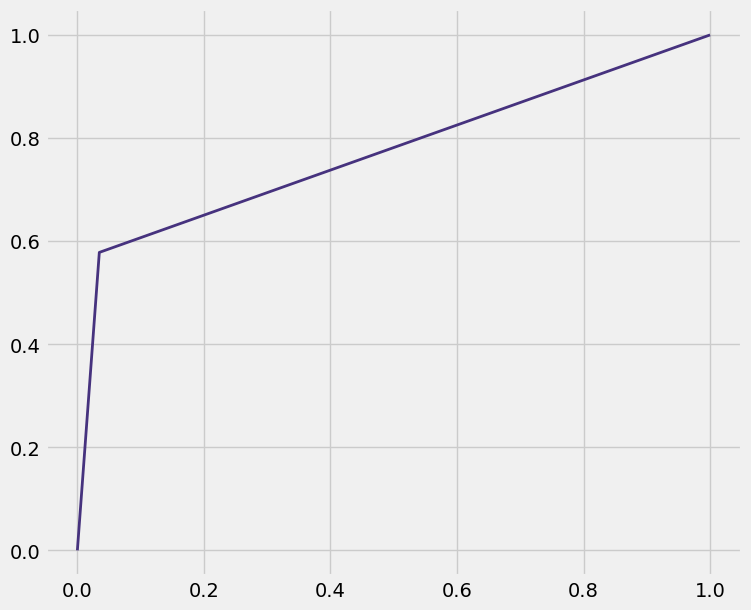

In [24]:
# 5. 計算 FPR、TPR 和閾值
fpr, tpr, thresholds = roc_curve(y_valid, pred_val)

# 6. 計算 AUC 分數
roc_auc = auc(fpr, tpr) # 或 roc_auc_score(y_test, y_pred_proba)

# 7. 使用 Matplotlib 繪製 ROC 曲線 (帶有 Seaborn 風格)
plt.figure(figsize=(8, 7))

# 繪製 ROC 曲線
plt.plot(fpr, tpr, color=sns.color_palette("viridis")[0],
         lw=2, label=f'ROC 曲線 (AUC = {roc_auc:.2f})')

<h2 align="center"><font color='green'>catboost 訓練及驗證找尋最佳參數</font></h2>

In [14]:
cat_optimizer = CatBoostOptimizer(
        X=X_train,
        y=y_train,
        model_type='classifier',
        categorical_features=category_cols
    )

    
cat_optimizer.optimize(n_trials=100, n_splits=5, metric='roc_auc', direction='maximize') # Fewer trials for quick demo

cat_optimizer.train_best_model()

[I 2025-07-14 11:38:32,095] A new study created in memory with name: no-name-9b9985b4-af2e-467f-a210-809b876dbf62


Starting Optuna optimization for CatBoost (classifier)...
Optimizing for metric: 'roc_auc' with direction: 'maximize'
Using 5-fold cross-validation.


[I 2025-07-14 11:38:42,566] Trial 0 finished with value: -0.921305150467291 and parameters: {'iterations': 624, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.15601864044243652, 'border_count': 66, 'bagging_temperature': 0.05808361216819946, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.921305150467291.


Trial 0: Value = -0.921305150467291, Params = {'iterations': 624, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.15601864044243652, 'border_count': 66, 'bagging_temperature': 0.05808361216819946, 'grow_policy': 'SymmetricTree'}
Trial 0 finished with roc_auc = 0.9213 and params: {'iterations': 624, 'learning_rate': 0.17254716573280354, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 0.15601864044243652, 'border_count': 66, 'bagging_temperature': 0.05808361216819946, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:38:52,696] Trial 1 finished with value: -0.9279544747694188 and parameters: {'iterations': 128, 'learning_rate': 0.18276027831785724, 'depth': 9, 'l2_leaf_reg': 0.0070689749506246055, 'random_strength': 0.18182496720710062, 'border_count': 73, 'bagging_temperature': 0.3042422429595377, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.921305150467291.


Trial 1 finished with roc_auc = 0.9280 and params: {'iterations': 128, 'learning_rate': 0.18276027831785724, 'depth': 9, 'l2_leaf_reg': 0.0070689749506246055, 'random_strength': 0.18182496720710062, 'border_count': 73, 'bagging_temperature': 0.3042422429595377, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:39:09,312] Trial 2 finished with value: -0.9311809915147983 and parameters: {'iterations': 957, 'learning_rate': 0.01518747922672247, 'depth': 6, 'l2_leaf_reg': 0.029204338471814112, 'random_strength': 0.45606998421703593, 'border_count': 207, 'bagging_temperature': 0.19967378215835974, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.921305150467291.


Trial 2 finished with roc_auc = 0.9312 and params: {'iterations': 957, 'learning_rate': 0.01518747922672247, 'depth': 6, 'l2_leaf_reg': 0.029204338471814112, 'random_strength': 0.45606998421703593, 'border_count': 207, 'bagging_temperature': 0.19967378215835974, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:39:21,510] Trial 3 finished with value: -0.931090375779338 and parameters: {'iterations': 951, 'learning_rate': 0.016666983286066417, 'depth': 4, 'l2_leaf_reg': 6.245139574743075, 'random_strength': 0.9656320330745594, 'border_count': 213, 'bagging_temperature': 0.3046137691733707, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.921305150467291.


Trial 3 finished with roc_auc = 0.9311 and params: {'iterations': 951, 'learning_rate': 0.016666983286066417, 'depth': 4, 'l2_leaf_reg': 6.245139574743075, 'random_strength': 0.9656320330745594, 'border_count': 213, 'bagging_temperature': 0.3046137691733707, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:39:27,972] Trial 4 finished with value: -0.9309658875851012 and parameters: {'iterations': 270, 'learning_rate': 0.04407984038169244, 'depth': 4, 'l2_leaf_reg': 4.337920697490942, 'random_strength': 0.2587799816000169, 'border_count': 180, 'bagging_temperature': 0.31171107608941095, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.921305150467291.


Trial 4 finished with roc_auc = 0.9310 and params: {'iterations': 270, 'learning_rate': 0.04407984038169244, 'depth': 4, 'l2_leaf_reg': 4.337920697490942, 'random_strength': 0.2587799816000169, 'border_count': 180, 'bagging_temperature': 0.31171107608941095, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:39:53,686] Trial 5 finished with value: -0.9300804232810416 and parameters: {'iterations': 1458, 'learning_rate': 0.10196967939171485, 'depth': 10, 'l2_leaf_reg': 3.7958531426706403, 'random_strength': 0.5978999788110851, 'border_count': 238, 'bagging_temperature': 0.0884925020519195, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 39, 'max_leaves': 19}. Best is trial 0 with value: -0.921305150467291.


Trial 5 finished with roc_auc = 0.9301 and params: {'iterations': 1458, 'learning_rate': 0.10196967939171485, 'depth': 10, 'l2_leaf_reg': 3.7958531426706403, 'random_strength': 0.5978999788110851, 'border_count': 238, 'bagging_temperature': 0.0884925020519195, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 39, 'max_leaves': 19}


[I 2025-07-14 11:40:04,936] Trial 6 finished with value: -0.9297522203082865 and parameters: {'iterations': 1261, 'learning_rate': 0.02911701023242742, 'depth': 5, 'l2_leaf_reg': 0.14817820606039092, 'random_strength': 0.14092422497476265, 'border_count': 211, 'bagging_temperature': 0.07455064367977082, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.921305150467291.


Trial 6 finished with roc_auc = 0.9298 and params: {'iterations': 1261, 'learning_rate': 0.02911701023242742, 'depth': 5, 'l2_leaf_reg': 0.14817820606039092, 'random_strength': 0.14092422497476265, 'border_count': 211, 'bagging_temperature': 0.07455064367977082, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:40:14,254] Trial 7 finished with value: -0.9322058252205311 and parameters: {'iterations': 107, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 0.8241925264876453, 'random_strength': 0.7712703466859457, 'border_count': 48, 'bagging_temperature': 0.3584657285442726, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: -0.921305150467291.


Trial 7 finished with roc_auc = 0.9322 and params: {'iterations': 107, 'learning_rate': 0.11506408247250169, 'depth': 8, 'l2_leaf_reg': 0.8241925264876453, 'random_strength': 0.7712703466859457, 'border_count': 48, 'bagging_temperature': 0.3584657285442726, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:41:07,971] Trial 8 finished with value: -0.9316132850317761 and parameters: {'iterations': 563, 'learning_rate': 0.012097379927033842, 'depth': 6, 'l2_leaf_reg': 0.01998634077852888, 'random_strength': 0.7296061783380641, 'border_count': 174, 'bagging_temperature': 0.8872127425763265, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 77, 'max_leaves': 37}. Best is trial 0 with value: -0.921305150467291.


Trial 8 finished with roc_auc = 0.9316 and params: {'iterations': 563, 'learning_rate': 0.012097379927033842, 'depth': 6, 'l2_leaf_reg': 0.01998634077852888, 'random_strength': 0.7296061783380641, 'border_count': 174, 'bagging_temperature': 0.8872127425763265, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 77, 'max_leaves': 37}


[I 2025-07-14 11:41:24,831] Trial 9 finished with value: -0.9303089480520965 and parameters: {'iterations': 1180, 'learning_rate': 0.043897812845882046, 'depth': 7, 'l2_leaf_reg': 0.05130551760589835, 'random_strength': 0.02541912674409519, 'border_count': 56, 'bagging_temperature': 0.03142918568673425, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: -0.921305150467291.


Trial 9 finished with roc_auc = 0.9303 and params: {'iterations': 1180, 'learning_rate': 0.043897812845882046, 'depth': 7, 'l2_leaf_reg': 0.05130551760589835, 'random_strength': 0.02541912674409519, 'border_count': 56, 'bagging_temperature': 0.03142918568673425, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:41:42,056] Trial 10 finished with value: -0.9155420971398996 and parameters: {'iterations': 536, 'learning_rate': 0.08686415562219908, 'depth': 10, 'l2_leaf_reg': 0.0011799062523159302, 'random_strength': 0.37268383710203, 'border_count': 109, 'bagging_temperature': 0.6543765227707533, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 10: Value = -0.9155420971398996, Params = {'iterations': 536, 'learning_rate': 0.08686415562219908, 'depth': 10, 'l2_leaf_reg': 0.0011799062523159302, 'random_strength': 0.37268383710203, 'border_count': 109, 'bagging_temperature': 0.6543765227707533, 'grow_policy': 'SymmetricTree'}
Trial 10 finished with roc_auc = 0.9155 and params: {'iterations': 536, 'learning_rate': 0.08686415562219908, 'depth': 10, 'l2_leaf_reg': 0.0011799062523159302, 'random_strength': 0.37268383710203, 'border_count': 109, 'bagging_temperature': 0.6543765227707533, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:41:58,645] Trial 11 finished with value: -0.9176178855866356 and parameters: {'iterations': 569, 'learning_rate': 0.09134562731480685, 'depth': 10, 'l2_leaf_reg': 0.001171506226182121, 'random_strength': 0.3941087118085442, 'border_count': 114, 'bagging_temperature': 0.6760934721865332, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 11 finished with roc_auc = 0.9176 and params: {'iterations': 569, 'learning_rate': 0.09134562731480685, 'depth': 10, 'l2_leaf_reg': 0.001171506226182121, 'random_strength': 0.3941087118085442, 'border_count': 114, 'bagging_temperature': 0.6760934721865332, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:42:10,922] Trial 12 finished with value: -0.9167652419856214 and parameters: {'iterations': 543, 'learning_rate': 0.07986043226213188, 'depth': 10, 'l2_leaf_reg': 0.0010341010550788958, 'random_strength': 0.4070701506559134, 'border_count': 109, 'bagging_temperature': 0.707378033653727, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 12 finished with roc_auc = 0.9168 and params: {'iterations': 543, 'learning_rate': 0.07986043226213188, 'depth': 10, 'l2_leaf_reg': 0.0010341010550788958, 'random_strength': 0.4070701506559134, 'border_count': 109, 'bagging_temperature': 0.707378033653727, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:42:22,096] Trial 13 finished with value: -0.918564452759807 and parameters: {'iterations': 424, 'learning_rate': 0.06456329616126276, 'depth': 9, 'l2_leaf_reg': 0.0010936136167179994, 'random_strength': 0.356034082944199, 'border_count': 115, 'bagging_temperature': 0.6550599414250127, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 13 finished with roc_auc = 0.9186 and params: {'iterations': 424, 'learning_rate': 0.06456329616126276, 'depth': 9, 'l2_leaf_reg': 0.0010936136167179994, 'random_strength': 0.356034082944199, 'border_count': 115, 'bagging_temperature': 0.6550599414250127, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:42:34,808] Trial 14 finished with value: -0.9203174645954351 and parameters: {'iterations': 786, 'learning_rate': 0.06635198198434648, 'depth': 10, 'l2_leaf_reg': 0.004346338963924686, 'random_strength': 0.5785605379482188, 'border_count': 130, 'bagging_temperature': 0.9839009658202558, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 14 finished with roc_auc = 0.9203 and params: {'iterations': 786, 'learning_rate': 0.06635198198434648, 'depth': 10, 'l2_leaf_reg': 0.004346338963924686, 'random_strength': 0.5785605379482188, 'border_count': 130, 'bagging_temperature': 0.9839009658202558, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:42:52,503] Trial 15 finished with value: -0.9269523244158732 and parameters: {'iterations': 369, 'learning_rate': 0.026855382162401697, 'depth': 8, 'l2_leaf_reg': 0.0045943610934533665, 'random_strength': 0.3208501786198173, 'border_count': 86, 'bagging_temperature': 0.5895985018457593, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 15 finished with roc_auc = 0.9270 and params: {'iterations': 369, 'learning_rate': 0.026855382162401697, 'depth': 8, 'l2_leaf_reg': 0.0045943610934533665, 'random_strength': 0.3208501786198173, 'border_count': 86, 'bagging_temperature': 0.5895985018457593, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:44:03,269] Trial 16 finished with value: -0.9261062538824071 and parameters: {'iterations': 744, 'learning_rate': 0.0681107800180524, 'depth': 8, 'l2_leaf_reg': 0.002342269129758328, 'random_strength': 0.5398325044348642, 'border_count': 159, 'bagging_temperature': 0.8031146108656748, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 63}. Best is trial 10 with value: -0.9155420971398996.


Trial 16 finished with roc_auc = 0.9261 and params: {'iterations': 744, 'learning_rate': 0.0681107800180524, 'depth': 8, 'l2_leaf_reg': 0.002342269129758328, 'random_strength': 0.5398325044348642, 'border_count': 159, 'bagging_temperature': 0.8031146108656748, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 63}


[I 2025-07-14 11:44:10,062] Trial 17 finished with value: -0.9168936864369476 and parameters: {'iterations': 457, 'learning_rate': 0.1313500593626569, 'depth': 10, 'l2_leaf_reg': 0.011116574846476358, 'random_strength': 0.666535639307719, 'border_count': 93, 'bagging_temperature': 0.4757062957543501, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 17 finished with roc_auc = 0.9169 and params: {'iterations': 457, 'learning_rate': 0.1313500593626569, 'depth': 10, 'l2_leaf_reg': 0.011116574846476358, 'random_strength': 0.666535639307719, 'border_count': 93, 'bagging_temperature': 0.4757062957543501, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:44:21,999] Trial 18 finished with value: -0.9253212996084612 and parameters: {'iterations': 933, 'learning_rate': 0.031249103677874927, 'depth': 9, 'l2_leaf_reg': 0.00213019625999941, 'random_strength': 0.42576536732452697, 'border_count': 143, 'bagging_temperature': 0.7299028405705871, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 18 finished with roc_auc = 0.9253 and params: {'iterations': 933, 'learning_rate': 0.031249103677874927, 'depth': 9, 'l2_leaf_reg': 0.00213019625999941, 'random_strength': 0.42576536732452697, 'border_count': 143, 'bagging_temperature': 0.7299028405705871, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:44:27,215] Trial 19 finished with value: -0.9285758047424576 and parameters: {'iterations': 267, 'learning_rate': 0.07518902806747249, 'depth': 7, 'l2_leaf_reg': 0.42089652261525795, 'random_strength': 0.8668414621384055, 'border_count': 100, 'bagging_temperature': 0.5431215183126172, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 98, 'max_leaves': 4}. Best is trial 10 with value: -0.9155420971398996.


Trial 19 finished with roc_auc = 0.9286 and params: {'iterations': 267, 'learning_rate': 0.07518902806747249, 'depth': 7, 'l2_leaf_reg': 0.42089652261525795, 'random_strength': 0.8668414621384055, 'border_count': 100, 'bagging_temperature': 0.5431215183126172, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 98, 'max_leaves': 4}


[I 2025-07-14 11:44:38,590] Trial 20 finished with value: -0.9319907087119654 and parameters: {'iterations': 665, 'learning_rate': 0.05313118047012972, 'depth': 7, 'l2_leaf_reg': 0.08268233056202173, 'random_strength': 0.4817863041534361, 'border_count': 41, 'bagging_temperature': 0.44414001934246317, 'grow_policy': 'SymmetricTree'}. Best is trial 10 with value: -0.9155420971398996.


Trial 20: Value = -0.9319907087119654, Params = {'iterations': 665, 'learning_rate': 0.05313118047012972, 'depth': 7, 'l2_leaf_reg': 0.08268233056202173, 'random_strength': 0.4817863041534361, 'border_count': 41, 'bagging_temperature': 0.44414001934246317, 'grow_policy': 'SymmetricTree'}
Trial 20 finished with roc_auc = 0.9320 and params: {'iterations': 665, 'learning_rate': 0.05313118047012972, 'depth': 7, 'l2_leaf_reg': 0.08268233056202173, 'random_strength': 0.4817863041534361, 'border_count': 41, 'bagging_temperature': 0.44414001934246317, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:44:44,970] Trial 21 finished with value: -0.9124497579695816 and parameters: {'iterations': 451, 'learning_rate': 0.143188757757776, 'depth': 10, 'l2_leaf_reg': 0.011624257032688552, 'random_strength': 0.6980966400054016, 'border_count': 94, 'bagging_temperature': 0.46289398934847636, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9124497579695816.


Trial 21 finished with roc_auc = 0.9124 and params: {'iterations': 451, 'learning_rate': 0.143188757757776, 'depth': 10, 'l2_leaf_reg': 0.011624257032688552, 'random_strength': 0.6980966400054016, 'border_count': 94, 'bagging_temperature': 0.46289398934847636, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:44:52,982] Trial 22 finished with value: -0.9165674116830325 and parameters: {'iterations': 491, 'learning_rate': 0.14125697817536315, 'depth': 10, 'l2_leaf_reg': 0.01538683697040524, 'random_strength': 0.6595066510692109, 'border_count': 124, 'bagging_temperature': 0.7745835860553127, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9124497579695816.


Trial 22 finished with roc_auc = 0.9166 and params: {'iterations': 491, 'learning_rate': 0.14125697817536315, 'depth': 10, 'l2_leaf_reg': 0.01538683697040524, 'random_strength': 0.6595066510692109, 'border_count': 124, 'bagging_temperature': 0.7745835860553127, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:45:00,305] Trial 23 finished with value: -0.9174977870118036 and parameters: {'iterations': 305, 'learning_rate': 0.14704280451935, 'depth': 9, 'l2_leaf_reg': 0.01699855863021108, 'random_strength': 0.6610112965258029, 'border_count': 145, 'bagging_temperature': 0.8812229050467583, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9124497579695816.


Trial 23 finished with roc_auc = 0.9175 and params: {'iterations': 305, 'learning_rate': 0.14704280451935, 'depth': 9, 'l2_leaf_reg': 0.01699855863021108, 'random_strength': 0.6610112965258029, 'border_count': 145, 'bagging_temperature': 0.8812229050467583, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:45:07,500] Trial 24 finished with value: -0.9189487298945854 and parameters: {'iterations': 456, 'learning_rate': 0.13903682636038625, 'depth': 10, 'l2_leaf_reg': 0.043130014949304823, 'random_strength': 0.8007413169002369, 'border_count': 129, 'bagging_temperature': 0.581674483127964, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9124497579695816.


Trial 24 finished with roc_auc = 0.9189 and params: {'iterations': 456, 'learning_rate': 0.13903682636038625, 'depth': 10, 'l2_leaf_reg': 0.043130014949304823, 'random_strength': 0.8007413169002369, 'border_count': 129, 'bagging_temperature': 0.581674483127964, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:45:14,187] Trial 25 finished with value: -0.9242375606837088 and parameters: {'iterations': 685, 'learning_rate': 0.11116719146017538, 'depth': 8, 'l2_leaf_reg': 0.009445898701407905, 'random_strength': 0.6614488005879375, 'border_count': 75, 'bagging_temperature': 0.8024306718823785, 'grow_policy': 'SymmetricTree'}. Best is trial 21 with value: -0.9124497579695816.


Trial 25 finished with roc_auc = 0.9242 and params: {'iterations': 685, 'learning_rate': 0.11116719146017538, 'depth': 8, 'l2_leaf_reg': 0.009445898701407905, 'random_strength': 0.6614488005879375, 'border_count': 75, 'bagging_temperature': 0.8024306718823785, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:45:21,833] Trial 26 finished with value: -0.9116680303783411 and parameters: {'iterations': 883, 'learning_rate': 0.19713640890017867, 'depth': 9, 'l2_leaf_reg': 0.004387928137388575, 'random_strength': 0.8838467474780209, 'border_count': 130, 'bagging_temperature': 0.6192070590788968, 'grow_policy': 'SymmetricTree'}. Best is trial 26 with value: -0.9116680303783411.


Trial 26 finished with roc_auc = 0.9117 and params: {'iterations': 883, 'learning_rate': 0.19713640890017867, 'depth': 9, 'l2_leaf_reg': 0.004387928137388575, 'random_strength': 0.8838467474780209, 'border_count': 130, 'bagging_temperature': 0.6192070590788968, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:45:30,865] Trial 27 finished with value: -0.9102313312383918 and parameters: {'iterations': 1042, 'learning_rate': 0.1942088616138542, 'depth': 9, 'l2_leaf_reg': 0.0028977394671675363, 'random_strength': 0.9527549098111172, 'border_count': 32, 'bagging_temperature': 0.4094668782891809, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 27 finished with roc_auc = 0.9102 and params: {'iterations': 1042, 'learning_rate': 0.1942088616138542, 'depth': 9, 'l2_leaf_reg': 0.0028977394671675363, 'random_strength': 0.9527549098111172, 'border_count': 32, 'bagging_temperature': 0.4094668782891809, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:45:49,215] Trial 28 finished with value: -0.9188056582478167 and parameters: {'iterations': 1124, 'learning_rate': 0.19466669948965803, 'depth': 9, 'l2_leaf_reg': 0.0034629727303171357, 'random_strength': 0.9448212505560828, 'border_count': 33, 'bagging_temperature': 0.4226683479068027, 'grow_policy': 'Depthwise'}. Best is trial 27 with value: -0.9102313312383918.


Trial 28 finished with roc_auc = 0.9188 and params: {'iterations': 1124, 'learning_rate': 0.19466669948965803, 'depth': 9, 'l2_leaf_reg': 0.0034629727303171357, 'random_strength': 0.9448212505560828, 'border_count': 33, 'bagging_temperature': 0.4226683479068027, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:47:05,960] Trial 29 finished with value: -0.9244229330370498 and parameters: {'iterations': 1072, 'learning_rate': 0.16537463645822376, 'depth': 9, 'l2_leaf_reg': 0.006221711672485755, 'random_strength': 0.8641287606189737, 'border_count': 62, 'bagging_temperature': 0.2135854565022826, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 61}. Best is trial 27 with value: -0.9102313312383918.


Trial 29 finished with roc_auc = 0.9244 and params: {'iterations': 1072, 'learning_rate': 0.16537463645822376, 'depth': 9, 'l2_leaf_reg': 0.006221711672485755, 'random_strength': 0.8641287606189737, 'border_count': 62, 'bagging_temperature': 0.2135854565022826, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_leaves': 61}


[I 2025-07-14 11:47:13,793] Trial 30 finished with value: -0.9180032984715263 and parameters: {'iterations': 861, 'learning_rate': 0.19692164017210886, 'depth': 8, 'l2_leaf_reg': 0.002738268316775086, 'random_strength': 0.8782486275581312, 'border_count': 86, 'bagging_temperature': 0.5236770753137914, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 30: Value = -0.9180032984715263, Params = {'iterations': 861, 'learning_rate': 0.19692164017210886, 'depth': 8, 'l2_leaf_reg': 0.002738268316775086, 'random_strength': 0.8782486275581312, 'border_count': 86, 'bagging_temperature': 0.5236770753137914, 'grow_policy': 'SymmetricTree'}
Trial 30 finished with roc_auc = 0.9180 and params: {'iterations': 861, 'learning_rate': 0.19692164017210886, 'depth': 8, 'l2_leaf_reg': 0.002738268316775086, 'random_strength': 0.8782486275581312, 'border_count': 86, 'bagging_temperature': 0.5236770753137914, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:47:28,666] Trial 31 finished with value: -0.9153810324358871 and parameters: {'iterations': 859, 'learning_rate': 0.15857132261866222, 'depth': 10, 'l2_leaf_reg': 0.0015848148774536652, 'random_strength': 0.9700264553126503, 'border_count': 148, 'bagging_temperature': 0.6080890729476631, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 31 finished with roc_auc = 0.9154 and params: {'iterations': 859, 'learning_rate': 0.15857132261866222, 'depth': 10, 'l2_leaf_reg': 0.0015848148774536652, 'random_strength': 0.9700264553126503, 'border_count': 148, 'bagging_temperature': 0.6080890729476631, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:47:37,550] Trial 32 finished with value: -0.9149451531297913 and parameters: {'iterations': 1312, 'learning_rate': 0.15815107723928257, 'depth': 9, 'l2_leaf_reg': 0.0019511642812952434, 'random_strength': 0.964790966883834, 'border_count': 160, 'bagging_temperature': 0.6021332312878078, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 32 finished with roc_auc = 0.9149 and params: {'iterations': 1312, 'learning_rate': 0.15815107723928257, 'depth': 9, 'l2_leaf_reg': 0.0019511642812952434, 'random_strength': 0.964790966883834, 'border_count': 160, 'bagging_temperature': 0.6021332312878078, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:47:48,008] Trial 33 finished with value: -0.9229746978571969 and parameters: {'iterations': 1375, 'learning_rate': 0.1219985430126305, 'depth': 9, 'l2_leaf_reg': 0.007141500191011557, 'random_strength': 0.9982835861660037, 'border_count': 178, 'bagging_temperature': 0.4088111910944383, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 33 finished with roc_auc = 0.9230 and params: {'iterations': 1375, 'learning_rate': 0.1219985430126305, 'depth': 9, 'l2_leaf_reg': 0.007141500191011557, 'random_strength': 0.9982835861660037, 'border_count': 178, 'bagging_temperature': 0.4088111910944383, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:47:57,659] Trial 34 finished with value: -0.9157917937700484 and parameters: {'iterations': 1037, 'learning_rate': 0.1747503856731933, 'depth': 9, 'l2_leaf_reg': 0.0037517755410738933, 'random_strength': 0.9062394816948898, 'border_count': 161, 'bagging_temperature': 0.5037216231645234, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 34 finished with roc_auc = 0.9158 and params: {'iterations': 1037, 'learning_rate': 0.1747503856731933, 'depth': 9, 'l2_leaf_reg': 0.0037517755410738933, 'random_strength': 0.9062394816948898, 'border_count': 161, 'bagging_temperature': 0.5037216231645234, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:48:07,182] Trial 35 finished with value: -0.9247682870943859 and parameters: {'iterations': 1259, 'learning_rate': 0.1969602504442008, 'depth': 8, 'l2_leaf_reg': 0.03533817693391094, 'random_strength': 0.8178946074782627, 'border_count': 75, 'bagging_temperature': 0.2555471701896459, 'grow_policy': 'Depthwise'}. Best is trial 27 with value: -0.9102313312383918.


Trial 35 finished with roc_auc = 0.9248 and params: {'iterations': 1259, 'learning_rate': 0.1969602504442008, 'depth': 8, 'l2_leaf_reg': 0.03533817693391094, 'random_strength': 0.8178946074782627, 'border_count': 75, 'bagging_temperature': 0.2555471701896459, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:48:15,553] Trial 36 finished with value: -0.9252871033452585 and parameters: {'iterations': 1495, 'learning_rate': 0.16319574248269783, 'depth': 6, 'l2_leaf_reg': 0.006922579701744695, 'random_strength': 0.7419947382199905, 'border_count': 187, 'bagging_temperature': 0.37062289059745473, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 36 finished with roc_auc = 0.9253 and params: {'iterations': 1495, 'learning_rate': 0.16319574248269783, 'depth': 6, 'l2_leaf_reg': 0.006922579701744695, 'random_strength': 0.7419947382199905, 'border_count': 187, 'bagging_temperature': 0.37062289059745473, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:48:28,182] Trial 37 finished with value: -0.9232480938875073 and parameters: {'iterations': 1353, 'learning_rate': 0.09991134663948734, 'depth': 9, 'l2_leaf_reg': 0.002273395139024154, 'random_strength': 0.9007110499691342, 'border_count': 196, 'bagging_temperature': 0.1260523952703016, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 37 finished with roc_auc = 0.9232 and params: {'iterations': 1353, 'learning_rate': 0.09991134663948734, 'depth': 9, 'l2_leaf_reg': 0.002273395139024154, 'random_strength': 0.9007110499691342, 'border_count': 196, 'bagging_temperature': 0.1260523952703016, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:48:42,421] Trial 38 finished with value: -0.9206409841713359 and parameters: {'iterations': 1193, 'learning_rate': 0.12259413102667056, 'depth': 9, 'l2_leaf_reg': 0.011726061992966554, 'random_strength': 0.8360595409229381, 'border_count': 244, 'bagging_temperature': 0.34719310910685397, 'grow_policy': 'Depthwise'}. Best is trial 27 with value: -0.9102313312383918.


Trial 38 finished with roc_auc = 0.9206 and params: {'iterations': 1193, 'learning_rate': 0.12259413102667056, 'depth': 9, 'l2_leaf_reg': 0.011726061992966554, 'random_strength': 0.8360595409229381, 'border_count': 244, 'bagging_temperature': 0.34719310910685397, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:48:52,736] Trial 39 finished with value: -0.921733974245359 and parameters: {'iterations': 985, 'learning_rate': 0.1648389869140849, 'depth': 8, 'l2_leaf_reg': 0.026771833699627174, 'random_strength': 0.9470310028946092, 'border_count': 230, 'bagging_temperature': 0.47223205188631523, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 39 finished with roc_auc = 0.9217 and params: {'iterations': 985, 'learning_rate': 0.1648389869140849, 'depth': 8, 'l2_leaf_reg': 0.026771833699627174, 'random_strength': 0.9470310028946092, 'border_count': 230, 'bagging_temperature': 0.47223205188631523, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:49:35,623] Trial 40 finished with value: -0.9317604663166786 and parameters: {'iterations': 895, 'learning_rate': 0.02124856122795868, 'depth': 5, 'l2_leaf_reg': 0.0752696902336102, 'random_strength': 0.7400380830038552, 'border_count': 164, 'bagging_temperature': 0.2767771020290799, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 48, 'max_leaves': 40}. Best is trial 27 with value: -0.9102313312383918.


Trial 40: Value = -0.9317604663166786, Params = {'iterations': 895, 'learning_rate': 0.02124856122795868, 'depth': 5, 'l2_leaf_reg': 0.0752696902336102, 'random_strength': 0.7400380830038552, 'border_count': 164, 'bagging_temperature': 0.2767771020290799, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 48, 'max_leaves': 40}
Trial 40 finished with roc_auc = 0.9318 and params: {'iterations': 895, 'learning_rate': 0.02124856122795868, 'depth': 5, 'l2_leaf_reg': 0.0752696902336102, 'random_strength': 0.7400380830038552, 'border_count': 164, 'bagging_temperature': 0.2767771020290799, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 48, 'max_leaves': 40}


[I 2025-07-14 11:49:52,271] Trial 41 finished with value: -0.9114016740510307 and parameters: {'iterations': 821, 'learning_rate': 0.14962136918290336, 'depth': 10, 'l2_leaf_reg': 0.0017177793966279208, 'random_strength': 0.9853506422609608, 'border_count': 145, 'bagging_temperature': 0.5989339665846571, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 41 finished with roc_auc = 0.9114 and params: {'iterations': 821, 'learning_rate': 0.14962136918290336, 'depth': 10, 'l2_leaf_reg': 0.0017177793966279208, 'random_strength': 0.9853506422609608, 'border_count': 145, 'bagging_temperature': 0.5989339665846571, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:50:03,989] Trial 42 finished with value: -0.913924372254398 and parameters: {'iterations': 788, 'learning_rate': 0.10723090567431132, 'depth': 10, 'l2_leaf_reg': 0.0016911182824451616, 'random_strength': 0.9952682578723787, 'border_count': 132, 'bagging_temperature': 0.5506801250869772, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 42 finished with roc_auc = 0.9139 and params: {'iterations': 788, 'learning_rate': 0.10723090567431132, 'depth': 10, 'l2_leaf_reg': 0.0016911182824451616, 'random_strength': 0.9952682578723787, 'border_count': 132, 'bagging_temperature': 0.5506801250869772, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:50:15,008] Trial 43 finished with value: -0.9164225201580024 and parameters: {'iterations': 747, 'learning_rate': 0.10621867998850722, 'depth': 10, 'l2_leaf_reg': 0.005130159565046248, 'random_strength': 0.9145908770604904, 'border_count': 136, 'bagging_temperature': 0.5211364602449668, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 43 finished with roc_auc = 0.9164 and params: {'iterations': 747, 'learning_rate': 0.10621867998850722, 'depth': 10, 'l2_leaf_reg': 0.005130159565046248, 'random_strength': 0.9145908770604904, 'border_count': 136, 'bagging_temperature': 0.5211364602449668, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:50:30,946] Trial 44 finished with value: -0.9111319620061682 and parameters: {'iterations': 1004, 'learning_rate': 0.13257993385966862, 'depth': 10, 'l2_leaf_reg': 0.0030362793510348026, 'random_strength': 0.9934423516819176, 'border_count': 123, 'bagging_temperature': 0.5632634917806932, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 44 finished with roc_auc = 0.9111 and params: {'iterations': 1004, 'learning_rate': 0.13257993385966862, 'depth': 10, 'l2_leaf_reg': 0.0030362793510348026, 'random_strength': 0.9934423516819176, 'border_count': 123, 'bagging_temperature': 0.5632634917806932, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:50:42,101] Trial 45 finished with value: -0.9156111522886464 and parameters: {'iterations': 1050, 'learning_rate': 0.13522462035807875, 'depth': 10, 'l2_leaf_reg': 0.003229007718669152, 'random_strength': 0.7988773364701959, 'border_count': 121, 'bagging_temperature': 0.6428216916617175, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 45 finished with roc_auc = 0.9156 and params: {'iterations': 1050, 'learning_rate': 0.13522462035807875, 'depth': 10, 'l2_leaf_reg': 0.003229007718669152, 'random_strength': 0.7988773364701959, 'border_count': 121, 'bagging_temperature': 0.6428216916617175, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:50:56,290] Trial 46 finished with value: -0.9290783005198531 and parameters: {'iterations': 990, 'learning_rate': 0.09354138570102953, 'depth': 10, 'l2_leaf_reg': 1.936595254019557, 'random_strength': 0.9319883364301463, 'border_count': 101, 'bagging_temperature': 0.39269443770365986, 'grow_policy': 'Depthwise'}. Best is trial 27 with value: -0.9102313312383918.


Trial 46 finished with roc_auc = 0.9291 and params: {'iterations': 990, 'learning_rate': 0.09354138570102953, 'depth': 10, 'l2_leaf_reg': 1.936595254019557, 'random_strength': 0.9319883364301463, 'border_count': 101, 'bagging_temperature': 0.39269443770365986, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:51:05,182] Trial 47 finished with value: -0.9166589813836638 and parameters: {'iterations': 1103, 'learning_rate': 0.17803862269673185, 'depth': 10, 'l2_leaf_reg': 0.023045829255392673, 'random_strength': 0.8419148659445057, 'border_count': 54, 'bagging_temperature': 0.4671044976084687, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 47 finished with roc_auc = 0.9167 and params: {'iterations': 1103, 'learning_rate': 0.17803862269673185, 'depth': 10, 'l2_leaf_reg': 0.023045829255392673, 'random_strength': 0.8419148659445057, 'border_count': 54, 'bagging_temperature': 0.4671044976084687, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:51:17,191] Trial 48 finished with value: -0.9169429631406363 and parameters: {'iterations': 919, 'learning_rate': 0.1275160281838078, 'depth': 10, 'l2_leaf_reg': 0.007442835961923264, 'random_strength': 0.7006465166308257, 'border_count': 152, 'bagging_temperature': 0.7110135529756204, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 48 finished with roc_auc = 0.9169 and params: {'iterations': 919, 'learning_rate': 0.1275160281838078, 'depth': 10, 'l2_leaf_reg': 0.007442835961923264, 'random_strength': 0.7006465166308257, 'border_count': 152, 'bagging_temperature': 0.7110135529756204, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:51:35,582] Trial 49 finished with value: -0.9269377033069798 and parameters: {'iterations': 643, 'learning_rate': 0.03742803753298325, 'depth': 9, 'l2_leaf_reg': 0.0015296613208956701, 'random_strength': 0.781570918426907, 'border_count': 105, 'bagging_temperature': 0.5703602195687719, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 49 finished with roc_auc = 0.9269 and params: {'iterations': 643, 'learning_rate': 0.03742803753298325, 'depth': 9, 'l2_leaf_reg': 0.0015296613208956701, 'random_strength': 0.781570918426907, 'border_count': 105, 'bagging_temperature': 0.5703602195687719, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:51:48,759] Trial 50 finished with value: -0.9233384341051663 and parameters: {'iterations': 203, 'learning_rate': 0.053063094125255804, 'depth': 9, 'l2_leaf_reg': 0.00464067477146649, 'random_strength': 0.5960211575875922, 'border_count': 119, 'bagging_temperature': 0.32748298941163284, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 50: Value = -0.9233384341051663, Params = {'iterations': 203, 'learning_rate': 0.053063094125255804, 'depth': 9, 'l2_leaf_reg': 0.00464067477146649, 'random_strength': 0.5960211575875922, 'border_count': 119, 'bagging_temperature': 0.32748298941163284, 'grow_policy': 'SymmetricTree'}
Trial 50 finished with roc_auc = 0.9233 and params: {'iterations': 203, 'learning_rate': 0.053063094125255804, 'depth': 9, 'l2_leaf_reg': 0.00464067477146649, 'random_strength': 0.5960211575875922, 'border_count': 119, 'bagging_temperature': 0.32748298941163284, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:51:58,524] Trial 51 finished with value: -0.9138961221441587 and parameters: {'iterations': 839, 'learning_rate': 0.146645679578088, 'depth': 10, 'l2_leaf_reg': 0.0013650304137357418, 'random_strength': 0.9972578930984142, 'border_count': 136, 'bagging_temperature': 0.6198576847335584, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 51 finished with roc_auc = 0.9139 and params: {'iterations': 839, 'learning_rate': 0.146645679578088, 'depth': 10, 'l2_leaf_reg': 0.0013650304137357418, 'random_strength': 0.9972578930984142, 'border_count': 136, 'bagging_temperature': 0.6198576847335584, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:52:11,163] Trial 52 finished with value: -0.9217525909710277 and parameters: {'iterations': 846, 'learning_rate': 0.14763510365572577, 'depth': 10, 'l2_leaf_reg': 0.18078398472876975, 'random_strength': 0.9843924534297327, 'border_count': 141, 'bagging_temperature': 0.6277029871928619, 'grow_policy': 'SymmetricTree'}. Best is trial 27 with value: -0.9102313312383918.


Trial 52 finished with roc_auc = 0.9218 and params: {'iterations': 846, 'learning_rate': 0.14763510365572577, 'depth': 10, 'l2_leaf_reg': 0.18078398472876975, 'random_strength': 0.9843924534297327, 'border_count': 141, 'bagging_temperature': 0.6277029871928619, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:52:21,610] Trial 53 finished with value: -0.9075438977359724 and parameters: {'iterations': 726, 'learning_rate': 0.18015981021082297, 'depth': 10, 'l2_leaf_reg': 0.0012018242116595217, 'random_strength': 0.8960901541288493, 'border_count': 136, 'bagging_temperature': 0.6825447521432734, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 53 finished with roc_auc = 0.9075 and params: {'iterations': 726, 'learning_rate': 0.18015981021082297, 'depth': 10, 'l2_leaf_reg': 0.0012018242116595217, 'random_strength': 0.8960901541288493, 'border_count': 136, 'bagging_temperature': 0.6825447521432734, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:52:37,620] Trial 54 finished with value: -0.9141489874319084 and parameters: {'iterations': 720, 'learning_rate': 0.18191594823557464, 'depth': 10, 'l2_leaf_reg': 0.002985515169746634, 'random_strength': 0.8884473622465544, 'border_count': 110, 'bagging_temperature': 0.6838715411581214, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 54 finished with roc_auc = 0.9141 and params: {'iterations': 720, 'learning_rate': 0.18191594823557464, 'depth': 10, 'l2_leaf_reg': 0.002985515169746634, 'random_strength': 0.8884473622465544, 'border_count': 110, 'bagging_temperature': 0.6838715411581214, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:53:06,332] Trial 55 finished with value: -0.9258579177989272 and parameters: {'iterations': 1015, 'learning_rate': 0.1987240573039189, 'depth': 10, 'l2_leaf_reg': 0.0010367836744976766, 'random_strength': 0.9350606221318083, 'border_count': 92, 'bagging_temperature': 0.7560192946571542, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 25, 'max_leaves': 21}. Best is trial 53 with value: -0.9075438977359724.


Trial 55 finished with roc_auc = 0.9259 and params: {'iterations': 1015, 'learning_rate': 0.1987240573039189, 'depth': 10, 'l2_leaf_reg': 0.0010367836744976766, 'random_strength': 0.9350606221318083, 'border_count': 92, 'bagging_temperature': 0.7560192946571542, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 25, 'max_leaves': 21}


[I 2025-07-14 11:53:16,981] Trial 56 finished with value: -0.9195691034678333 and parameters: {'iterations': 946, 'learning_rate': 0.07957997401137293, 'depth': 10, 'l2_leaf_reg': 0.0023414823269495774, 'random_strength': 0.8379624672438606, 'border_count': 172, 'bagging_temperature': 0.6719259175822254, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 56 finished with roc_auc = 0.9196 and params: {'iterations': 946, 'learning_rate': 0.07957997401137293, 'depth': 10, 'l2_leaf_reg': 0.0023414823269495774, 'random_strength': 0.8379624672438606, 'border_count': 172, 'bagging_temperature': 0.6719259175822254, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:53:28,827] Trial 57 finished with value: -0.915878299461605 and parameters: {'iterations': 607, 'learning_rate': 0.1791206456635549, 'depth': 9, 'l2_leaf_reg': 0.013598351597353895, 'random_strength': 0.004265648596836646, 'border_count': 126, 'bagging_temperature': 0.4951196714345528, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 57 finished with roc_auc = 0.9159 and params: {'iterations': 607, 'learning_rate': 0.1791206456635549, 'depth': 9, 'l2_leaf_reg': 0.013598351597353895, 'random_strength': 0.004265648596836646, 'border_count': 126, 'bagging_temperature': 0.4951196714345528, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:53:41,562] Trial 58 finished with value: -0.9214584446766099 and parameters: {'iterations': 1159, 'learning_rate': 0.11981792258480448, 'depth': 9, 'l2_leaf_reg': 0.009292181622487251, 'random_strength': 0.759849255812308, 'border_count': 116, 'bagging_temperature': 0.5611409022930536, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 58 finished with roc_auc = 0.9215 and params: {'iterations': 1159, 'learning_rate': 0.11981792258480448, 'depth': 9, 'l2_leaf_reg': 0.009292181622487251, 'random_strength': 0.759849255812308, 'border_count': 116, 'bagging_temperature': 0.5611409022930536, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:54:10,862] Trial 59 finished with value: -0.9231823960793923 and parameters: {'iterations': 805, 'learning_rate': 0.010421938634545404, 'depth': 10, 'l2_leaf_reg': 0.003914380874348782, 'random_strength': 0.22224837332234848, 'border_count': 155, 'bagging_temperature': 0.45854181547635287, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 59 finished with roc_auc = 0.9232 and params: {'iterations': 805, 'learning_rate': 0.010421938634545404, 'depth': 10, 'l2_leaf_reg': 0.003914380874348782, 'random_strength': 0.22224837332234848, 'border_count': 155, 'bagging_temperature': 0.45854181547635287, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:54:21,859] Trial 60 finished with value: -0.928790692396767 and parameters: {'iterations': 706, 'learning_rate': 0.15639174178324222, 'depth': 8, 'l2_leaf_reg': 9.470908189824819, 'random_strength': 0.0932559444861254, 'border_count': 67, 'bagging_temperature': 0.8389617580657899, 'grow_policy': 'Depthwise'}. Best is trial 53 with value: -0.9075438977359724.


Trial 60: Value = -0.928790692396767, Params = {'iterations': 706, 'learning_rate': 0.15639174178324222, 'depth': 8, 'l2_leaf_reg': 9.470908189824819, 'random_strength': 0.0932559444861254, 'border_count': 67, 'bagging_temperature': 0.8389617580657899, 'grow_policy': 'Depthwise'}
Trial 60 finished with roc_auc = 0.9288 and params: {'iterations': 706, 'learning_rate': 0.15639174178324222, 'depth': 8, 'l2_leaf_reg': 9.470908189824819, 'random_strength': 0.0932559444861254, 'border_count': 67, 'bagging_temperature': 0.8389617580657899, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:54:38,813] Trial 61 finished with value: -0.91603924162309 and parameters: {'iterations': 821, 'learning_rate': 0.13536314738163255, 'depth': 10, 'l2_leaf_reg': 0.0014103476134615575, 'random_strength': 0.9581602496749356, 'border_count': 138, 'bagging_temperature': 0.624241951338123, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 61 finished with roc_auc = 0.9160 and params: {'iterations': 821, 'learning_rate': 0.13536314738163255, 'depth': 10, 'l2_leaf_reg': 0.0014103476134615575, 'random_strength': 0.9581602496749356, 'border_count': 138, 'bagging_temperature': 0.624241951338123, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:54:56,653] Trial 62 finished with value: -0.9091793166262583 and parameters: {'iterations': 881, 'learning_rate': 0.15197729767257745, 'depth': 10, 'l2_leaf_reg': 0.001517056122730303, 'random_strength': 0.8642313296282776, 'border_count': 133, 'bagging_temperature': 0.7019735243994518, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 62 finished with roc_auc = 0.9092 and params: {'iterations': 881, 'learning_rate': 0.15197729767257745, 'depth': 10, 'l2_leaf_reg': 0.001517056122730303, 'random_strength': 0.8642313296282776, 'border_count': 133, 'bagging_temperature': 0.7019735243994518, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:55:06,264] Trial 63 finished with value: -0.915780323870648 and parameters: {'iterations': 898, 'learning_rate': 0.17445854567122462, 'depth': 10, 'l2_leaf_reg': 0.0026661150085045744, 'random_strength': 0.8635723376437432, 'border_count': 148, 'bagging_temperature': 0.7403750486430816, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 63 finished with roc_auc = 0.9158 and params: {'iterations': 898, 'learning_rate': 0.17445854567122462, 'depth': 10, 'l2_leaf_reg': 0.0026661150085045744, 'random_strength': 0.8635723376437432, 'border_count': 148, 'bagging_temperature': 0.7403750486430816, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:55:17,148] Trial 64 finished with value: -0.91489580703944 and parameters: {'iterations': 755, 'learning_rate': 0.14695997145603112, 'depth': 9, 'l2_leaf_reg': 0.00101637310443477, 'random_strength': 0.9180693841936345, 'border_count': 167, 'bagging_temperature': 0.6995133787603472, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 64 finished with roc_auc = 0.9149 and params: {'iterations': 755, 'learning_rate': 0.14695997145603112, 'depth': 9, 'l2_leaf_reg': 0.00101637310443477, 'random_strength': 0.9180693841936345, 'border_count': 167, 'bagging_temperature': 0.6995133787603472, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:55:26,581] Trial 65 finished with value: -0.9129397706399921 and parameters: {'iterations': 977, 'learning_rate': 0.11964430672160957, 'depth': 10, 'l2_leaf_reg': 0.0018426257124713142, 'random_strength': 0.551985624259327, 'border_count': 41, 'bagging_temperature': 0.6660578421931663, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 65 finished with roc_auc = 0.9129 and params: {'iterations': 977, 'learning_rate': 0.11964430672160957, 'depth': 10, 'l2_leaf_reg': 0.0018426257124713142, 'random_strength': 0.551985624259327, 'border_count': 41, 'bagging_temperature': 0.6660578421931663, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:55:37,242] Trial 66 finished with value: -0.9300117166886886 and parameters: {'iterations': 892, 'learning_rate': 0.13234132242353275, 'depth': 4, 'l2_leaf_reg': 0.005653343982563139, 'random_strength': 0.7010290018240586, 'border_count': 129, 'bagging_temperature': 0.7850353799887351, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 79, 'max_leaves': 48}. Best is trial 53 with value: -0.9075438977359724.


Trial 66 finished with roc_auc = 0.9300 and params: {'iterations': 892, 'learning_rate': 0.13234132242353275, 'depth': 4, 'l2_leaf_reg': 0.005653343982563139, 'random_strength': 0.7010290018240586, 'border_count': 129, 'bagging_temperature': 0.7850353799887351, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 79, 'max_leaves': 48}


[I 2025-07-14 11:55:52,416] Trial 67 finished with value: -0.915489929731031 and parameters: {'iterations': 591, 'learning_rate': 0.18547413496746668, 'depth': 10, 'l2_leaf_reg': 0.003303620970335934, 'random_strength': 0.865695726913485, 'border_count': 111, 'bagging_temperature': 0.5302737541407053, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 67 finished with roc_auc = 0.9155 and params: {'iterations': 591, 'learning_rate': 0.18547413496746668, 'depth': 10, 'l2_leaf_reg': 0.003303620970335934, 'random_strength': 0.865695726913485, 'border_count': 111, 'bagging_temperature': 0.5302737541407053, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:56:16,754] Trial 68 finished with value: -0.9271644142863227 and parameters: {'iterations': 1089, 'learning_rate': 0.016994233519260736, 'depth': 9, 'l2_leaf_reg': 0.0018958376399980951, 'random_strength': 0.8930925536043596, 'border_count': 80, 'bagging_temperature': 0.590700256324203, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 68 finished with roc_auc = 0.9272 and params: {'iterations': 1089, 'learning_rate': 0.016994233519260736, 'depth': 9, 'l2_leaf_reg': 0.0018958376399980951, 'random_strength': 0.8930925536043596, 'border_count': 80, 'bagging_temperature': 0.590700256324203, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:56:30,040] Trial 69 finished with value: -0.9311178496516481 and parameters: {'iterations': 374, 'learning_rate': 0.0950482685252414, 'depth': 7, 'l2_leaf_reg': 0.4254986618535637, 'random_strength': 0.9520247858379032, 'border_count': 99, 'bagging_temperature': 0.43127184034185906, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 69 finished with roc_auc = 0.9311 and params: {'iterations': 374, 'learning_rate': 0.0950482685252414, 'depth': 7, 'l2_leaf_reg': 0.4254986618535637, 'random_strength': 0.9520247858379032, 'border_count': 99, 'bagging_temperature': 0.43127184034185906, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:56:40,822] Trial 70 finished with value: -0.9179260244522819 and parameters: {'iterations': 507, 'learning_rate': 0.1575868975461772, 'depth': 9, 'l2_leaf_reg': 0.008640501223088754, 'random_strength': 0.809885057611135, 'border_count': 152, 'bagging_temperature': 0.7196409745097833, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 70: Value = -0.9179260244522819, Params = {'iterations': 507, 'learning_rate': 0.1575868975461772, 'depth': 9, 'l2_leaf_reg': 0.008640501223088754, 'random_strength': 0.809885057611135, 'border_count': 152, 'bagging_temperature': 0.7196409745097833, 'grow_policy': 'SymmetricTree'}
Trial 70 finished with roc_auc = 0.9179 and params: {'iterations': 507, 'learning_rate': 0.1575868975461772, 'depth': 9, 'l2_leaf_reg': 0.008640501223088754, 'random_strength': 0.809885057611135, 'border_count': 152, 'bagging_temperature': 0.7196409745097833, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:56:51,570] Trial 71 finished with value: -0.917496799773496 and parameters: {'iterations': 972, 'learning_rate': 0.11439064584408616, 'depth': 10, 'l2_leaf_reg': 0.002320029441123558, 'random_strength': 0.5350178439286947, 'border_count': 44, 'bagging_temperature': 0.6435231183944543, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 71 finished with roc_auc = 0.9175 and params: {'iterations': 972, 'learning_rate': 0.11439064584408616, 'depth': 10, 'l2_leaf_reg': 0.002320029441123558, 'random_strength': 0.5350178439286947, 'border_count': 44, 'bagging_temperature': 0.6435231183944543, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:57:00,464] Trial 72 finished with value: -0.9083061893519989 and parameters: {'iterations': 1014, 'learning_rate': 0.168911172853913, 'depth': 10, 'l2_leaf_reg': 0.0017872870623375104, 'random_strength': 0.548923876504115, 'border_count': 34, 'bagging_temperature': 0.680858966006439, 'grow_policy': 'SymmetricTree'}. Best is trial 53 with value: -0.9075438977359724.


Trial 72 finished with roc_auc = 0.9083 and params: {'iterations': 1014, 'learning_rate': 0.168911172853913, 'depth': 10, 'l2_leaf_reg': 0.0017872870623375104, 'random_strength': 0.548923876504115, 'border_count': 34, 'bagging_temperature': 0.680858966006439, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:57:09,173] Trial 73 finished with value: -0.9043215750288779 and parameters: {'iterations': 1031, 'learning_rate': 0.17270667529804393, 'depth': 10, 'l2_leaf_reg': 0.0013206136995948439, 'random_strength': 0.6218666562204263, 'border_count': 33, 'bagging_temperature': 0.4984646472679875, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 73 finished with roc_auc = 0.9043 and params: {'iterations': 1031, 'learning_rate': 0.17270667529804393, 'depth': 10, 'l2_leaf_reg': 0.0013206136995948439, 'random_strength': 0.6218666562204263, 'border_count': 33, 'bagging_temperature': 0.4984646472679875, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:57:19,626] Trial 74 finished with value: -0.9047417173586959 and parameters: {'iterations': 1147, 'learning_rate': 0.19754253629294136, 'depth': 10, 'l2_leaf_reg': 0.0013112524762964625, 'random_strength': 0.6330916799157731, 'border_count': 32, 'bagging_temperature': 0.5791127580360613, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 74 finished with roc_auc = 0.9047 and params: {'iterations': 1147, 'learning_rate': 0.19754253629294136, 'depth': 10, 'l2_leaf_reg': 0.0013112524762964625, 'random_strength': 0.6330916799157731, 'border_count': 32, 'bagging_temperature': 0.5791127580360613, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:57:30,400] Trial 75 finished with value: -0.9076118045557383 and parameters: {'iterations': 1139, 'learning_rate': 0.1706826804352306, 'depth': 10, 'l2_leaf_reg': 0.0013159865239457122, 'random_strength': 0.6391460540046296, 'border_count': 32, 'bagging_temperature': 0.49486934452555587, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 75 finished with roc_auc = 0.9076 and params: {'iterations': 1139, 'learning_rate': 0.1706826804352306, 'depth': 10, 'l2_leaf_reg': 0.0013159865239457122, 'random_strength': 0.6391460540046296, 'border_count': 32, 'bagging_temperature': 0.49486934452555587, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:57:40,402] Trial 76 finished with value: -0.9081859933923772 and parameters: {'iterations': 1224, 'learning_rate': 0.1693466023818161, 'depth': 10, 'l2_leaf_reg': 0.0011919100873285771, 'random_strength': 0.6210990126801228, 'border_count': 36, 'bagging_temperature': 0.5003662703634206, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 76 finished with roc_auc = 0.9082 and params: {'iterations': 1224, 'learning_rate': 0.1693466023818161, 'depth': 10, 'l2_leaf_reg': 0.0011919100873285771, 'random_strength': 0.6210990126801228, 'border_count': 36, 'bagging_temperature': 0.5003662703634206, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:57:51,390] Trial 77 finished with value: -0.9071846480864278 and parameters: {'iterations': 1254, 'learning_rate': 0.16775628317445354, 'depth': 10, 'l2_leaf_reg': 0.0013583485708052606, 'random_strength': 0.6173456103520554, 'border_count': 34, 'bagging_temperature': 0.501759335934118, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 77 finished with roc_auc = 0.9072 and params: {'iterations': 1254, 'learning_rate': 0.16775628317445354, 'depth': 10, 'l2_leaf_reg': 0.0013583485708052606, 'random_strength': 0.6173456103520554, 'border_count': 34, 'bagging_temperature': 0.501759335934118, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:58:01,630] Trial 78 finished with value: -0.9080807666922723 and parameters: {'iterations': 1238, 'learning_rate': 0.1689257871862646, 'depth': 10, 'l2_leaf_reg': 0.0013769901930016989, 'random_strength': 0.6231150080140172, 'border_count': 50, 'bagging_temperature': 0.49706910022586365, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 78 finished with roc_auc = 0.9081 and params: {'iterations': 1238, 'learning_rate': 0.1689257871862646, 'depth': 10, 'l2_leaf_reg': 0.0013769901930016989, 'random_strength': 0.6231150080140172, 'border_count': 50, 'bagging_temperature': 0.49706910022586365, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:58:14,749] Trial 79 finished with value: -0.9293783142478622 and parameters: {'iterations': 1253, 'learning_rate': 0.165602985172827, 'depth': 10, 'l2_leaf_reg': 0.0012401556729934589, 'random_strength': 0.6346388388171477, 'border_count': 51, 'bagging_temperature': 0.4967332277787494, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 63, 'max_leaves': 4}. Best is trial 73 with value: -0.9043215750288779.


Trial 79 finished with roc_auc = 0.9294 and params: {'iterations': 1253, 'learning_rate': 0.165602985172827, 'depth': 10, 'l2_leaf_reg': 0.0012401556729934589, 'random_strength': 0.6346388388171477, 'border_count': 51, 'bagging_temperature': 0.4967332277787494, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 63, 'max_leaves': 4}


[I 2025-07-14 11:58:36,442] Trial 80 finished with value: -0.9113356917981751 and parameters: {'iterations': 1225, 'learning_rate': 0.17194629289797092, 'depth': 10, 'l2_leaf_reg': 0.0012400146419875601, 'random_strength': 0.6267667516657071, 'border_count': 35, 'bagging_temperature': 0.5052851908648769, 'grow_policy': 'Depthwise'}. Best is trial 73 with value: -0.9043215750288779.


Trial 80: Value = -0.9113356917981751, Params = {'iterations': 1225, 'learning_rate': 0.17194629289797092, 'depth': 10, 'l2_leaf_reg': 0.0012400146419875601, 'random_strength': 0.6267667516657071, 'border_count': 35, 'bagging_temperature': 0.5052851908648769, 'grow_policy': 'Depthwise'}
Trial 80 finished with roc_auc = 0.9113 and params: {'iterations': 1225, 'learning_rate': 0.17194629289797092, 'depth': 10, 'l2_leaf_reg': 0.0012400146419875601, 'random_strength': 0.6267667516657071, 'border_count': 35, 'bagging_temperature': 0.5052851908648769, 'grow_policy': 'Depthwise'}


[I 2025-07-14 11:58:54,719] Trial 81 finished with value: -0.908490059950726 and parameters: {'iterations': 1305, 'learning_rate': 0.18790600264262663, 'depth': 10, 'l2_leaf_reg': 0.0010092352998104985, 'random_strength': 0.48258813282797125, 'border_count': 46, 'bagging_temperature': 0.4387041888116901, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 81 finished with roc_auc = 0.9085 and params: {'iterations': 1305, 'learning_rate': 0.18790600264262663, 'depth': 10, 'l2_leaf_reg': 0.0010092352998104985, 'random_strength': 0.48258813282797125, 'border_count': 46, 'bagging_temperature': 0.4387041888116901, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:59:11,286] Trial 82 finished with value: -0.9087162779195699 and parameters: {'iterations': 1404, 'learning_rate': 0.18120557706522986, 'depth': 10, 'l2_leaf_reg': 0.001230199970985062, 'random_strength': 0.4693842898605872, 'border_count': 61, 'bagging_temperature': 0.3997662242940365, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 82 finished with roc_auc = 0.9087 and params: {'iterations': 1404, 'learning_rate': 0.18120557706522986, 'depth': 10, 'l2_leaf_reg': 0.001230199970985062, 'random_strength': 0.4693842898605872, 'border_count': 61, 'bagging_temperature': 0.3997662242940365, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:59:20,663] Trial 83 finished with value: -0.9104050275611939 and parameters: {'iterations': 1308, 'learning_rate': 0.1869626930675449, 'depth': 10, 'l2_leaf_reg': 0.0010175109664155744, 'random_strength': 0.5097377856419166, 'border_count': 37, 'bagging_temperature': 0.5379217856218219, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 83 finished with roc_auc = 0.9104 and params: {'iterations': 1308, 'learning_rate': 0.1869626930675449, 'depth': 10, 'l2_leaf_reg': 0.0010175109664155744, 'random_strength': 0.5097377856419166, 'border_count': 37, 'bagging_temperature': 0.5379217856218219, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:59:37,742] Trial 84 finished with value: -0.9113289466841648 and parameters: {'iterations': 1198, 'learning_rate': 0.16727817452857952, 'depth': 10, 'l2_leaf_reg': 0.0019879340244376097, 'random_strength': 0.44396168174525785, 'border_count': 46, 'bagging_temperature': 0.4458142848427103, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 84 finished with roc_auc = 0.9113 and params: {'iterations': 1198, 'learning_rate': 0.16727817452857952, 'depth': 10, 'l2_leaf_reg': 0.0019879340244376097, 'random_strength': 0.44396168174525785, 'border_count': 46, 'bagging_temperature': 0.4458142848427103, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 11:59:53,367] Trial 85 finished with value: -0.9067110690993128 and parameters: {'iterations': 1144, 'learning_rate': 0.19823067035031405, 'depth': 10, 'l2_leaf_reg': 0.001404837693368466, 'random_strength': 0.5647685776140532, 'border_count': 39, 'bagging_temperature': 0.49328304756254476, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 85 finished with roc_auc = 0.9067 and params: {'iterations': 1144, 'learning_rate': 0.19823067035031405, 'depth': 10, 'l2_leaf_reg': 0.001404837693368466, 'random_strength': 0.5647685776140532, 'border_count': 39, 'bagging_temperature': 0.49328304756254476, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:00:06,089] Trial 86 finished with value: -0.9052195528726695 and parameters: {'iterations': 1167, 'learning_rate': 0.1686992718270392, 'depth': 10, 'l2_leaf_reg': 0.0015513518974093964, 'random_strength': 0.5604876971041082, 'border_count': 39, 'bagging_temperature': 0.4885306260773944, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 86 finished with roc_auc = 0.9052 and params: {'iterations': 1167, 'learning_rate': 0.1686992718270392, 'depth': 10, 'l2_leaf_reg': 0.0015513518974093964, 'random_strength': 0.5604876971041082, 'border_count': 39, 'bagging_temperature': 0.4885306260773944, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:00:18,664] Trial 87 finished with value: -0.9085662911411785 and parameters: {'iterations': 1136, 'learning_rate': 0.1978983115894945, 'depth': 10, 'l2_leaf_reg': 0.0014708072607381392, 'random_strength': 0.5786050497676218, 'border_count': 41, 'bagging_temperature': 0.48404617542812906, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 87 finished with roc_auc = 0.9086 and params: {'iterations': 1136, 'learning_rate': 0.1978983115894945, 'depth': 10, 'l2_leaf_reg': 0.0014708072607381392, 'random_strength': 0.5786050497676218, 'border_count': 41, 'bagging_temperature': 0.48404617542812906, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:00:35,711] Trial 88 finished with value: -0.9179685381880821 and parameters: {'iterations': 1162, 'learning_rate': 0.14096625961932102, 'depth': 10, 'l2_leaf_reg': 0.0024258243581036926, 'random_strength': 0.6193868532099468, 'border_count': 56, 'bagging_temperature': 0.3791054790441695, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 88 finished with roc_auc = 0.9180 and params: {'iterations': 1162, 'learning_rate': 0.14096625961932102, 'depth': 10, 'l2_leaf_reg': 0.0024258243581036926, 'random_strength': 0.6193868532099468, 'border_count': 56, 'bagging_temperature': 0.3791054790441695, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:00:47,525] Trial 89 finished with value: -0.9094851827743706 and parameters: {'iterations': 1224, 'learning_rate': 0.16003865534229836, 'depth': 10, 'l2_leaf_reg': 0.0012833288928658392, 'random_strength': 0.6782842495337045, 'border_count': 63, 'bagging_temperature': 0.5157956764656809, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 89 finished with roc_auc = 0.9095 and params: {'iterations': 1224, 'learning_rate': 0.16003865534229836, 'depth': 10, 'l2_leaf_reg': 0.0012833288928658392, 'random_strength': 0.6782842495337045, 'border_count': 63, 'bagging_temperature': 0.5157956764656809, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:00:58,978] Trial 90 finished with value: -0.9156450718167379 and parameters: {'iterations': 1356, 'learning_rate': 0.15398512073127676, 'depth': 9, 'l2_leaf_reg': 0.0020645200889102813, 'random_strength': 0.5125365461578917, 'border_count': 49, 'bagging_temperature': 0.547758384760834, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 90: Value = -0.9156450718167379, Params = {'iterations': 1356, 'learning_rate': 0.15398512073127676, 'depth': 9, 'l2_leaf_reg': 0.0020645200889102813, 'random_strength': 0.5125365461578917, 'border_count': 49, 'bagging_temperature': 0.547758384760834, 'grow_policy': 'SymmetricTree'}
Trial 90 finished with roc_auc = 0.9156 and params: {'iterations': 1356, 'learning_rate': 0.15398512073127676, 'depth': 9, 'l2_leaf_reg': 0.0020645200889102813, 'random_strength': 0.5125365461578917, 'border_count': 49, 'bagging_temperature': 0.547758384760834, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:01:13,357] Trial 91 finished with value: -0.9099603714509087 and parameters: {'iterations': 1118, 'learning_rate': 0.16882467703309315, 'depth': 10, 'l2_leaf_reg': 0.0017751041257904581, 'random_strength': 0.5611026305244209, 'border_count': 32, 'bagging_temperature': 0.5754655313287161, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 91 finished with roc_auc = 0.9100 and params: {'iterations': 1118, 'learning_rate': 0.16882467703309315, 'depth': 10, 'l2_leaf_reg': 0.0017751041257904581, 'random_strength': 0.5611026305244209, 'border_count': 32, 'bagging_temperature': 0.5754655313287161, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:01:32,901] Trial 92 finished with value: -0.9099314201701819 and parameters: {'iterations': 1274, 'learning_rate': 0.17416493470841657, 'depth': 10, 'l2_leaf_reg': 0.0015337666499137454, 'random_strength': 0.6018079090491237, 'border_count': 38, 'bagging_temperature': 0.48002055735810334, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 92 finished with roc_auc = 0.9099 and params: {'iterations': 1274, 'learning_rate': 0.17416493470841657, 'depth': 10, 'l2_leaf_reg': 0.0015337666499137454, 'random_strength': 0.6018079090491237, 'border_count': 38, 'bagging_temperature': 0.48002055735810334, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:01:49,783] Trial 93 finished with value: -0.9140483775823849 and parameters: {'iterations': 1056, 'learning_rate': 0.12708642896937825, 'depth': 10, 'l2_leaf_reg': 0.002567060615200598, 'random_strength': 0.6475120645882356, 'border_count': 52, 'bagging_temperature': 0.4244220266395199, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 93 finished with roc_auc = 0.9140 and params: {'iterations': 1056, 'learning_rate': 0.12708642896937825, 'depth': 10, 'l2_leaf_reg': 0.002567060615200598, 'random_strength': 0.6475120645882356, 'border_count': 52, 'bagging_temperature': 0.4244220266395199, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:02:12,541] Trial 94 finished with value: -0.9146925024943491 and parameters: {'iterations': 1142, 'learning_rate': 0.14136043201129544, 'depth': 10, 'l2_leaf_reg': 0.0012374197129555273, 'random_strength': 0.5798093735160289, 'border_count': 58, 'bagging_temperature': 0.4593736036231541, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 94 finished with roc_auc = 0.9147 and params: {'iterations': 1142, 'learning_rate': 0.14136043201129544, 'depth': 10, 'l2_leaf_reg': 0.0012374197129555273, 'random_strength': 0.5798093735160289, 'border_count': 58, 'bagging_temperature': 0.4593736036231541, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:02:20,346] Trial 95 finished with value: -0.9260793716226955 and parameters: {'iterations': 1200, 'learning_rate': 0.1901831793117778, 'depth': 5, 'l2_leaf_reg': 0.0038799789149369167, 'random_strength': 0.5326860770392059, 'border_count': 69, 'bagging_temperature': 0.5310762120274962, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 95 finished with roc_auc = 0.9261 and params: {'iterations': 1200, 'learning_rate': 0.1901831793117778, 'depth': 5, 'l2_leaf_reg': 0.0038799789149369167, 'random_strength': 0.5326860770392059, 'border_count': 69, 'bagging_temperature': 0.5310762120274962, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:02:29,903] Trial 96 finished with value: -0.9123518505479777 and parameters: {'iterations': 1174, 'learning_rate': 0.16579862359378683, 'depth': 10, 'l2_leaf_reg': 0.001690486495191826, 'random_strength': 0.6103347460152825, 'border_count': 38, 'bagging_temperature': 0.5874317018202767, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 96 finished with roc_auc = 0.9124 and params: {'iterations': 1174, 'learning_rate': 0.16579862359378683, 'depth': 10, 'l2_leaf_reg': 0.001690486495191826, 'random_strength': 0.6103347460152825, 'border_count': 38, 'bagging_temperature': 0.5874317018202767, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:02:40,758] Trial 97 finished with value: -0.9095230285325748 and parameters: {'iterations': 1083, 'learning_rate': 0.1821057234862262, 'depth': 10, 'l2_leaf_reg': 0.0021533231292843106, 'random_strength': 0.7154358299124705, 'border_count': 32, 'bagging_temperature': 0.4872904823515347, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 97 finished with roc_auc = 0.9095 and params: {'iterations': 1083, 'learning_rate': 0.1821057234862262, 'depth': 10, 'l2_leaf_reg': 0.0021533231292843106, 'random_strength': 0.7154358299124705, 'border_count': 32, 'bagging_temperature': 0.4872904823515347, 'grow_policy': 'SymmetricTree'}


[I 2025-07-14 12:02:58,981] Trial 98 finished with value: -0.923789679919568 and parameters: {'iterations': 1282, 'learning_rate': 0.19877486200624828, 'depth': 10, 'l2_leaf_reg': 1.3279334264419032, 'random_strength': 0.30370450463209203, 'border_count': 44, 'bagging_temperature': 0.3448664253395889, 'grow_policy': 'Depthwise'}. Best is trial 73 with value: -0.9043215750288779.


Trial 98 finished with roc_auc = 0.9238 and params: {'iterations': 1282, 'learning_rate': 0.19877486200624828, 'depth': 10, 'l2_leaf_reg': 1.3279334264419032, 'random_strength': 0.30370450463209203, 'border_count': 44, 'bagging_temperature': 0.3448664253395889, 'grow_policy': 'Depthwise'}


[I 2025-07-14 12:03:07,355] Trial 99 finished with value: -0.9247595123190461 and parameters: {'iterations': 1108, 'learning_rate': 0.14788600029121507, 'depth': 6, 'l2_leaf_reg': 0.001410811666512211, 'random_strength': 0.6797837499335289, 'border_count': 222, 'bagging_temperature': 0.5075224594494818, 'grow_policy': 'SymmetricTree'}. Best is trial 73 with value: -0.9043215750288779.


Trial 99 finished with roc_auc = 0.9248 and params: {'iterations': 1108, 'learning_rate': 0.14788600029121507, 'depth': 6, 'l2_leaf_reg': 0.001410811666512211, 'random_strength': 0.6797837499335289, 'border_count': 222, 'bagging_temperature': 0.5075224594494818, 'grow_policy': 'SymmetricTree'}

Optimization finished!
Best trial number: 73
Best score (roc_auc): 0.9043
Best hyperparameters found:
  iterations: 1031
  learning_rate: 0.17270667529804393
  depth: 10
  l2_leaf_reg: 0.0013206136995948439
  random_strength: 0.6218666562204263
  border_count: 33
  bagging_temperature: 0.4984646472679875
  grow_policy: SymmetricTree

Training final CatBoost model with best hyperparameters on the full dataset...
0:	learn: 0.4798858	total: 36.9ms	remaining: 38s
100:	learn: 0.0023790	total: 3.47s	remaining: 32s
200:	learn: 0.0001343	total: 7.42s	remaining: 30.7s
300:	learn: 0.0001063	total: 10.9s	remaining: 26.5s
400:	learn: 0.0001063	total: 14.7s	remaining: 23.2s
500:	learn: 0.0001063	total: 18.8s

In [18]:
pred_val = cat_optimizer.get_best_model().predict(X_valid)
roc_auc_score(y_valid.astype(int),pred_val.astype(int))

print("(CatBoost)Validation's Confusion Matrix : \n",confusion_matrix(y_valid.astype(int),pred_val.astype(int)))
print("(CatBoost)Validation's Precision : ",precision_score(y_valid.astype(int),pred_val.astype(int)))
print("(CatBoost)Validation's Recall : ",recall_score(y_valid.astype(int),pred_val.astype(int)))

(CatBoost)Validation's Confusion Matrix : 
 [[1336   48]
 [ 100  137]]
(CatBoost)Validation's Precision :  0.7405405405405405
(CatBoost)Validation's Recall :  0.5780590717299579


In [20]:
xgb_optimizer.best_params

{'max_depth': 10,
 'learning_rate': 0.06807266618269577,
 'subsample': 0.7328393976830856,
 'colsample_bytree': 0.5252364642404035,
 'min_child_weight': 2,
 'gamma': 0.18579004487128303}

In [19]:
cat_optimizer.best_params

{'iterations': 1031,
 'learning_rate': 0.17270667529804393,
 'depth': 10,
 'l2_leaf_reg': 0.0013206136995948439,
 'random_strength': 0.6218666562204263,
 'border_count': 33,
 'bagging_temperature': 0.4984646472679875,
 'grow_policy': 'SymmetricTree'}

In [27]:
best_xgboost = xgb.XGBClassifier(**xgb_optimizer.best_params,enable_categorical=True)
best_xgboost.fit(X_train, y_train)

best_catboost = cat.CatBoostClassifier(**cat_optimizer.best_params,cat_features=category_cols)
best_catboost.fit(X_train, y_train)


0:	learn: 0.4719763	total: 21.7ms	remaining: 22.4s
1:	learn: 0.3863672	total: 27.7ms	remaining: 14.3s
2:	learn: 0.3274631	total: 41.2ms	remaining: 14.1s
3:	learn: 0.2522853	total: 62.9ms	remaining: 16.2s
4:	learn: 0.2225656	total: 84.4ms	remaining: 17.3s
5:	learn: 0.1910231	total: 112ms	remaining: 19.2s
6:	learn: 0.1764251	total: 141ms	remaining: 20.6s
7:	learn: 0.1745558	total: 151ms	remaining: 19.3s
8:	learn: 0.1541554	total: 182ms	remaining: 20.7s
9:	learn: 0.1388737	total: 214ms	remaining: 21.9s
10:	learn: 0.1310290	total: 247ms	remaining: 22.9s
11:	learn: 0.1301249	total: 280ms	remaining: 23.8s
12:	learn: 0.1255291	total: 311ms	remaining: 24.3s
13:	learn: 0.1165666	total: 344ms	remaining: 25s
14:	learn: 0.1120080	total: 374ms	remaining: 25.3s
15:	learn: 0.1073179	total: 404ms	remaining: 25.6s
16:	learn: 0.0990248	total: 434ms	remaining: 25.9s
17:	learn: 0.0937392	total: 469ms	remaining: 26.4s
18:	learn: 0.0858117	total: 499ms	remaining: 26.6s
19:	learn: 0.0819687	total: 529ms	rema

In [44]:
def roc_auc(true,pred_proba,method):
    # 5. 計算 FPR、TPR 和閾值
    fpr, tpr, thresholds = roc_curve(true, pred_proba)
    # 6. 計算 AUC 分數
    roc_auc = auc(fpr, tpr) # 或 roc_auc_score(y_test, y_pred_proba)
    # 7. 使用 Matplotlib 繪製 ROC 曲線 (帶有 Seaborn 風格)
    plt.figure(figsize=(8, 7))
    # 繪製 ROC 曲線
    plt.plot(fpr, tpr, color=sns.color_palette("viridis")[0],
             lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')

    # 添加標籤和標題
    plt.xlabel(' (FPR)', fontsize=12)
    plt.ylabel('(TPR)', fontsize=12)
    plt.title(f'{method} (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.show()

(XGBoost)Validation's Confusion Matrix : 
 [[1328   56]
 [ 103  134]]
(XGBoost)Validation's Precision :  0.7052631578947368
(XGBoost)Validation's Recall :  0.5654008438818565


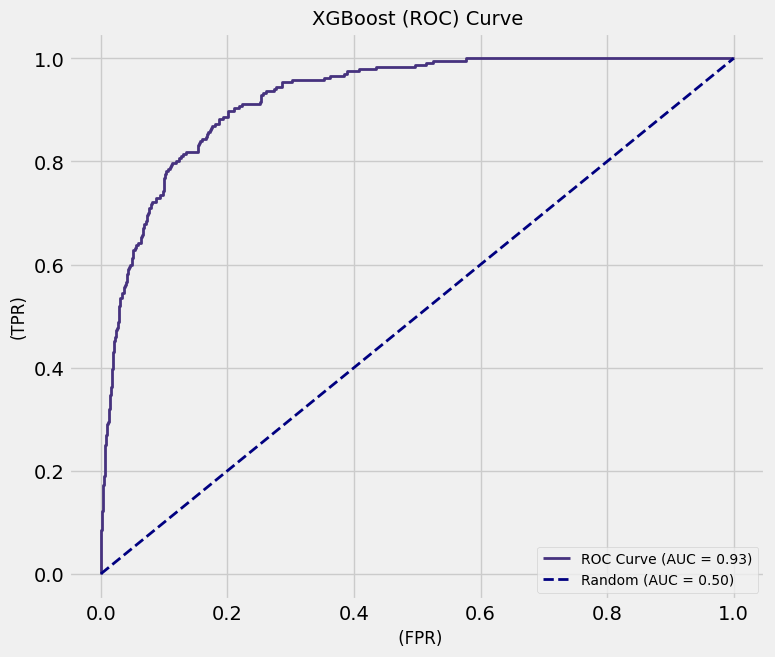

In [45]:
xgboost_pred = best_xgboost.predict(X_valid).astype(int)
y_true = y_valid.astype(int)
print("(XGBoost)Validation's Confusion Matrix : \n",confusion_matrix(y_true,xgboost_pred))
print("(XGBoost)Validation's Precision : ",precision_score(y_true,xgboost_pred))
print("(XGBoost)Validation's Recall : ",recall_score(y_true,xgboost_pred))
roc_auc(y_true,best_xgboost.predict_proba(X_valid)[:,1],method='XGBoost')

(Catboost)Validation's Confusion Matrix : 
 [[1328   56]
 [ 108  129]]
(Catboost)Validation's Precision :  0.6972972972972973
(Catboost)Validation's Recall :  0.5443037974683544


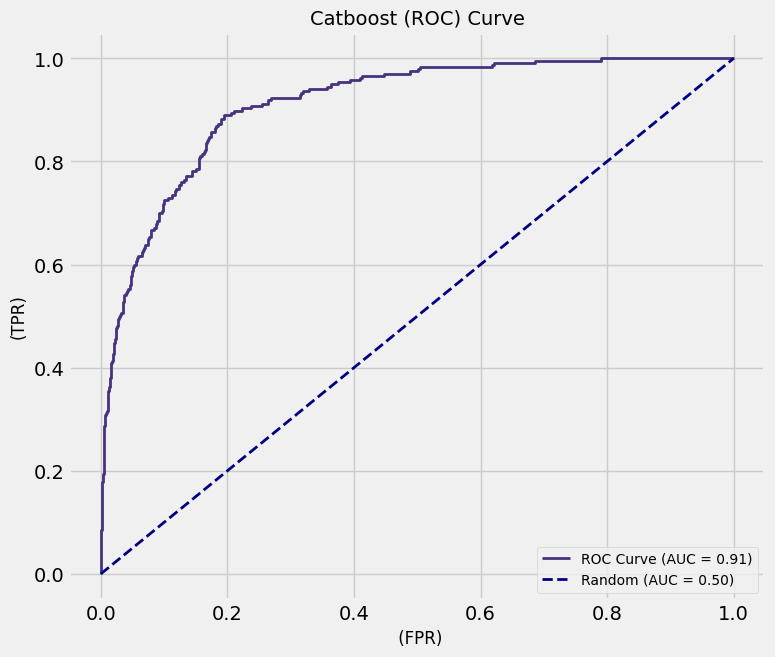

In [46]:
catboost_pred = best_catboost.predict(X_valid).astype(int)

print("(Catboost)Validation's Confusion Matrix : \n",confusion_matrix(y_true,catboost_pred))
print("(Catboost)Validation's Precision : ",precision_score(y_true,catboost_pred))
print("(Catboost)Validation's Recall : ",recall_score(y_true,catboost_pred))
roc_auc(y_true,best_catboost.predict_proba(X_valid)[:,1],method='Catboost')

<h2 align="center"><font color='green'>catboost 訓練及驗證找尋最佳參數</font></h2>

In [ ]:
ensemble_voting= VotingClassifier(estimators= [('catboost', best_catboost),('XGBoost',best_xgboost)], voting='soft')
ensemble_voting.fit(X_train,y_train)



In [ ]:
pred_voting = ensemble_voting.predict(X_valid)
print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_voting.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_voting.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_voting.astype(int)))

In [ ]:
ensemble_stacking= StackingClassifier(estimators= [('catboost', best_catboost),('XGBoost',best_xgboost)],final_estimator=LogisticRegression())
ensemble_stacking.fit(X_train,y_train)

In [ ]:
pred_stacking = ensemble_stacking.predict(X_valid)
print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_stacking.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_stacking.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_stacking.astype(int)))

In [ ]:
import pickle
model = pickle.load(open('../models/xgb_catboost_stacking_model', 'rb'))

In [ ]:
X_valid['SpecialDay']

In [ ]:
pred_stacking = model.predict(X_valid)
print('Confusion Matrix : \n',confusion_matrix(y_valid.astype(int),pred_stacking.astype(int)))
print('Precision : ',precision_score(y_valid.astype(int),pred_stacking.astype(int)))
print('Recall : ',recall_score(y_valid.astype(int),pred_stacking.astype(int)))

In [ ]:
# test_data = pd.read_csv("./data/test.csv")
# test_data = test_data[X_train.columns]
# def numeric_transform(x):
#     return x**(1/3)
# for col in numeric_cols:
#     test_data[col] = test_data[col].astype('float32')
#     test_data[col] = test_data[col].apply(numeric_transform)
# for col in category_cols:
#     test_data[col] = test_data[col].astype('int').astype('category')

# model = pickle.load(open('./model/xgb_catboost_stacking_model', 'rb'))
# prediction = model.predict(test_data)

In [ ]:
[0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0]